# 23S1-AI6124 Stock Trading Project Assignment
Created by A/Prof Kai Keng ANG (kkang@i2r.a-star.edu.sg, kkang@ntu.edu.sg). Last modified 30 Aug 2023

Submitted by: [ONG WEN QING] Mat ID: [G2202256K]

 # 1.Objective for Project

After completing this project, you will know:

Part 1: (Code provided)
* How to download any stock prices to work on
* How to compute buy sell signals on the stock
* How to measure portfolio performance from profit and loss based on buy and sell signals on the stock

Part 2: (To be coded by student)
* How to choose parameters to optimize profits, and explore different trading strategies
* How to apply computational intelligent methods to choose parameters of trading strategies on training data set, then apply to test data set
* How to benchmark the portfolio performance of  computational intelligent methods

Part 3: (To be coded by student)
* How to apply computational intelligent methods to measure the performance of the prediction
* How to interpret and explain the computational intelligent method in predicting the stock prices
* How to apply the stock price prediction to help increase profits, and benchmark the portfolio performance with and without prediction

Code for part 1 of first 3 objectives listed above are provide for you to kick start your project. You will have to complete part 2 and part 3 for the project.


Figure 1: Implmentation for Stock trading project assignment


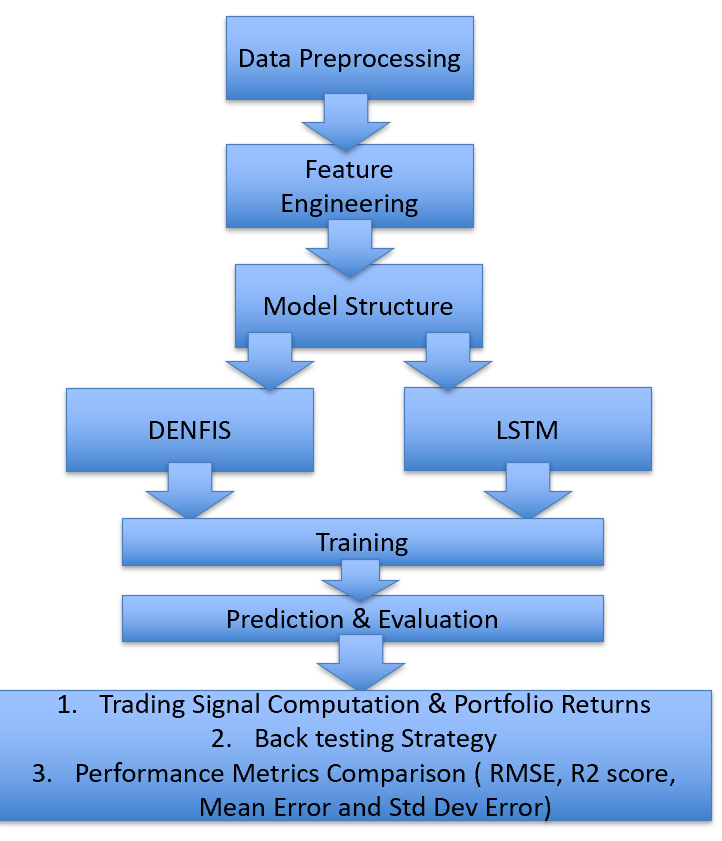

# 2.Dataset selection and preparation

##2.1 Import Libraries

In [ ]:
import numpy as np

import pandas as pd
pd.options.mode.chained_assignment = None  # Remove warning messages

import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from matplotlib.pyplot import figure
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import logging
logging.getLogger('tensorflow').disabled = True

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Remove WARNING Messages

import tensorflow as tf
from tensorflow import keras

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

<ipython-input-1-c91ade627046>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
#Library import for LSTM

from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Flatten,Input
import matplotlib.pyplot as plt
from keras.layers import LSTM,Dense,Dropout,MaxPooling1D,TimeDistributed,Conv1D
from keras.models import load_model
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score
from keras.regularizers import l2
from keras import regularizers, initializers, optimizers
from keras.callbacks import ReduceLROnPlateau



##2.2 Selection of Dataset

Raw number of samples: 5856
Number of samples after dropping NAN values: 5856


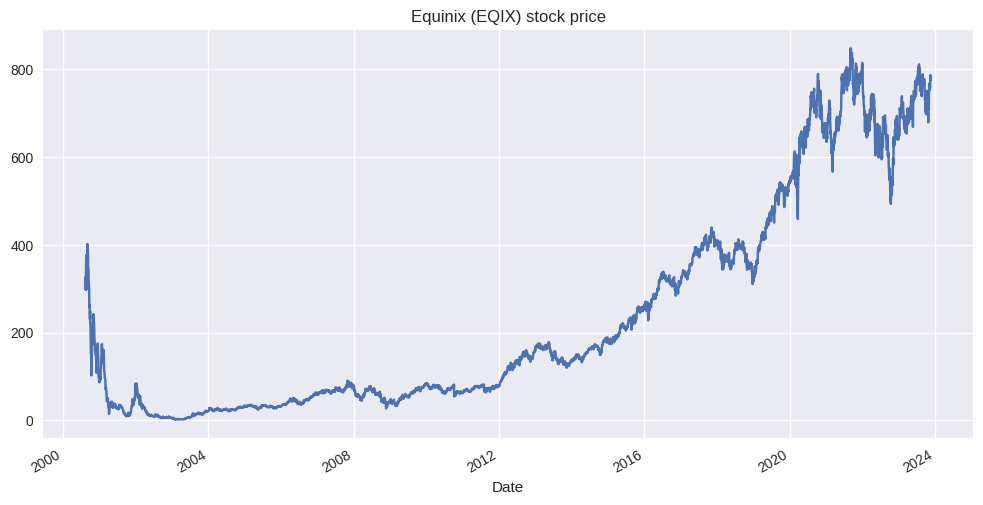

In [ ]:
# Select Stock Price and plot 'Close' price
ticker = yf.Ticker('EQIX')
EQ_DF=ticker.history(period="max")
figure(figsize=(12, 6))
EQ_DF['Close'].plot(title="Equinix (EQIX) stock price")

# Drop any NAN values
print(f'Raw number of samples: {len(EQ_DF)}')
EQ_DF = EQ_DF.dropna(axis=0, how='any')
print(f'Number of samples after dropping NAN values: {len(EQ_DF)}')

Reasons to choose Equinix (EQIX) :


1.   Solid market fundamentals: The surge in digital trends like cloud services, IoT, Big Data, and AI has led to increased demand for reliable data center infrastructure. Equinix's services are critical in supporting these technologies.
2.  Strong Portfolio and Network: Equinix boasts a significant customer base that benefits from the network effect within its data centers, providing efficiencies and cost savings in IT infrastructure management.
3.  Robust Financials: Equinix's financial stability is evident from its strong balance sheet, substantial liquidity, and solid credit ratings, which enable it to pursue growth while providing favorable access to capital.




In [ ]:

# define number of previous days delta closing prices as features to predict tomorrow's delta closing price
num_days = 3
num_features = num_days
num_rows = len(EQ_DF)
EQ_DF['x_1'] = 0.0 # c(T) - c(T-1)
EQ_DF['x_2'] = 0.0 # c(T-1) - c(T-2)
EQ_DF['x_3'] = 0.0 # c(T-2) - c(T-3)
EQ_DF['y_0'] = 0.0 # c(T+1) - c(T)

for i in range(num_days, num_rows-1):
    EQ_DF['x_1'].iloc[i] = EQ_DF['Close'].iloc[i] - EQ_DF['Close'].iloc[i-1]
    EQ_DF['x_2'].iloc[i] = EQ_DF['Close'].iloc[i-1] - EQ_DF['Close'].iloc[i-2]
    EQ_DF['x_3'].iloc[i] = EQ_DF['Close'].iloc[i-2] - EQ_DF['Close'].iloc[i-3]
    EQ_DF['y_0'].iloc[i] = EQ_DF['Close'].iloc[i+1] - EQ_DF['Close'].iloc[i]

# Save required information to new dataframe
df = EQ_DF.iloc[num_days:num_rows-1][['x_1', 'x_2', 'x_3', 'y_0','Close']]
display(df.head(10))

# Convert dataframe to numpy
data = df.to_numpy()
X = data[:,0:num_features]
Y = data[:,-2]
Y = Y.reshape(-1,1)

# scale data to [0, 1] for models
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
scaler_X.fit(X)
scaler_Y.fit(Y)
X = scaler_X.transform(X)
Y = scaler_Y.transform(Y)

x_1        x_2        x_3        y_0  \
Date                                                                    
2000-08-16 00:00:00-04:00   6.204834   3.102631 -27.922485  -9.307465   
2000-08-17 00:00:00-04:00  -9.307465   6.204834   3.102631  57.396088   
2000-08-18 00:00:00-04:00  57.396088  -9.307465   6.204834  21.717499   
2000-08-21 00:00:00-04:00  21.717499  57.396088  -9.307465 -41.883636   
2000-08-22 00:00:00-04:00 -41.883636  21.717499  57.396088 -12.410034   
2000-08-23 00:00:00-04:00 -12.410034 -41.883636  21.717499 -23.268646   
2000-08-24 00:00:00-04:00 -23.268646 -12.410034 -41.883636  20.166229   
2000-08-25 00:00:00-04:00  20.166229 -23.268646 -12.410034   6.204987   
2000-08-28 00:00:00-04:00   6.204987  20.166229 -23.268646   6.204926   
2000-08-29 00:00:00-04:00   6.204926   6.204987  20.166229  20.166321   

                                Close  
Date                                   
2000-08-16 00:00:00-04:00  307.146912  
2000-08-17 00:00:00-04:00  297.839447  
2000-08-18 00:00:00-04:00  355.235535  
2000-08-21 00:00:00-04:00  376.953033  
2000-08-22 00:00:00-04:00  335.069397  
2000-08-23 00:00:00-04:00  322.659363  
2000-08-24 00:00:00-04:00  299.390717  
2000-08-25 00:00:00-04:00  319.556946  
2000-08-28 00:00:00-04:00  325.761932  
2000-08-29 00:00:00-04:00  331.966858

Figure 2: Number of previous days delta closing proces as a feature for prediction of tomorrow delta closing price

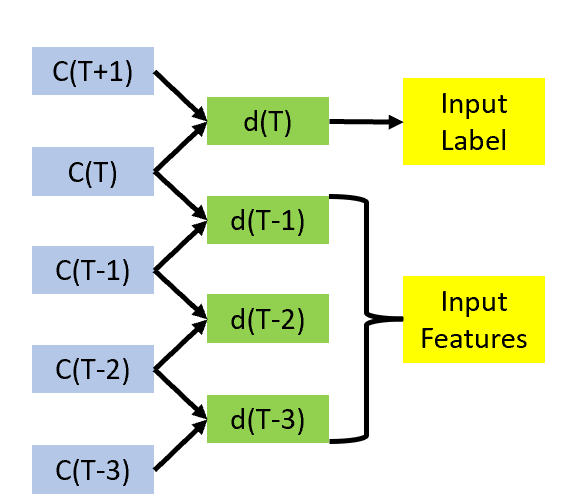

Split Dataset into train,val and test and
determine the shapes and number of training , validation and testing data




In [ ]:

# Split data into 55/25/20 train/val/test datasets
num_train = int(len(X)*0.55)
num_val = int(len(X)*0.8)
num_test = len(X)

X_train = X[0:num_train,:]
y_train = Y[0:num_train]
X_val = X[num_train:num_val,:]
y_val = Y[num_train:num_val]
X_test = X[num_val:num_test,:]
y_test = Y[num_val:num_test]

print(f'No. of data samples: {len(X)}')
print(f'No. of training data samples: {len(X_train)} with shape {X_train.shape}')
print(f'No. of validation data samples: {len(X_val)} with shape {X_val.shape}')
print(f'No. of testing data samples: {len(X_test)} with shape {X_test.shape}')

num_start_date = df.index[0]
num_train_date = df.index[num_train]
num_val_date = df.index[num_val]
print(f'num_train_date is {num_train_date}')
print(f'num_val_date is {num_val_date}')



No. of data samples: 5852
No. of training data samples: 3218 with shape (3218, 3)
No. of validation data samples: 1463 with shape (1463, 3)
No. of testing data samples: 1171 with shape (1171, 3)
num_train_date is 2013-06-05 00:00:00-04:00
num_val_date is 2019-03-28 00:00:00-04:00


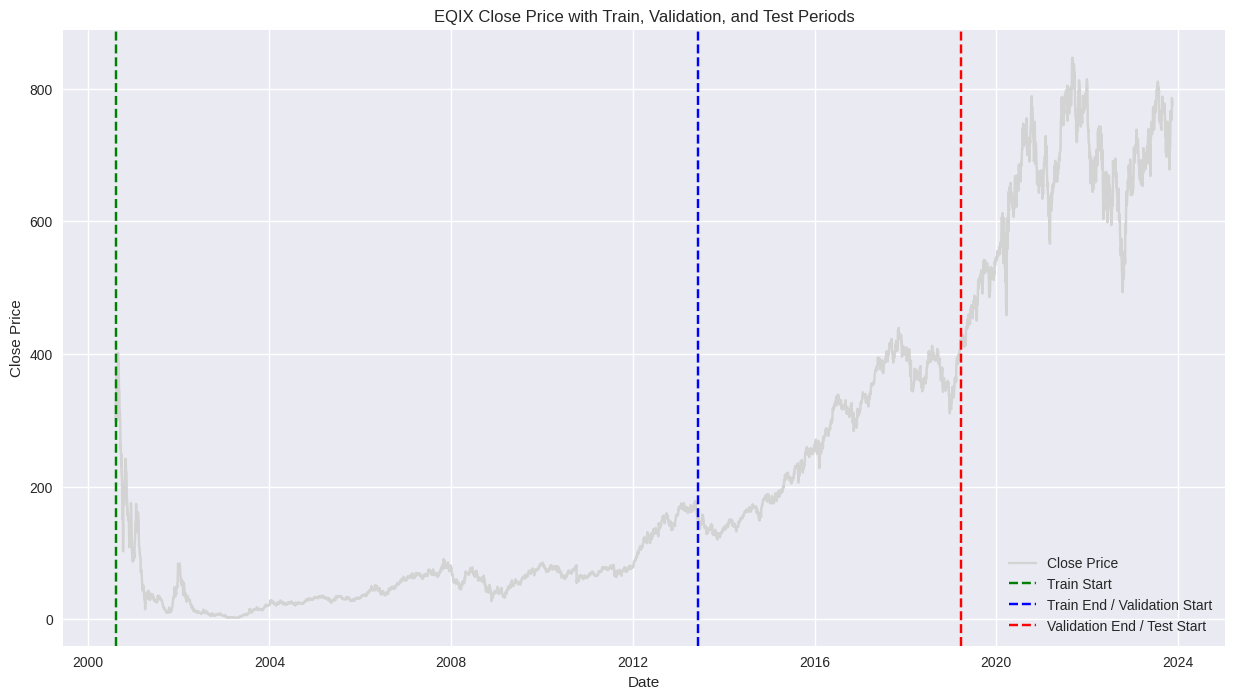

In [ ]:

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(EQ_DF['Close'], label='Close Price', color='lightgray')
plt.axvline(x=num_start_date, color='green', linestyle='--', label='Train Start')
plt.axvline(x=num_train_date, color='blue', linestyle='--', label='Train End / Validation Start')
plt.axvline(x=num_val_date, color='red', linestyle='--', label='Validation End / Test Start')


plt.title("EQIX Close Price with Train, Validation, and Test Periods")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


In [ ]:
#Check the shape of the training dataset

X_train.shape

(3218, 3)

## 2.3 Define Functions for Computing Trade Signals


## compute_trade_signals
Uses simple moving averages of 10 days and 50 days, and compute trade signals based on T and T-1


## compute_trade_signals_predicted
Uses simple moving averages of 10 days and 50 days, and compute trade signals based on T and T+1


## plot_price
Plot original stock 'Close' price
Plot FMA and SMA based on predicted 'Close' price
Plot Buy and Sell signals based on predicted 'Close' price


## compute_returns
Compute portfolio returns based on Buy and Sell signals from predicted 'Close' price whilst using original 'Close' price

The computation of portfolio returns in this section is based on the multiplicative returns given by (refer equation 11 of the reference paper)
𝑅(𝑇)={1+𝐹(𝑇−1)𝑟(𝑇)}{1−𝛿|𝐹(𝑇)−𝐹(𝑇−1)|}
where   𝑟(𝑇)=(𝑦(𝑇)/𝑦(𝑇−1))−1 ;  
        𝑦(𝑇)  is the closing price at time  𝑇 ;  
        𝐹(𝑇)  is the action from the trading system; and  𝛿  is the transaction rate.
        
The multplicative profits  𝑅  can computed using
𝑅=∏𝑅(𝑇) , from T = 1 through n
where  𝑛  is the total number of time points.


## compare_trade_signals
Plots 'Close', SMA, FMA from original dataframe together with the trade signals from the models vs without forecast

Reference Paper: Ang, K. K., & Quek, C. (2006). Stock Trading Using RSPOP: A Novel Rough Set-Based Neuro-Fuzzy Approach. IEEE Trans. Neural Netw., 17(5), 1301-1315. doi:http://dx.doi.org/10.1109/TNN.2006.875996


In [ ]:
# Uses simple moving averages of 10 days and 50 days, and compute trade signals based on T and T-1
def compute_trade_signals(tdf, plt_pos, plt_trade):
    # Fast Moving Average (FMA) set at 10 days
    # Slow Moving Average (SMA) set at 50 days
    tdf['FMA'] = tdf['Close'].rolling(window = 10, min_periods = 1).mean()
    tdf['SMA'] = tdf['Close'].rolling(window = 50, min_periods = 1).mean()

    # Signal happens whenever a crossover happens from one data sample to the next
    # If 0 to 1, means FMA goes above SMA, indicating upward trend
    # If 1 to 0, means FMA goes below SMA, indicating downward trend
    tdf['Signal'] = 0.0
    tdf['Signal'] = np.where(tdf['FMA'] > tdf['SMA'], 1.0, 0.0)

    # Position shows the difference in signal
    # 1 means signal changed from 0 to 1
    # 0 means signal 0 to 0 or 1 to 1
    # -1 means signal changed from 1 to 0
    tdf['Position'] = tdf['Signal'].diff()
    # Need to set the first row of Position to 0. Otherwise it is nan from diff function.
    tdf['Position'].iloc[0]=0

    if plt_pos == True:
        # Plot the positions
        plt.figure(figsize = (20,10))
        plt.title('Position', fontsize = 20)
        tdf['Position'].plot(color = 'k', label= 'Position')

    # Trade to tell us when to buy (position from -1 to 1) or sell (position from 1 to -1)
    # Uses T and T-1
    tdf['Trade'] = tdf['Position']
    prevrow = tdf.iloc[0]
    for index, row in tdf.iloc[1:].iterrows():
        if row['Trade']==0:
            if prevrow['Trade']!=0:
                tdf.at[index,'Trade']=prevrow['Trade']
            row['Trade']=prevrow['Trade']
        prevrow=row

    if plt_trade==True:
        # Plot the trade
        plt.figure(figsize = (20,10))
        plt.title('Trade', fontsize = 20)
        tdf['Trade'].plot(color = 'r', label= 'Trade')

# Uses simple moving averages of 10 days and 50 days, and compute trade signals based on T and T+1
def compute_trade_signals_predicted(tdf, plt_pos, plt_trade):
    # Fast Moving Average (FMA) set at 10 days
    # Slow Moving Average (SMA) set at 50 days
    tdf['FMA'] = tdf['Close'].rolling(window = 10, min_periods = 1).mean()
    tdf['SMA'] = tdf['Close'].rolling(window = 50, min_periods = 1).mean()

    # Signal happens whenever a crossover happens from one data sample to the next
    # If 0 to 0 or 1 to 1, means no crossover
    # If 0 to 1, means FMA goes above SMA, indicating upward trend
    # If 1 to 0, means FMA goes below SMA, indicating downward trend
    tdf['Signal'] = 0.0
    tdf['Signal'] = np.where(tdf['FMA'] > tdf['SMA'], 1.0, 0.0)

    # Position shows the difference in signal
    # 1 means signal changed from 0 to 1 (Buy)
    # 0 means signal 0 to 0 or 1 to 1 (Do nothing)
    # -1 means signal changed from 1 to 0 (Sell)
    tdf['Position'] = tdf['Signal'].diff()
    # Need to set the first row of Position to 0. Otherwise it is nan from diff function.
    tdf['Position'].iloc[0]=0

    if plt_pos == True:
        # Plot the positions
        plt.figure(figsize = (20,10))
        plt.title('Position', fontsize = 20)
        tdf['Position'].plot(color = 'k', label= 'Position')

    # Trade to tell us when to buy (position from -1 to 1) or sell (position from 1 to -1)
    # Uses T and T+1
    tdf['Trade'] = tdf['Position']
    for i in range(1,len(tdf)):
        if i != len(tdf)-1:
            if tdf['Trade'].iloc[i] == 0:
                if tdf['Trade'].iloc[i+1] == 0:
                    tdf['Trade'].iloc[i] = tdf['Trade'].iloc[i-1]
                elif tdf['Trade'].iloc[i+1] != 0:
                    tdf['Trade'].iloc[i] = tdf['Trade'].iloc[i+1]
        else:
            tdf['Trade'].iloc[i] = tdf['Trade'].iloc[i-1]

    if plt_trade==True:
        # Plot the trade
        plt.figure(figsize = (20,10))
        plt.title('Trade', fontsize = 20)
        tdf['Trade'].plot(color = 'r', label= 'Trade')


# Plot Original 'Close' Price, and SMA FMA, Buy and Sell signals from predicted 'Close' Price
def plot_price(tdf, time_period):
    # if tdf is a zoomed in timeframe, set time_period to True, else set to False
    if time_period == False:
        # Plot original 'Close' price
        plt.figure(figsize = (20,10))
        df['Close'].plot(color = 'k', label= 'Close')

        # Plot FMA and SMA of tdf
        tdf['FMA'].plot(color = 'b', label = 'FMA')
        tdf['SMA'].plot(color = 'g', label = 'SMA')

        # Plot buy and sell signals of tdf
        plt.plot(tdf[tdf['Position'] == 1].index, tdf['FMA'][tdf['Position'] == 1], '^', markersize = 15, color = 'g', label = 'buy')
        plt.plot(tdf[tdf['Position'] == -1].index, tdf['FMA'][tdf['Position'] == -1], 'v', markersize = 15, color = 'r', label = 'sell')

        plt.ylabel('Price', fontsize = 15 )
        plt.xlabel('Date', fontsize = 15 )
        plt.title('EQIX', fontsize = 20)
        plt.legend()
        plt.grid()
        plt.show()

    else:
        time_period_start = tdf.index[0]
        time_period_end = tdf.index[-1]

        # Plot original 'Close' price
        plt.figure(figsize = (20,10))
        df.loc[time_period_start:time_period_end]['Close'].plot(color = 'k', label= 'Close')

        # Plot FMA and SMA of tdf
        tdf['FMA'].plot(color = 'b', label = 'FMA')
        tdf['SMA'].plot(color = 'g', label = 'SMA')

        # Plot buy and sell signals of tdf
        plt.plot(tdf[tdf['Position'] == 1].index, tdf['FMA'][tdf['Position'] == 1], '^', markersize = 15, color = 'g', label = 'buy')
        plt.plot(tdf[tdf['Position'] == -1].index, tdf['FMA'][tdf['Position'] == -1], 'v', markersize = 15, color = 'r', label = 'sell')

        plt.ylabel('Price', fontsize = 15 )
        plt.xlabel('Date', fontsize = 15 )
        plt.title('EQIX', fontsize = 20)
        plt.legend()
        plt.grid()
        plt.show()


# Compute portfolio returns based original 'Close' price and Buy and Sell signals from predicted 'Close' price
def compute_returns(tdf,transaction_rate):
    tdf['Returns']=1.0
    prevrow = tdf.iloc[0]
    returncol=tdf.columns.get_loc('Returns')
    for i in range(len(tdf)):
        if i==0:
            prev_i=i
        else:
            # Original 'Close' price return ratio
            prevrow_rt=df.iloc[prev_i]
            row_rt=df.iloc[i]
            rt=(row_rt['Close']/prevrow_rt['Close'])-1

            # Compute returns based on trade signals from predicted price
            prevrow=tdf.iloc[prev_i]
            row=tdf.iloc[i]
            t=prevrow['Returns']*(1+prevrow['Trade']*rt)*(1-transaction_rate*abs(row['Trade']-prevrow['Trade']))
            tdf.iat[i,returncol]=t
            prev_i=i
    return tdf


# Plots 'Close', SMA, FMA from original dataframe together with the trade signals from the models vs without forecast
def compare_trade_signals(time_period, date_start, date_end):
    # if time_period set to True, provided date_start & date_end
    # if time_period set to False, set date_start & date_end to '0'
    with plt.style.context('default'):
        if time_period == True:

            #define subplots
            fig,ax = plt.subplots(figsize = (20,10))
            ax.set_title(f'Close Price and Trading Signals from Date {date_start} to {date_end}', fontsize=20)

            #add first axis plots
            ax.plot(df[date_start:date_end].index, df[date_start:date_end]['Close'], color = 'k', label= 'Close')
            ax.plot(df[date_start:date_end].index, df[date_start:date_end]['SMA'], color = 'b', label = 'SMA')
            ax.plot(df[date_start:date_end].index, df[date_start:date_end]['FMA'], color = 'y', label = 'FMA')
            ax.legend(loc=2, fontsize=15)
            #add x-axis label
            ax.set_xlabel('Date', fontsize=15)

            #add y-axis label
            ax.set_ylabel('Close Price', fontsize=15)

            #define second y-axis that shares x-axis with current plot
            ax2 = ax.twinx()

            #add second axis plots
            ax2.plot(df[date_start:date_end].index, df[date_start:date_end]['Trade'], color = 'k', linestyle = '-', label = 'Without Forecaset')
            ax2.plot(df2[date_start:date_end].index, df2[date_start:date_end]['Trade'], color = 'g', linestyle = '--', label = 'DENFIS Forecaset')
            ax2.plot(df3[date_start:date_end].index, df3[date_start:date_end]['Trade'], color = 'r', linestyle = ':', label = 'LSTM Forecaset')
            ax2.legend(loc=6, fontsize=15)

            #add second y-axis label
            ax2.set_ylabel('Trading Signal', fontsize=15)
            ax2.set_ylim(-1, 10)

        else:

            #define subplots
            fig,ax = plt.subplots(figsize = (20,10))
            ax.set_title('Close Price and Trading Signals', fontsize=20)

            #add first line to plot
            ax.plot(df.index, df['Close'], color = 'k', label= 'Close')
            ax.plot(df.index, df['SMA'], color = 'b', label = 'SMA')
            ax.plot(df.index, df['FMA'], color = 'y', label = 'FMA')
            ax.legend(loc=2, fontsize=15)
            #add x-axis label
            ax.set_xlabel('Date', fontsize=15)

            #add y-axis label
            ax.set_ylabel('Close Price', fontsize=15)

            #define second y-axis that shares x-axis with current plot
            ax2 = ax.twinx()

            #add second line to plot
            ax2.plot(df.index, df['Trade'], color = 'k', linestyle = '-', label = 'Without Forecaset')
            ax2.plot(df2.index, df2['Trade'], color = 'g', linestyle = '--', label = 'DENFIS Forecaset')
            ax2.plot(df3.index, df3['Trade'], color = 'r', linestyle = ':', label = 'LSTM Forecaset')
            ax2.legend(loc=6, fontsize=15)
            #add second y-axis label
            ax2.set_ylabel('Trading Signal', fontsize=15)
            ax2.set_ylim(-1, 10)


def calculate_rmse(predictions, actuals):
    """
    Calculate the Root Mean Square Error (RMSE) between predictions and actuals.
    :return: RMSE value
    """
    mse = np.mean((predictions - actuals) ** 2)
    return np.sqrt(mse)

# 3.Hybrid AI model: Dynamic Evolving Neural Fuzzy Inference System (DENFIS)






## 3.1 DENFIS Structure Explanation






The DENFIS framework shown in Figure 2, a Takagi-Sugeno-Kang (TSK) type Neuro-Fuzzy Inference System, is a sophisticated approach for time-series prediction, merging Takagi-Sugeno-Type fuzzy rules with Evolving Clustering Methods (ECM). It formulates each fuzzy rule using antecedents over specific domains and consequents as polynomial functions, typically employing triangular type membership functions. The online model utilizes first-order Takagi-Sugeno type fuzzy rules with linear functions in the consequents, updated via a linear least-square estimator. Conversely, the offline model employs ECM with a constrained optimization method (ECMc) to refine cluster centers based on an objective function. ECM’s clustering is dynamic, adjusting cluster centers and radii according to new data, controlled by a threshold for the maximum cluster distance.

DENFIS is tailored for both adaptive online and offline learning in dynamic time series prediction, evolving through incremental hybrid learning (both supervised and unsupervised). It adapts to new input data, including novel features and classes, via local element tuning. During its operation, DENFIS continuously creates and updates fuzzy rules, calculating outputs through a fuzzy inference system based on dynamically chosen, highly activated fuzzy rules.

Hence, DENFIS is both an evolving fuzzy neural network (eFs) and a neuro-fuzzy inference system, showcasing its dynamic and adaptive characteristics. It integrates neural network methodologies with fuzzy logic for effective inference and learning, making it adept at handling and learning from complex time-series data in varying contexts.


Figure 3: Illustration of DENFIS Structures from input layer, fuzzy layer, rule-firing layer, normalize layer, consquent layer and finally output layer.

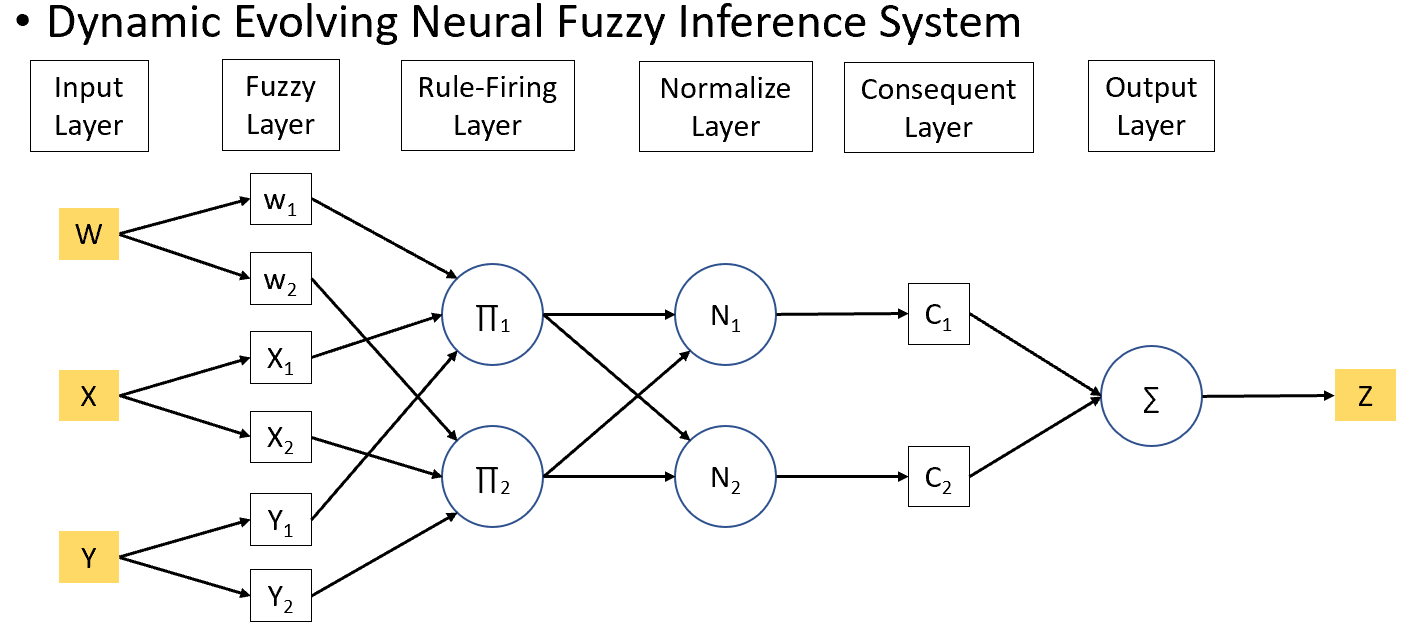

Key component of DENFIS:

1. Input Layer: The initial data or input signals (A, B, C) enter the neural network through this layer.

2. Fuzzy Layer: Here, each input variable is linked to a set of fuzzy sets (A1, A2, B1, B2, C1, C2), which fuzzify the input values, converting crisp inputs into degrees of membership within these fuzzy sets.

3. Rule-Firing Layer: Contains nodes (T1, T2) representing fuzzy rules, typically structured as IF-THEN statements. These rules determine the applicability degree based on the fuzzified inputs.

4. Normalize Layer: The outputs from the rule-firing layer are normalized in nodes (N1, N2) to ensure comparable scaling and to transform the rule strengths into a sum of one.

5. Consequent Layer: Associated with each rule, the consequents (C1, C2) are the rule outputs before defuzzification, usually being linear combinations of the input variables.

6. Output Layer: This final layer aggregates the contributions from all rules (Σ) and produces a defuzzified, crisp output (Y) reflecting the system's prediction or decision based on the inputs.

Hence, DENFIS is capable of adapting its structure and parameters with incoming data, making it highly suitable for dynamic, non-stationary data environments or for models requiring continuous updates with new information.

Evolving Clustering Method (ECM) employed in DENFIS:

DENFIS utilizes an evolving clustering method that dynamically adapts to streaming data, making it highly effective for real-time applications. This method is grounded in fuzzy logic, allowing data points to belong to multiple clusters with varying degrees of membership, which is expressed using fuzzy membership functions. The clustering in DENFIS is an ongoing online process, continuously learning and updating with each new data point. It leverages an evolving structure, where clusters can be created, adjusted, or merged based on incoming data. This adaptability is crucial in non-stationary environments, characterized by concept drift, ensuring the model remains accurate and relevant. A key mathematical aspect of this approach is the use of fuzzy membership functions, typically of the form \( \mu(x) = \exp(-\beta \cdot (x - c)^2) \), where \( \mu(x) \) is the membership degree, \( \beta \) is a parameter determining the width of the fuzzy set, \( x \) is the data point, and \( c \) is the cluster center. This equation underpins the fuzzy logic aspect, enabling nuanced data clustering and enhancing DENFIS's capability to handle complex, evolving data streams.





Figure 4: Illustration of Evolving clustering method

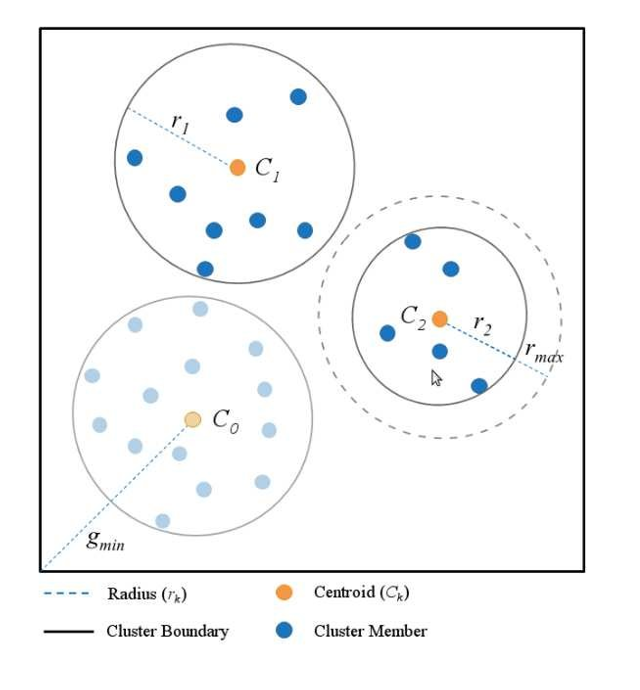

##3.2 Literature Review


The theoretical research on Evolving Fuzzy Systems (eFS) has seen significant developments, especially in their application to time-varying systems and online adaptation to new data streams. As a subset of Fuzzy Rule-Based Systems (FRBSs), eFS are uniquely capable of self-adjusting both the parameters and structure of rules in response to new, incoming data. This dynamic adjustment involves updating existing parameters and structures, generating new rules, or deleting less relevant ones, guided by online clustering decisions that determine rule creation or input space partitioning. New rules emerge when incoming data significantly diverges from existing rules, while rules with the lowest potential are pruned to maintain an optimal rule base.

The versatility of eFS extends to standard FRBSs, Hybrid Fuzzy Systems (HFS), and Neural Fuzzy Systems (NFS), each incorporating incremental learning approaches for adapting to new data streams. In standard FRBSs, evolving clustering methods are used to update antecedents and manage the addition or removal of rules. NFS, on the other hand, utilize adaptive methods that evolve the system by updating antecedents through clustering methods and concurrently adjusting weights for consequents.

From 2010 to 2021, the field of eFS witnessed numerous advancements, including the development of multi-input multi-output evolving Takagi-Sugeno models, methods to handle concept drift in online data streams, and the emergence of self-evolving recurrent fuzzy neural networks suitable for dynamic systems. This period also saw the introduction of models that learn rule bases from scratch, catering to the specific characteristics of incoming data streams, and the Generalized eFS model, which simplifies high-dimensional input data into single fuzzy sets for enhanced interpretability.

Post-2021, the research focus shifted towards Neuro-eFS, integrating neural network methods with eFS, as evidenced by the development of self-evolving interval type-2 NFS for system identification and control. Structural updates in eFS, such as the implementation of compression layers for antecedents and evolving methodologies to improve the accuracy-interpretability trade-off, have also been significant. The increased interest in Type-II fuzzy sets has led to more robust and adaptable eFS models. Furthermore, the application of eFS in diverse fields such as engine testing, gene data expression, and thermal modeling of power transformers highlights their practical utility in a variety of real-world scenarios.

In summary, from their initial concept and development before 2010, focusing on online learning environments, to the recent trends emphasizing structural updates, type-II fuzzy sets, and diverse applications, eFS have consistently demonstrated growth in sophistication, adaptability, and applicability, addressing complex challenges in dynamic, data-driven environments.








Figure 5: Type of Fuzzy System and current application.

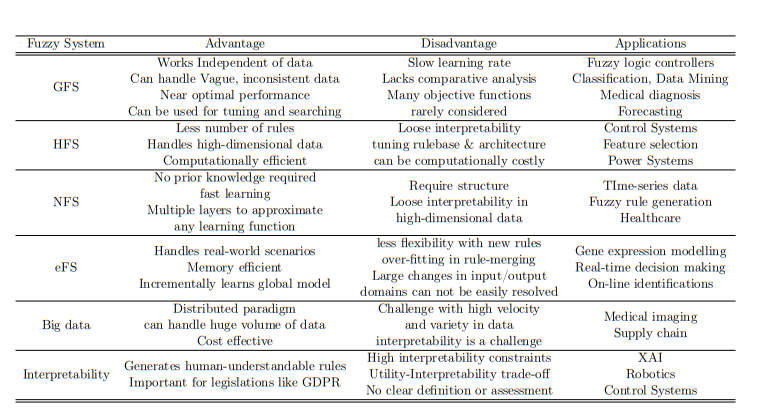

Comparison of  DENFIS to other methods, such as online learning algorithms, reinforcement learning, AdaBoost, or decision trees, DENFIS is more adaptable to changing data patterns and more sophisticated in dealing with the fuzzy nature of real-world data streams. However, this adaptability comes at the cost of increased model complexity and reduced interpretability. While other algorithms might offer simplicity or better interpretability, they often fall short in real-time adaptability and handling evolving data streams, highlighting DENFIS's unique niche in data stream analysis.

## 3.3 ECM initialization and DENFIS MODEL architecture

In [ ]:
def ECM_init(X_input, D_thr):
    Clusters = {}
    Clusters[0] = [X_input[0]]
    Clusters_center = {}
    Clusters_center[0] = X_input[0]
    Clusters_radius = []
    Clusters_radius = np.append(Clusters_radius, 0)
    D_threshold = D_thr
    return Clusters, Clusters_center, Clusters_radius, D_threshold


def ECM(X_input, D_thr):

    # Initialize ECM variables
    Clusters, Clusters_center, Clusters_radius, D_threshold = ECM_init(X_input, D_thr)

    X_data = X_input[1:]
    num_features = len(X_data[0])

    for i in range(len(X_data)):
        num_clusters = len(list(Clusters_center.keys()))

        # create and calculate array of euclidean distance of datapoint i to centers of existing clusters
        d = np.zeros(num_clusters)
        for j in range(num_clusters):
            d[j] = ((((X_data[i] - Clusters_center[j])**2).sum())**0.5) / (num_features**0.5)

        # get index of nearest cluster
        nearest_cluster = np.argmin(d)

        # put datapoint i into nearest cluster if datapoint within radius of nearest cluster
        if d[nearest_cluster] <= Clusters_radius[nearest_cluster]:
            cluster_data = Clusters[nearest_cluster]
            Clusters[nearest_cluster] = np.append(cluster_data, [X_data[i]], axis=0)

        else:
            # compute s
            s = np.zeros(num_clusters)
            for j in range(num_clusters):
                s[j] = d[j] + Clusters_radius[j]
            # get index of nearest cluster
            nearest_cluster = np.argmin(s)

            # create new cluster if datapoint is outside of threshold
            if s[nearest_cluster] > 2*D_thr:
                Clusters[len(Clusters.keys())] = [X_data[i]]
                Clusters_center[len(Clusters.keys())-1] = X_data[i]
                Clusters_radius = np.append(Clusters_radius, 0)

            # put datapoint into nearest cluster, then compute new center and radius of cluster
            else:
                cluster_data = Clusters[nearest_cluster]
                Clusters[nearest_cluster] = np.append(cluster_data, [X_data[i]], axis=0)

                if Clusters_radius[nearest_cluster] < D_thr:
                    Clusters_radius[nearest_cluster] = s[nearest_cluster] / 2 ## Original
                    v = Clusters_center[nearest_cluster] - X_data[i]
                    v_mag = ((v**2).sum())**0.5
                    v_unit = v / (v_mag)
                    Clusters_center[nearest_cluster] = X_data[i] + v_unit*Clusters_radius[nearest_cluster] ## Original

                else:
                    print(f'\Cluster radius > D_thr')

    num_clusters = len(list(Clusters_center.keys()))
    Clusters_center = np.asarray(list(Clusters_center.values())).astype('float32')
    print(f'Total number of clusters: {num_clusters}')
    for i in range(num_clusters):
        print(f'Cluster {i} center: {Clusters_center[i]} with radius {Clusters_radius[i]} and {len(Clusters[i])} datapoints inside')
    return Clusters, Clusters_center, Clusters_radius, D_threshold


In [ ]:
# parameter class denfis parameters
class denfis_parameters():
    def __init__(self, clusters_center, batch_size: int, n_epochs: int, optimizer: str = 'sgd', loss: str = 'mse'):
        self.n_input = len(clusters_center[0]) # no. of features
        self.m_input = len(clusters_center) # no. of membership functions AKA clusters
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.optimizer = optimizer
        self.loss = loss


# Main Class DENFIS
class DENFIS:
    def __init__(self, clusters_center, D_thr: float, batch_size: int, name: str = 'denfis'):

        self.n = len(clusters_center[0]) # no. of features
        self.m = len(clusters_center) # no. of memberhip functions AKA clusters
        self.batch_size = batch_size

        input_ = keras.layers.Input(shape=(self.n), name='input_Layer', batch_size=self.batch_size)
        print(f'input_ type: {type(input_)} and shape {input_.shape}')

        L1 = Fuzzy_Layer(clusters_center, D_thr, name='fuzzy_layer')(input_)
        print(f'L1 output type: {type(L1)} and shape {L1.shape}')

        L2 = Rule_Firing_Layer(clusters_center, name='rule_firing_layer')(L1)
        print(f'L2 output type: {type(L2)} and shape {L2.shape}')

        L3 = Norm_Layer(name='norm_Layer')(L2)
        print(f'L3 output type: {type(L3)} and shape {L3.shape}')

        L4 = Consequent_Layer(clusters_center, name='consequent_layer')(L3, input_)
        print(f'L4 output type: {type(L4)} and shape {L4.shape}')

        L5 = Output_Layer(name='output_layer')(L4)
        print(f'L5 output type: {type(L5)} and shape {L5.shape}')

        self.model = keras.Model(inputs=[input_], outputs=[L5], name=name)
        self.update_weights()

    def __call__(self, X):
        return self.model.predict(X, batch_size=self.batch_size)

    def update_weights(self):
        # premise parameters
        self.beta = self.model.get_layer('fuzzy_layer').get_weights()
        # consequence parameters
        self.bias, self.weights = self.model.get_layer('consequent_layer').get_weights()


    def fit(self, X, y, **kwargs):
        # save initial weights in the denfis class
        self.init_weights = self.model.get_layer('fuzzy_layer').get_weights()

        # fit model & update weights in the anfis class
        history = self.model.fit(X, y, **kwargs)
        self.update_weights()

        # clear the graphs
        tf.keras.backend.clear_session()

        return history


# Layer 1
class Fuzzy_Layer(keras.layers.Layer):
    def __init__(self, clusters_center, D_thr, **kwargs):
        super(Fuzzy_Layer, self).__init__(**kwargs)
        self.clusters_center = clusters_center
        self.D_thr = D_thr
        self.n = len(clusters_center[0])
        self.m = len(clusters_center)

    def build(self, batch_input_shape):
        self.batch_size = batch_input_shape[0]
        self.beta = self.add_weight(name='beta',
                                    shape=(self.m, self.n),
                                    initializer=keras.initializers.RandomUniform(minval=1.2, maxval=2.0, seed=1),
                                    constraint=lambda x: tf.clip_by_value(x, 1.2, 2.0),
                                    trainable=True)
        super(Fuzzy_Layer, self).build(batch_input_shape)

    def call(self, x_inputs):
        x_inputs = tf.cast(x_inputs, tf.float32)
        self.b = self.clusters_center
        self.a = tf.math.subtract(self.b, (tf.math.multiply(self.beta, self.D_thr)))
        self.c = tf.math.add(self.b, (tf.math.multiply(self.beta, self.D_thr)))
        x_input = tf.reshape(tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n))
        L1_output = tf.maximum(
                               tf.minimum(tf.divide(tf.subtract(x_input, self.a), tf.subtract(self.b, self.a)),
                                          tf.divide(tf.subtract(self.c, x_input), tf.subtract(self.c, self.b))),
                               0)
        return L1_output # Fuzzy layer output


# Layer 2
class Rule_Firing_Layer(keras.layers.Layer):
    def __init__(self, clusters_center, **kwargs):
        super(Rule_Firing_Layer, self).__init__(**kwargs)
        self.batch_size = None

    def build(self, batch_input_shape):
        self.batch_size = batch_input_shape[0]
        super(Rule_Firing_Layer, self).build(batch_input_shape)

    def call(self, input_):
        L2_output = tf.math.reduce_prod(input_, axis=2)
        return L2_output # Rule Firing layer output


# Layer 3
class Norm_Layer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, w):
        w_sum = tf.reshape(tf.reduce_sum(w, axis=1), (-1, 1))
        w_norm = w / w_sum
        return w_norm # Normalize layer output


# Layer 4
class Consequent_Layer(keras.layers.Layer):
    def __init__(self, clusters_center, **kwargs):
        super().__init__(**kwargs)
        self.n = len(clusters_center[0])
        self.m = len(clusters_center)
        self.bias = self.add_weight(name='Consequence_bias',
                                    shape=(1, self.m),
                                    initializer=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=1),
                                    trainable=True)
        self.weight = self.add_weight(name='Consequence_weight',
                                      shape=(self.n, self.m),
                                      initializer=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=1),
                                      trainable=True)

    def call(self, w_norm, input_):
        L4_L2_output = tf.multiply(w_norm,tf.matmul(input_, self.weight) + self.bias)
        return L4_L2_output # Consequent layer output


# Layer 5
class Output_Layer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.batch_size = batch_input_shape[0]
        super(Output_Layer, self).build(batch_input_shape)

    def call(self, input_):
        L5_L2_output = tf.reduce_sum(input_, axis=1)
        L5_L2_output = tf.reshape(L5_L2_output, (-1, 1))
        return L5_L2_output # Output layer output

## 3.4 DENFIS MODEL Training

Total number of clusters: 9
Cluster 0 center: [0.8816177 0.4828353 0.4205881] with radius 0.1942191857348689 and 79 datapoints inside
Cluster 1 center: [0.4782777  0.6141048  0.31099552] with radius 0.19406809806685876 and 320 datapoints inside
Cluster 2 center: [0.37859374 0.32482955 0.55584794] with radius 0.18239652805491746 and 145 datapoints inside
Cluster 3 center: [0.84813756 0.8051227  0.39174637] with radius 0.20510974439593802 and 16 datapoints inside
Cluster 4 center: [0.6512408 0.5519222 0.7537409] with radius 0.1757923090511847 and 5214 datapoints inside
Cluster 5 center: [0.3800515  0.83449715 0.09176248] with radius 0.18560681739651858 and 3 datapoints inside
Cluster 6 center: [0.7871579 0.        0.9511458] with radius 0.0 and 1 datapoints inside
Cluster 7 center: [0.2146735 0.5789338 0.5817   ] with radius 0.18748320087491996 and 63 datapoints inside
Cluster 8 center: [0.46752024 0.74824816 0.8093904 ] with radius 0.16762051495734365 and 11 datapoints inside
input_ typ

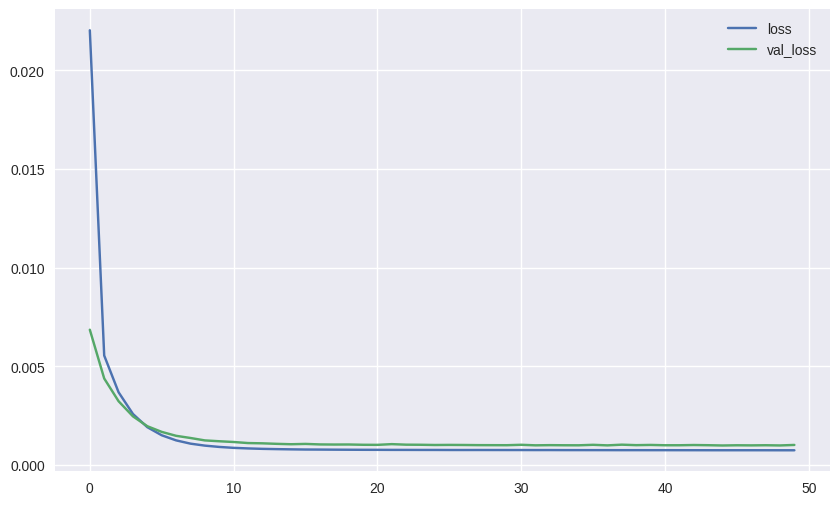

In [ ]:
# Perform ECM on data
Clusters, Clusters_center, Clusters_radius, D_threshold = ECM(X, 0.21)

# Set parameters
param = denfis_parameters(clusters_center=Clusters_center, batch_size=1, optimizer='sgd', loss='mse', n_epochs=50)

denfis_model = DENFIS(clusters_center=Clusters_center, D_thr = D_threshold, batch_size=param.batch_size, name='denfis')

# Compile model
denfis_model.model.compile(optimizer=param.optimizer, loss=param.loss)

# Fit model
history = denfis_model.fit(X_train, y_train, epochs=param.n_epochs, batch_size=param.batch_size, validation_data=(X_val, y_val))

# Plot loss curve and Model summary
loss_curves = pd.DataFrame(history.history)
loss_curves.plot(figsize=(10, 6))
denfis_model.model.summary()

# Get L1 parameters
beta = denfis_model.model.get_layer('fuzzy_layer').get_weights()

# Get L4 paramters
bias = denfis_model.bias
weights = denfis_model.weights

## 3.5 Prediction results and Portfoilo Multiplicative returns of DENFIS model

3218/3218 [==============================] - 6s 2ms/step


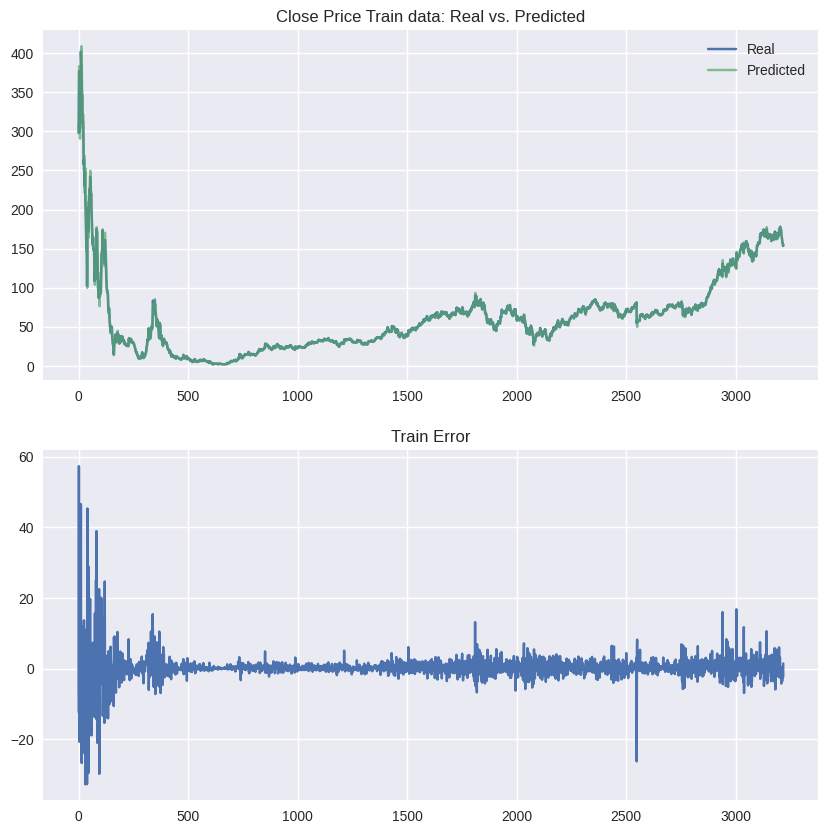

In [ ]:
# Predict train data
y_train_pred_b4 = denfis_model(X_train) # predicted scaled delta
y_train_pred = scaler_Y.inverse_transform(y_train_pred_b4) # predicted unscaled delta
y_train_pred = np.reshape(df['Close'][0:num_train].values, [-1,1]) + y_train_pred # predicted unscaled 'Close' price

# Real train data
y_train = scaler_Y.inverse_transform(y_train) # real unscaled delta
y_train = np.reshape(df['Close'][0:num_train].values, [-1,1]) + y_train # real unscaled 'Close' price

# Plot real train data vs predicted train data
f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(y_train)
axs[0].plot(y_train_pred, alpha=.7)
axs[0].legend(['Real', 'Predicted'])
axs[0].grid(True)
axs[0].set_title('Close Price Train data: Real vs. Predicted')

axs[1].plot(np.arange(y_train.shape[0]), y_train - y_train_pred)
axs[1].grid(True)
axs[1].set_title('Train Error')
plt.show()

1463/1463 [==============================] - 2s 1ms/step


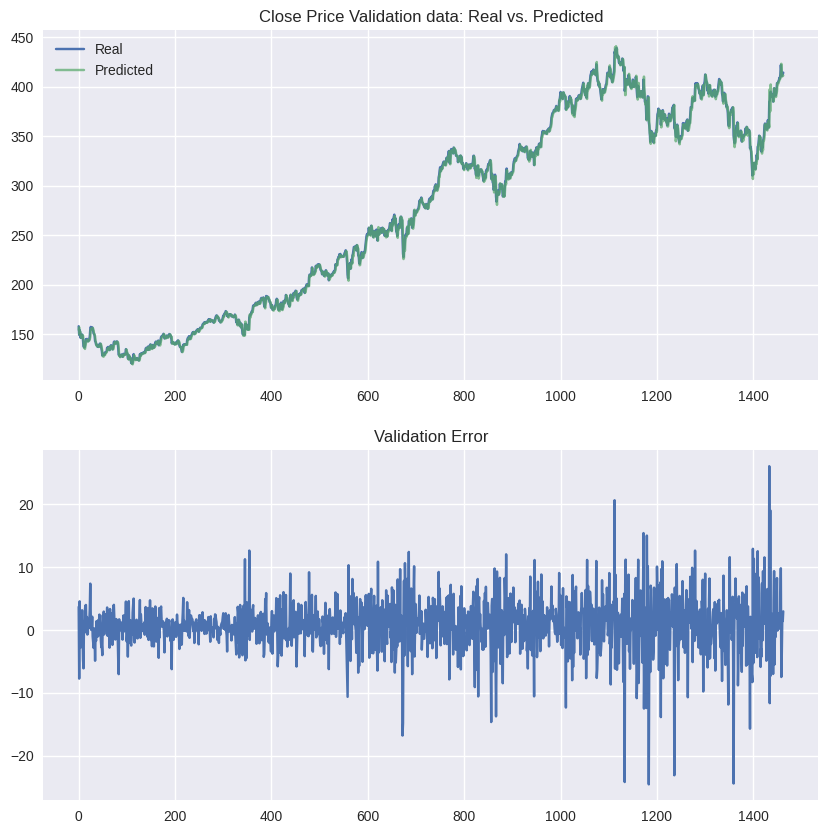

In [ ]:

# Predict val data
y_val_pred_b4 = denfis_model(X_val) # predicted scaled delta
y_val_pred = scaler_Y.inverse_transform(y_val_pred_b4) # predicted unscaled delta
y_val_pred = np.reshape(df['Close'][num_train:num_val].values, [-1,1]) + y_val_pred # predicted unscaled 'Close' price

# Real val data
y_val = scaler_Y.inverse_transform(y_val) # real unscaled delta
y_val = np.reshape(df['Close'][num_train:num_val].values, [-1,1]) + y_val # real unscaled 'Close' price

# Plot val data vs predicted of val data
f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(y_val)
axs[0].plot(y_val_pred, alpha=.7)
axs[0].legend(['Real', 'Predicted'])
axs[0].grid(True)
axs[0].set_title('Close Price Validation data: Real vs. Predicted')
axs[1].plot(np.arange(y_val.shape[0]), y_val - y_val_pred)
axs[1].grid(True)
axs[1].set_title('Validation Error')
plt.show()

Text(0.5, 0, 'Date')

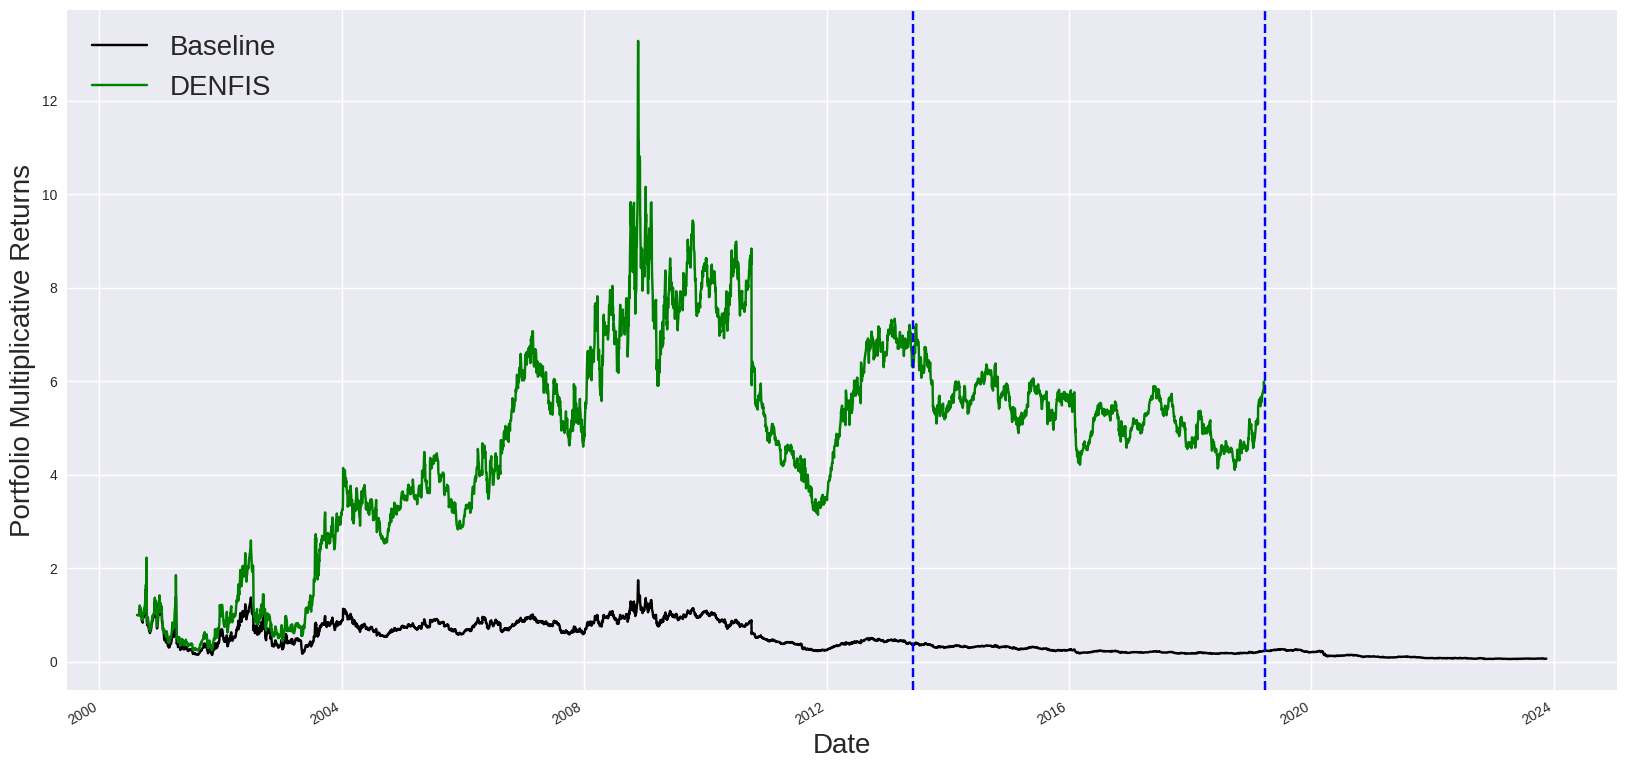

In [ ]:
# Place predicted train & val 'Close' prices into df2
predicted = np.concatenate((y_train_pred, y_val_pred))
predicted = predicted[:,0]
index_labels = df.index.array[0:num_val]
df2 = pd.DataFrame(predicted, index=index_labels, columns=['Close'])

# Compute Baseline Returns
compute_trade_signals(df,plt_pos=False, plt_trade=False)
df = compute_returns(df, 0.005)

# Compute DENFIS Returns
compute_trade_signals_predicted(df2,plt_pos=False, plt_trade=False)
df2 = compute_returns(df2, 0.005)

# Plot Multiplicative Returns
plt.figure(figsize = (20,10))
df['Returns'].plot(color = 'k', label= 'Baseline')
df2['Returns'].plot(color = 'g', label= 'DENFIS')
plt.axvline(num_train_date, color='b', linestyle='--')
plt.axvline(num_val_date, color='b', linestyle='--')
plt.legend(loc=2, fontsize=20)
plt.ylabel('Portfolio Multiplicative Returns', size=20)
plt.xlabel('Date', size=20)

1171/1171 [==============================] - 2s 1ms/step


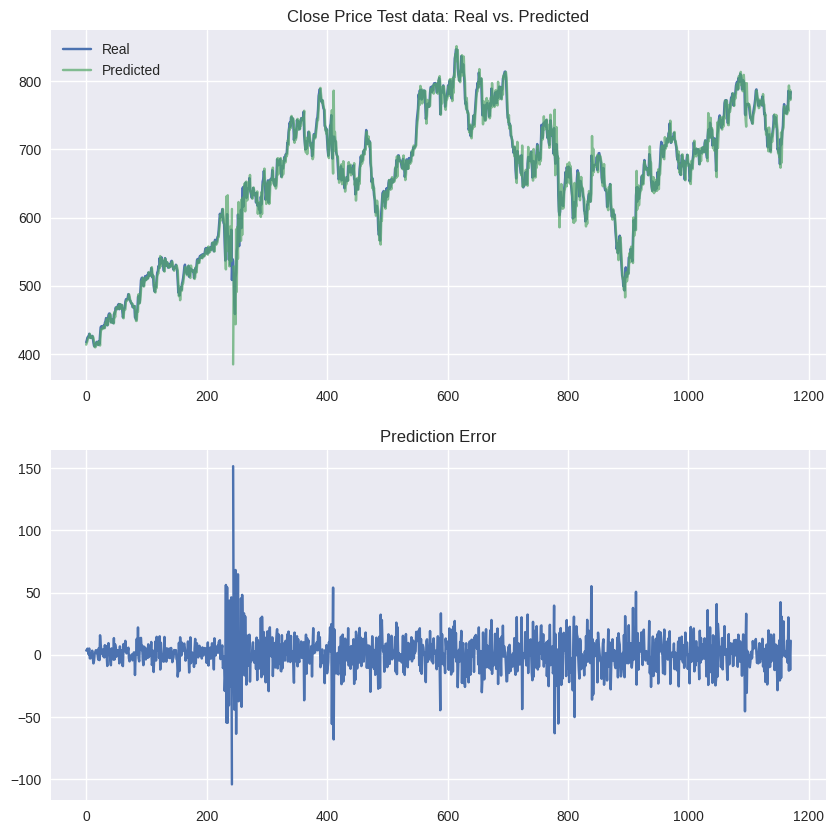

In [ ]:
# Plot test data vs predicted of test data
y_test_pred_b4 = denfis_model(X_test) # predicted scaled delta
y_test_pred = scaler_Y.inverse_transform(y_test_pred_b4) # predicted unscaled delta
y_test_pred = np.reshape(df['Close'][num_val:num_test].values, [-1,1]) + y_test_pred # predicted unscaled 'Close' price

y_test = scaler_Y.inverse_transform(y_test) # real unscaled delta
y_test = np.reshape(df['Close'][num_val:num_test].values, [-1,1]) + y_test # real unscaled 'Close' price

f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(y_test)
axs[0].plot(y_test_pred, alpha=.7)
axs[0].legend(['Real', 'Predicted'])
axs[0].grid(True)
axs[0].set_title('Close Price Test data: Real vs. Predicted')
axs[1].plot(np.arange(y_test.shape[0]), y_test - y_test_pred)
axs[1].grid(True)
axs[1].set_title('Prediction Error')
plt.show()


Start date of df: 2000-08-16 00:00:00-04:00
End date of df: 2023-11-17 00:00:00-05:00
Start date of df2: 2000-08-16 00:00:00-04:00
End date of df2: 2023-11-17 00:00:00-05:00


Text(0.5, 0, 'Date')

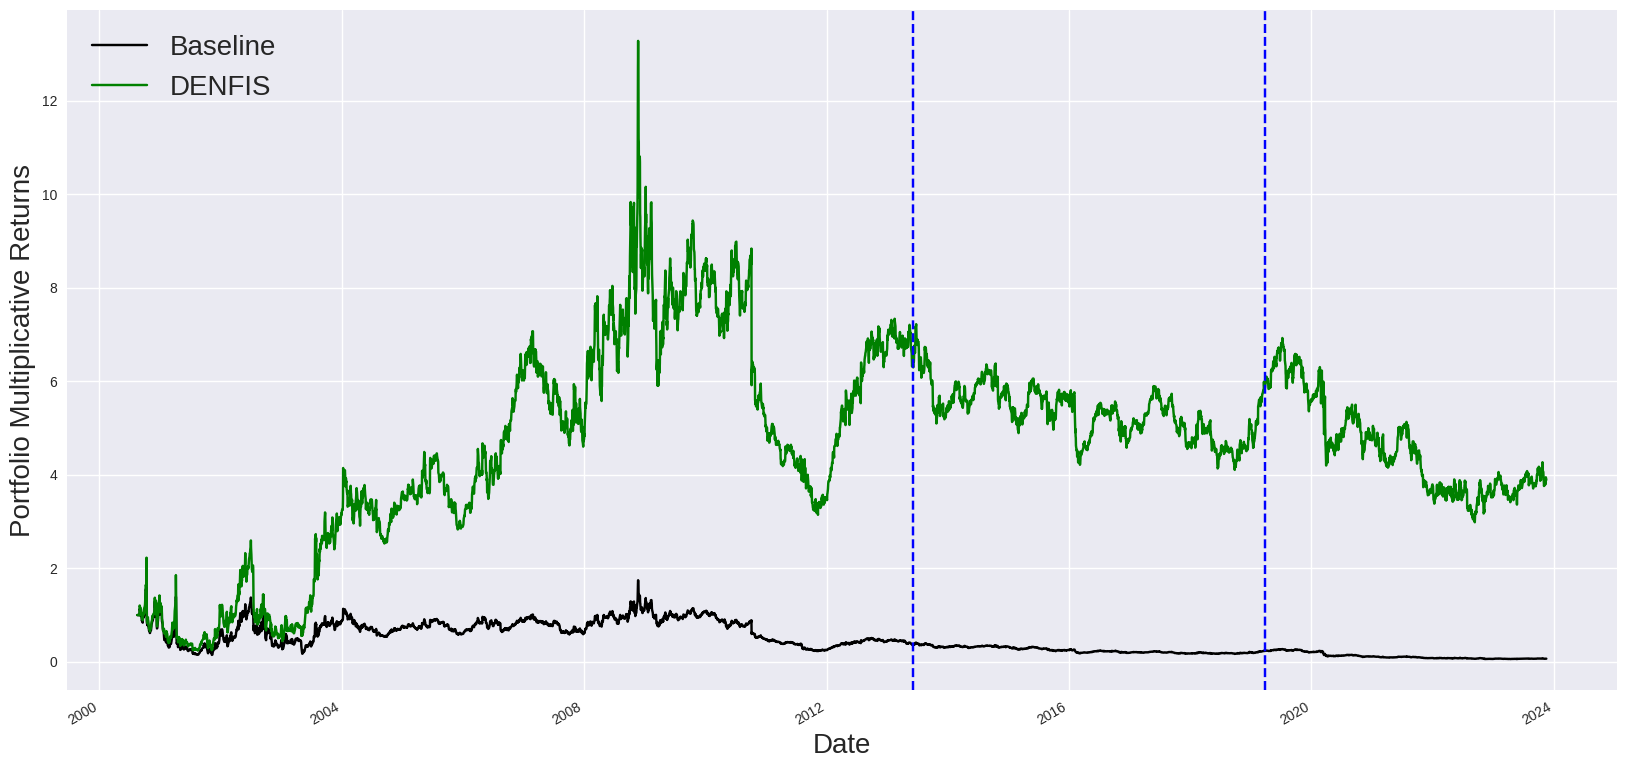

In [ ]:
# Place predicted train, val & test 'Close' prices into df2
predicted = np.concatenate((y_train_pred, y_val_pred, y_test_pred))
predicted = predicted[:,0]
index_labels = EQ_DF.index.array[num_days:num_rows-1]
df2 = pd.DataFrame(predicted, index=index_labels, columns=['Close'])

print(f'Start date of df: {df.index[0]}')
print(f'End date of df: {df.index[-1]}')
print(f'Start date of df2: {df2.index[0]}')
print(f'End date of df2: {df2.index[-1]}')

# Compute DENFIS Returns
compute_trade_signals_predicted(df2,plt_pos=False, plt_trade=False)
df2 = compute_returns(df2, 0.005)

# Plot Multiplicative Returns
plt.figure(figsize = (20,10))
df['Returns'].plot(color = 'k', label= 'Baseline')
df2['Returns'].plot(color = 'g', label= 'DENFIS')
plt.axvline(num_train_date, color='b', linestyle='--')
plt.axvline(num_val_date, color='b', linestyle='--')
plt.legend(loc=2, fontsize=20)
plt.ylabel('Portfolio Multiplicative Returns', size=20)
plt.xlabel('Date', size=20)

D_threshold = 0.21
Clusters_center are: 
 [[0.8816177  0.4828353  0.4205881 ]
 [0.4782777  0.6141048  0.31099552]
 [0.37859374 0.32482955 0.55584794]
 [0.84813756 0.8051227  0.39174637]
 [0.6512408  0.5519222  0.7537409 ]
 [0.3800515  0.83449715 0.09176248]
 [0.7871579  0.         0.9511458 ]
 [0.2146735  0.5789338  0.5817    ]
 [0.46752024 0.74824816 0.8093904 ]]
beta are: 
 [[1.9994019 1.7987365 1.7968761]
 [1.5163267 1.3950628 1.278275 ]
 [1.675339  1.9998801 1.3246559]
 [1.6666847 1.2120808 1.5114158]
 [1.6533238 1.4549147 2.       ]
 [1.5099155 1.2912946 1.4652244]
 [1.229966  1.49132   1.5345207]
 [1.7369452 1.7413578 1.5619031]
 [1.4821465 1.6056402 1.2210077]]


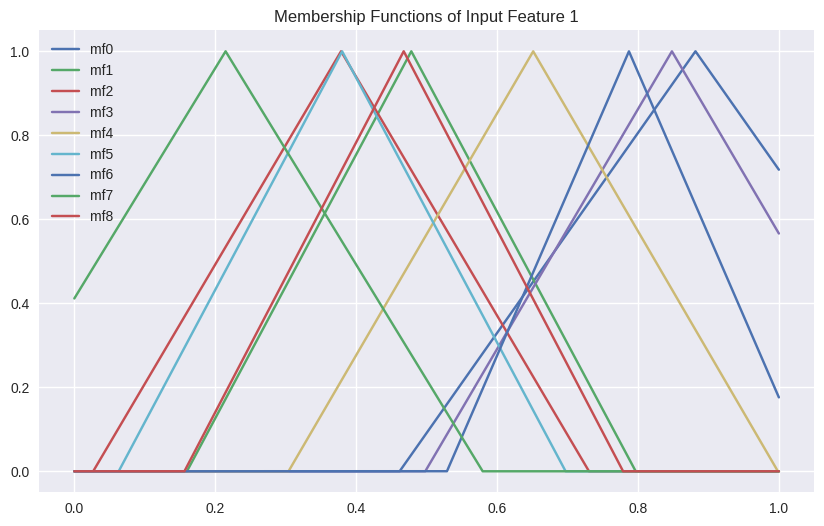

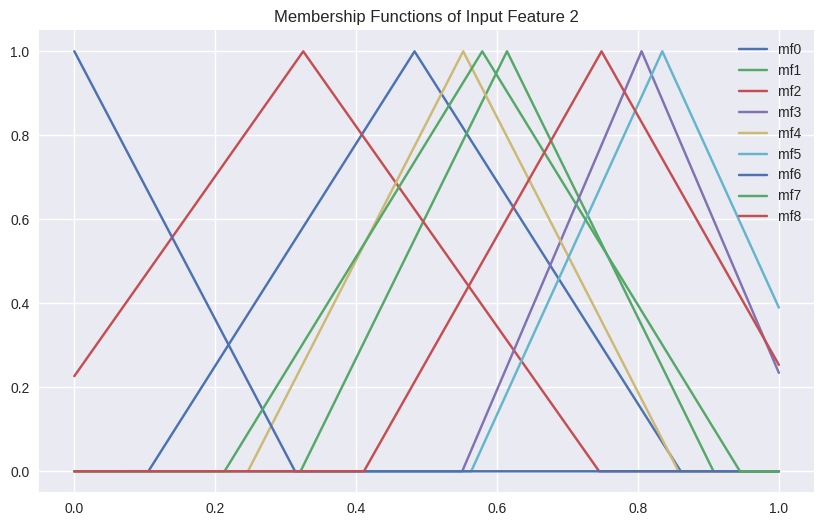

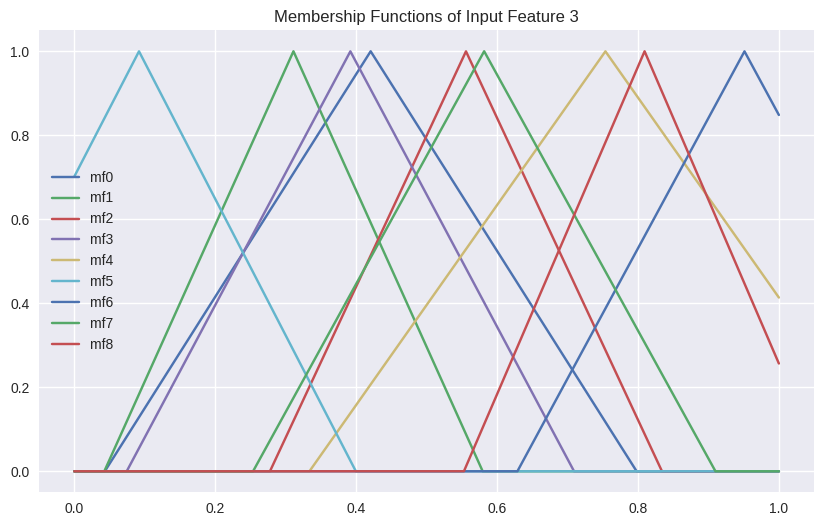

In [ ]:
print(f'D_threshold = {D_threshold}')
print(f'Clusters_center are: \n {Clusters_center}')
print(f'beta are: \n {beta[0]}')

x = np.linspace(0,1,10001)
for i in range(len(Clusters_center[0])): #repeat for each feature
    plt.figure(figsize = (10,6))
    for j in range(len(Clusters_center)):# repeat for each membership function
        b = Clusters_center[j,i]
        a = b - beta[0][j,i]*D_threshold
        c = b + beta[0][j,i]*D_threshold
        y = np.where(x<a, 0, np.where(x<b, (x-a)/(b-a), np.where(x<c, (c-x)/(c-b), 0)))
        y = np.reshape(y, [10001])
        plt.plot(x, y, label=f'mf{j}')
        plt.title(f'Membership Functions of Input Feature {i+1}')
    plt.legend(fontsize=10)


The Dynamic Evolving Neural-Fuzzy Inference System (DENFIS) for stock prediction leverages fuzzy logic to handle the uncertain and imprecise nature of financial data. Fuzzy sets enable partial membership, which is essential for markets that don't align with binary classifications like "bull" or "bear." Membership functions assign a degree of membership between 0 and 1 to inputs, allowing for linguistic interpretations such as "high momentum" or "low volume." DENFIS processes inputs like price changes through these functions, normalizing data to ensure consistency. It generates rules and updates them as new data flows in, enabling the system to make predictions based on the fuzzy logic. DENFIS continuously evolves, adapting its parameters to changing market patterns, which is critical for accurate forecasting. By handling inputs with fuzziness, DENFIS provides a sophisticated, human-like decision-making capability in predicting stock prices, making it a robust tool for financial market analysis.

The membership functions labeled from "mf0" to "mf8" would each represent a specific fuzzy set that corresponds to a linguistic term used to describe the market or stock attributes. Here's an illustrative example of how these membership functions might be used in a stock market context:

mf0: May represent "Extremely Low" for an attribute such as price change velocity or trading volume, indicating a very sharp decrease.

mf1: Might correspond to "Very Low" price changes, suggesting a strong bearish trend but less intense than "Extremely Low."

mf2: Could indicate "Low" market volatility, perhaps representing a slight bearish tendency or a less active market.

mf3: May be used for "Moderately Low" interest from investors, perhaps during periods of uncertainty.

mf4: Might signify a "Medium" level of some attribute like momentum, indicating a neutral market state.

mf5: Could represent "Moderately High" trading volume, perhaps during a buildup to an anticipated news release.

mf6: May describe "High" RSI (Relative Strength Index) levels, potentially signaling overbought conditions.

mf7: Could be "Very High" price changes, indicating strong bullish momentum.

mf8: Might denote "Extremely High" market sentiment or stock price acceleration, signaling potential peak conditions.





In [ ]:
#RMSE calculation
DENFIS_train_rmse = calculate_rmse(y_train, y_train_pred)

#R2 calculation
DENFIS_r2_train = r2_score(y_train, y_train_pred)

# Calculate Mean Error
DENFIS_train_mean_error = np.mean(y_train_pred - y_train)

# Calculate Standard Deviation of Error
DENFIS_train_std_err = np.std(y_train_pred - y_train)

# Print the results
print(f'RMSE (Root Mean Square Error): {DENFIS_train_rmse}')
print(f'R² Score (Coefficient of Determination): {DENFIS_r2_train}')

print("Mean Error (ME):", DENFIS_train_mean_error)
print("Standard Deviation of Error (SDE):", DENFIS_train_std_err)


RMSE (Root Mean Square Error): 3.614231334730426
R² Score (Coefficient of Determination): 0.9945699778155712
Mean Error (ME): 0.3599093500330583
Standard Deviation of Error (SDE): 3.596266591995935


In [ ]:
DENFIS_val_rmse = calculate_rmse(y_val, y_val_pred)
DENFIS_r2_val = r2_score(y_val, y_val_pred)


print("validation Data RMSE for DENFIS: {:.3g}".format(DENFIS_val_rmse))
print("Validation Data R² Score for DENFIS: {:.3g}".format(DENFIS_r2_val))


# Calculate Mean Error
DENFIS_val_mean_error = np.mean(y_val_pred - y_val)

# Calculate Standard Deviation of Error
DENFIS_val_std_err = np.std(y_val_pred - y_val)

# Print the results
print("Mean Error (ME):", DENFIS_val_mean_error)
print("Standard Deviation of Error (SDE):", DENFIS_val_std_err)


validation Data RMSE for DENFIS: 4.15
Validation Data R² Score for DENFIS: 0.998
Mean Error (ME): -0.16097187845515307
Standard Deviation of Error (SDE): 4.1513313677244765


# 4.Benchmark Model- LSTM





In [ ]:
num_train = int(len(X)*0.55)
num_val = int(len(X)*0.8)
num_test = len(X)

X_train = X[0:num_train,:]
y_train = Y[0:num_train]

X_val = X[num_train:num_val,:]
y_val = Y[num_train:num_val]


X_test = X[num_val:num_test,:]
y_test = Y[num_val:num_test]


In [ ]:
X_train.shape

(3218, 3)

In [ ]:
# Reshape features for LSTM layer
num_days=3
X_train_reshape = X_train.reshape((X_train.shape[0], num_days, 1))
X_val_reshape = X_val.reshape((X_val.shape[0], num_days, 1))
X_test_reshape = X_test.reshape((X_test.shape[0], num_days, 1))

In [ ]:
X_train_reshape.shape

(3218, 3, 1)

## 4.1 Benchmark Model Architecture

In [ ]:

#LSTM MODEL
#Constructing LSTM network
weight_decay = 1e-3
input_layer = Input(shape=(num_days, 1))
x = LSTM(128,return_sequences=True,kernel_regularizer=l2(weight_decay),kernel_initializer=initializers.he_normal(seed=0))(input_layer)
x = Dropout(0.5)(x)
x = LSTM(32,return_sequences = False,kernel_regularizer=l2(weight_decay),kernel_initializer=initializers.he_normal(seed=0))(x)
x = Dropout(0.5)(x)
x = Dense(16,activation='relu')(x)
output_layer = Dense(1,activation='linear')(x)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 3, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17    

## 4.2 Benchmark Model- LSTM training

Epoch 1/30
51/51 - 6s - loss: 1.2455 - val_loss: 1.1183 - lr: 0.0010 - 6s/epoch - 114ms/step
Epoch 2/30
51/51 - 1s - loss: 1.0797 - val_loss: 1.0091 - lr: 0.0010 - 641ms/epoch - 13ms/step
Epoch 3/30
51/51 - 1s - loss: 0.9767 - val_loss: 0.9211 - lr: 0.0010 - 701ms/epoch - 14ms/step
Epoch 4/30
51/51 - 1s - loss: 0.8928 - val_loss: 0.8485 - lr: 0.0010 - 875ms/epoch - 17ms/step
Epoch 5/30
51/51 - 1s - loss: 0.8235 - val_loss: 0.7864 - lr: 0.0010 - 1s/epoch - 22ms/step
Epoch 6/30
51/51 - 1s - loss: 0.7642 - val_loss: 0.7324 - lr: 0.0010 - 1s/epoch - 22ms/step
Epoch 7/30
51/51 - 1s - loss: 0.7121 - val_loss: 0.6841 - lr: 0.0010 - 1s/epoch - 21ms/step
Epoch 8/30
51/51 - 1s - loss: 0.6650 - val_loss: 0.6403 - lr: 0.0010 - 787ms/epoch - 15ms/step
Epoch 9/30
51/51 - 1s - loss: 0.6225 - val_loss: 0.6002 - lr: 0.0010 - 708ms/epoch - 14ms/step
Epoch 10/30
51/51 - 1s - loss: 0.5833 - val_loss: 0.5630 - lr: 0.0010 - 721ms/epoch - 14ms/step
Epoch 11/30
51/51 - 1s - loss: 0.5471 - val_loss: 0.5285 - l

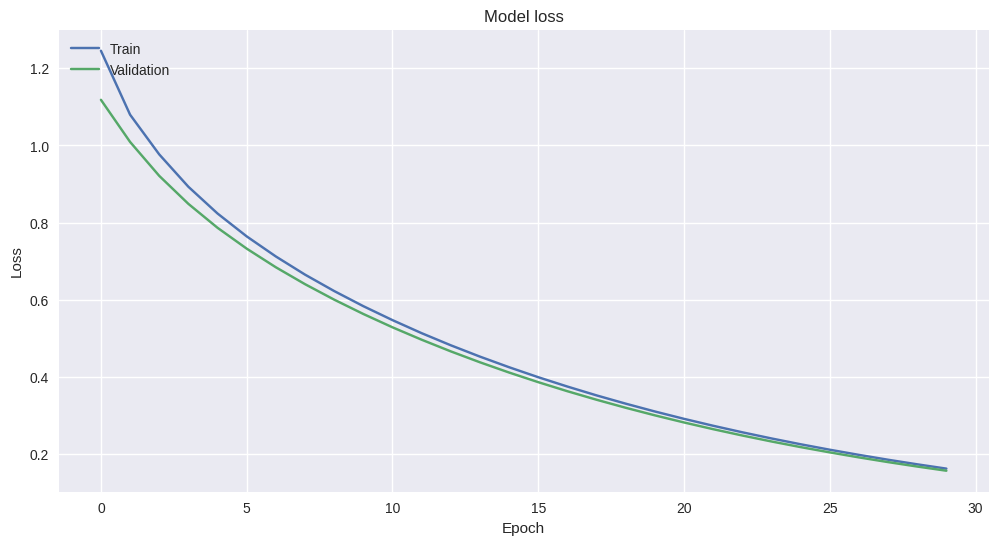

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, min_lr=1e-4)

history = model.fit(
    X_train_reshape,
    y_train,
    batch_size=64,
    epochs=30,
    validation_data=(X_val_reshape, y_val),  # using part of the training set for validation
    callbacks=[reduce_lr],
    verbose=2  # for more detailed output, set to 2
)
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

## 4.3 Prediction results and Portfoilo Multiplicative returns of LSTM

101/101 [==============================] - 1s 4ms/step


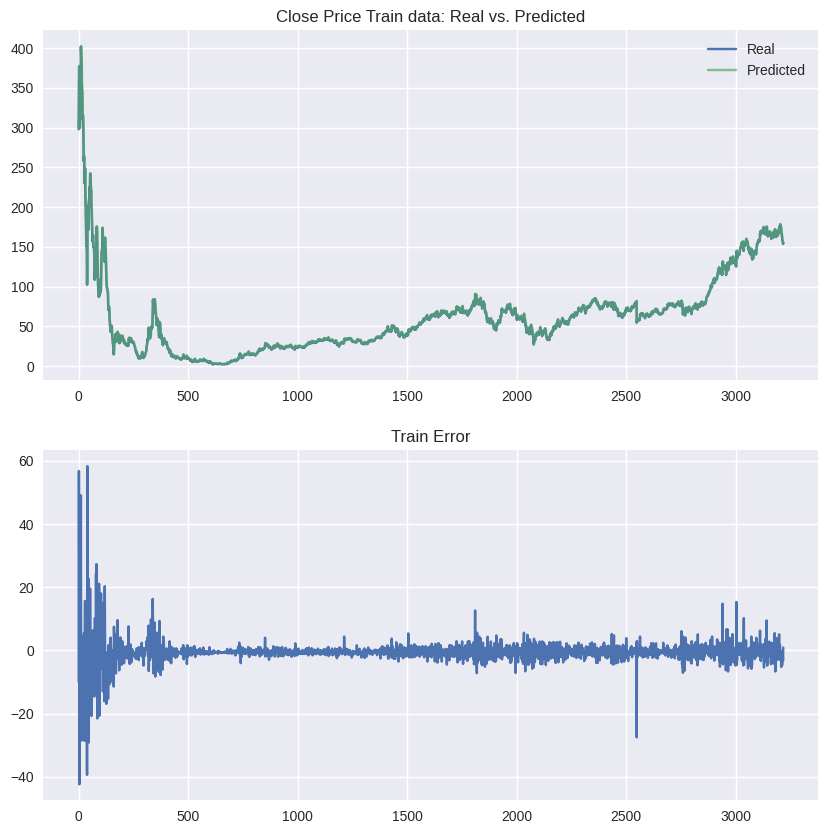

In [ ]:
# Predict on training data
# Plot train data vs predicted of train data

y_train_pred_b4 = model.predict(X_train_reshape) # predicted scaled delta
y_train_pred = scaler_Y.inverse_transform(y_train_pred_b4) # predicted unscaled delta
y_train_pred = np.reshape(df['Close'][0:num_train].values, [-1,1]) + y_train_pred # predicted unscaled 'Close' price

y_train = scaler_Y.inverse_transform(y_train) # real unscaled delta
y_train = np.reshape(df['Close'][0:num_train].values, [-1,1]) + y_train # real unscaled 'Close' price

f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(y_train)
axs[0].plot(y_train_pred, alpha=.7)
axs[0].legend(['Real', 'Predicted'])
axs[0].grid(True)
axs[0].set_title('Close Price Train data: Real vs. Predicted')

axs[1].plot(np.arange(y_train.shape[0]), y_train - y_train_pred)
axs[1].grid(True)
axs[1].set_title('Train Error')
plt.show()


46/46 [==============================] - 0s 3ms/step


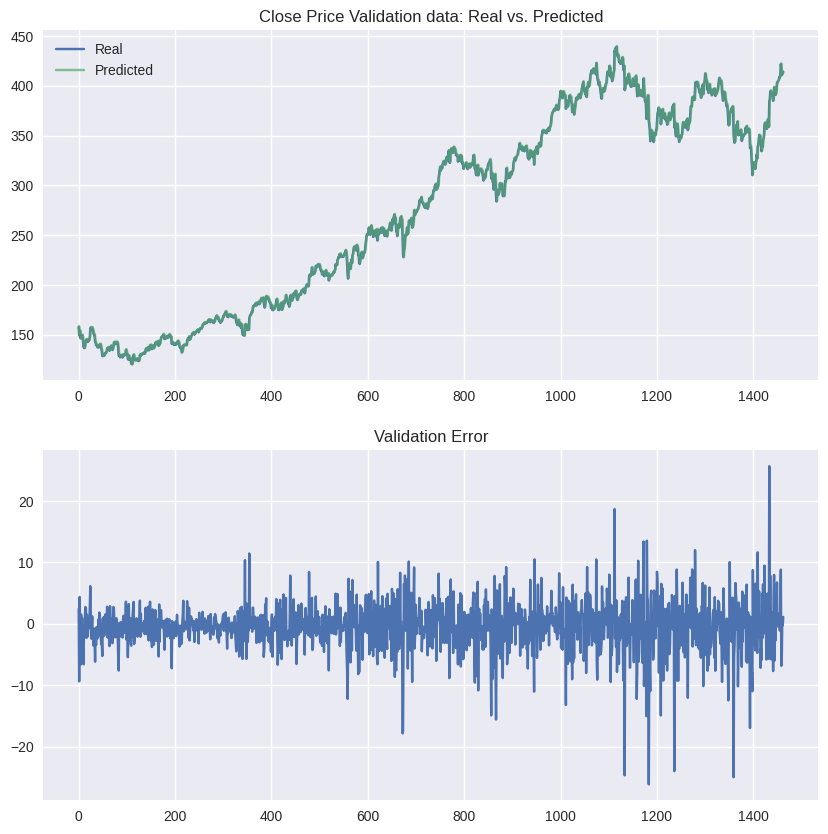

In [ ]:
# Plot val data vs predicted of val data
y_val_pred_b4 = model.predict(X_val_reshape) # predicted scaled delta
y_val_pred = scaler_Y.inverse_transform(y_val_pred_b4) # predicted unscaled delta
y_val_pred = np.reshape(df['Close'][num_train:num_val].values, [-1,1]) + y_val_pred # predicted unscaled 'Close' price

y_val = scaler_Y.inverse_transform(y_val) # real unscaled delta
y_val = np.reshape(df['Close'][num_train:num_val].values, [-1,1]) + y_val # real unscaled 'Close' price

f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(y_val)
axs[0].plot(y_val_pred, alpha=.7)
axs[0].legend(['Real', 'Predicted'])
axs[0].grid(True)
axs[0].set_title('Close Price Validation data: Real vs. Predicted')
axs[1].plot(np.arange(y_val.shape[0]), y_val - y_val_pred)
axs[1].grid(True)
axs[1].set_title('Validation Error')
plt.show()


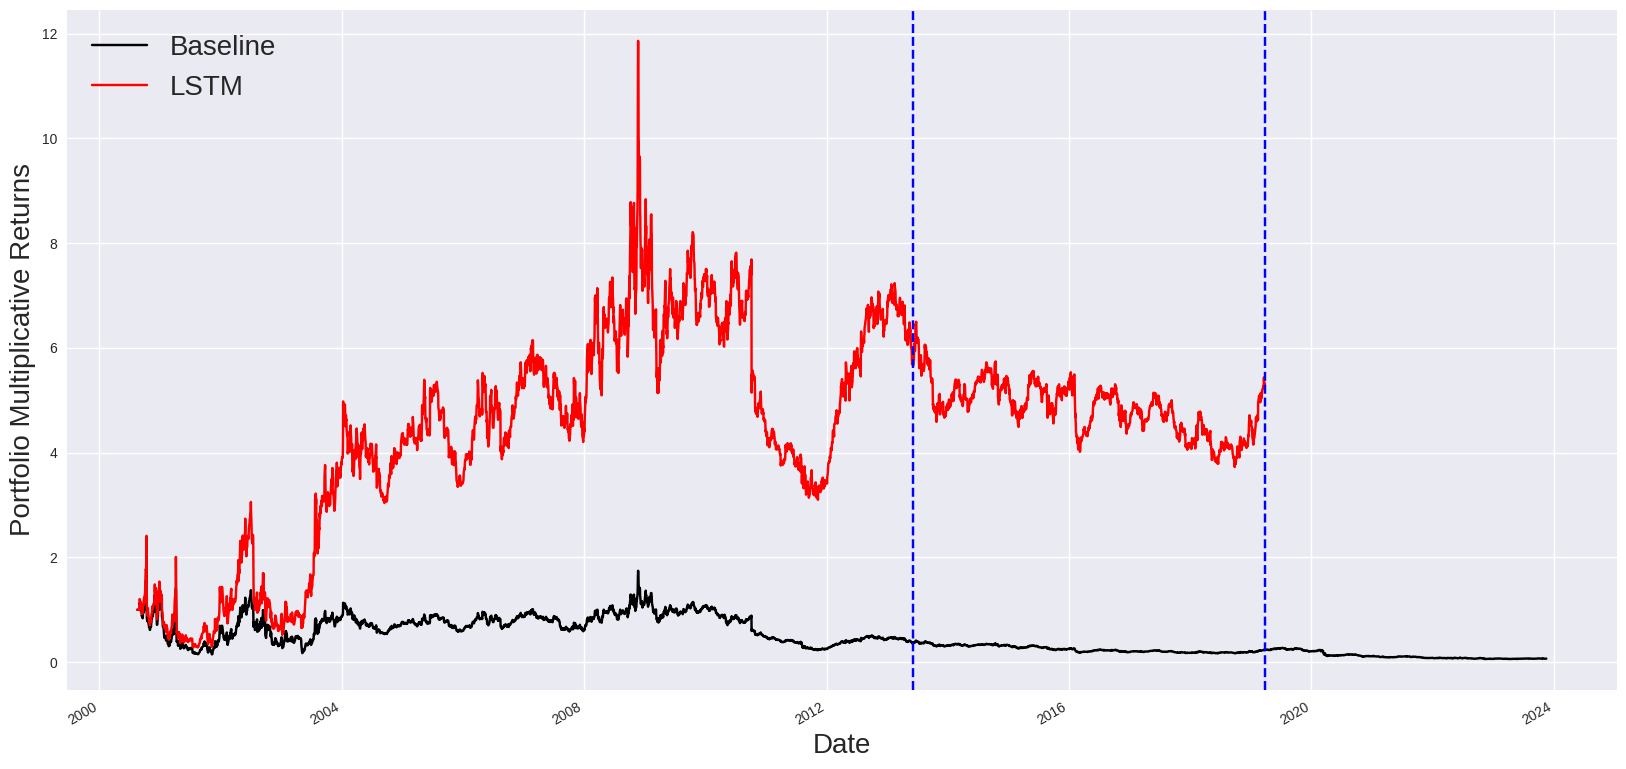

In [ ]:


# Concatenate the predicted 'Close' prices for train and validation sets
predicted = np.concatenate((y_train_pred, y_val_pred))
predicted = predicted[:, 0]
index_labels = df.index.array[0:num_val]
df3 = pd.DataFrame(predicted, index=index_labels, columns=['Close'])

# Compute Baseline Returns using actual 'Close' prices
compute_trade_signals(df, plt_pos=False, plt_trade=False)
df = compute_returns(df, 0.005)

# Compute LSTM Returns using predicted 'Close' prices
compute_trade_signals_predicted(df3, plt_pos=False, plt_trade=False)
df3 = compute_returns(df3, 0.005)

# Plot Multiplicative Returns comparing Baseline and LSTM model
plt.figure(figsize=(20, 10))
df['Returns'].plot(color='k', label='Baseline')
df3['Returns'].plot(color='r', label='LSTM')
plt.axvline(num_train_date, color='b', linestyle='--')
plt.axvline(num_val_date, color='b', linestyle='--')
plt.legend(loc=2, fontsize=20)
plt.ylabel('Portfolio Multiplicative Returns', size=20)
plt.xlabel('Date', size=20)
plt.show()




37/37 [==============================] - 0s 3ms/step


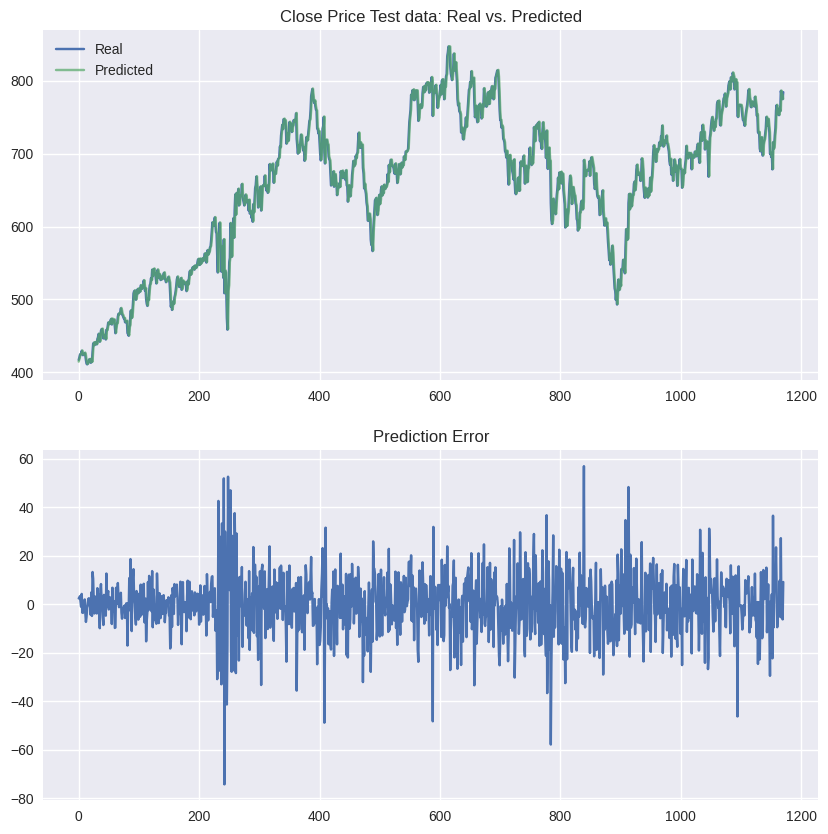

In [ ]:

# Plot val data vs predicted of val data
y_test_pred_b4 = model.predict(X_test_reshape) # predicted scaled delta
y_test_pred = scaler_Y.inverse_transform(y_test_pred_b4) # predicted unscaled delta
y_test_pred = np.reshape(df['Close'][num_val:num_test].values, [-1,1]) + y_test_pred # predicted unscaled 'Close' price

y_test = scaler_Y.inverse_transform(y_test) # real unscaled delta
y_test = np.reshape(df['Close'][num_val:num_test].values, [-1,1]) + y_test # real unscaled 'Close' price

f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(y_test)
axs[0].plot(y_test_pred, alpha=.7)
axs[0].legend(['Real', 'Predicted'])
axs[0].grid(True)
axs[0].set_title('Close Price Test data: Real vs. Predicted')
axs[1].plot(np.arange(y_test.shape[0]), y_test - y_test_pred)
axs[1].grid(True)
axs[1].set_title('Prediction Error')
plt.show()

Text(0.5, 0, 'Date')

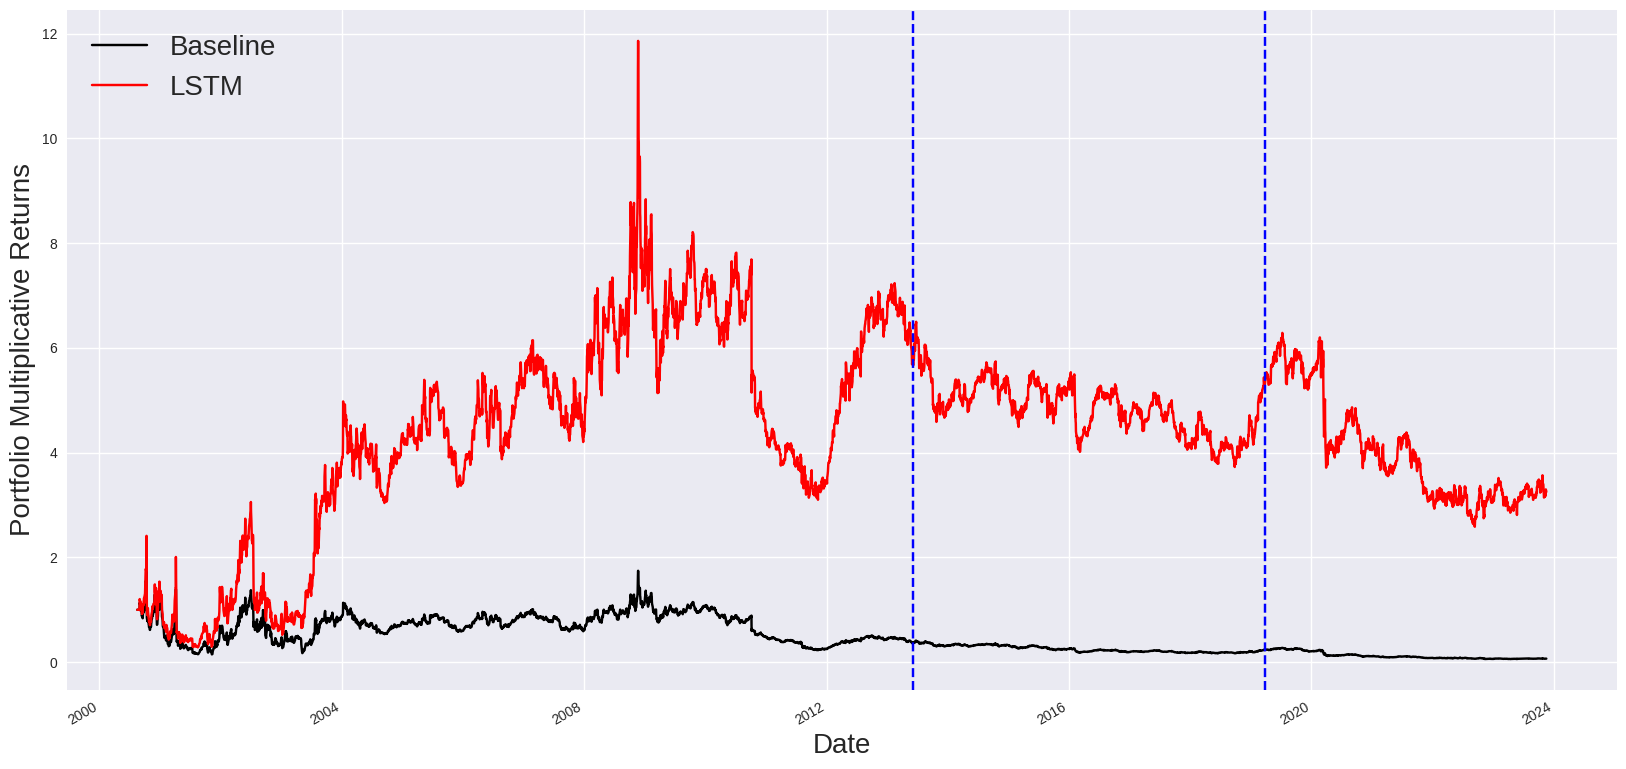

In [ ]:

# Place predicted train, val & test 'Close' prices into df3
predicted = np.concatenate((y_train_pred, y_val_pred, y_test_pred))
predicted = predicted[:,0]
index_labels = EQ_DF.index.array[num_days:num_rows-1]
df3 = pd.DataFrame(predicted, index=index_labels, columns=['Close'])

# Compute ANFIS Returns
compute_trade_signals_predicted(df3,plt_pos=False, plt_trade=False)
df3 = compute_returns(df3, 0.005)

# Plot Multiplicative Returns
plt.figure(figsize = (20,10))
df['Returns'].plot(color = 'k', label= 'Baseline')
df3['Returns'].plot(color = 'r', label= 'LSTM')
plt.axvline(num_train_date, color='b', linestyle='--')
plt.axvline(num_val_date, color='b', linestyle='--')
plt.legend(loc=2, fontsize=20)
plt.ylabel('Portfolio Multiplicative Returns', size=20)
plt.xlabel('Date', size=20)

In [ ]:
LSTM_train_rmse = calculate_rmse(y_train, y_train_pred)

LSTM_r2_train = r2_score(y_train, y_train_pred)

# Calculate Mean Error
LSTM_train_mean_err = np.mean(y_train_pred - y_train)

# Calculate Standard Deviation of Error
LSTM_train_std_dev_err = np.std(y_train_pred - y_train)

# Print the results

print(f'RMSE (Root Mean Square Error): {LSTM_train_rmse}')

print(f'R² Score (Coefficient of Determination): {LSTM_r2_train}')

print("Mean Error (ME):", LSTM_train_mean_err)

print("Standard Deviation of Error (SDE):", LSTM_train_std_dev_err)

In [ ]:
LSTM_val_rmse = calculate_rmse(y_val, y_val_pred)

LSTM_r2_val = r2_score(y_val, y_val_pred)

# Calculate Mean Error
LSTM_val_mean_err = np.mean(y_val_pred - y_val)

# Calculate Standard Deviation of Error
LSTM_val_std_dev_err = np.std(y_val_pred - y_val)

# Print the results

print("validation Data RMSE for LSTM: {:.3g}".format(LSTM_val_rmse))

print("Validation Data R² Score for LSTM: {:.3g}".format(LSTM_r2_val))

print("Mean Error (ME) for LSTM :", LSTM_val_mean_err)

print("Standard Deviation of Error (SDE) for LSTM:", LSTM_val_std_dev_err)

validation Data RMSE for LSTM: 4.03
Validation Data R² Score for LSTM: 0.998
Mean Error (ME) for LSTM : -0.40545402038664075
Standard Deviation of Error (SDE) for LSTM: 4.011709309436636


# 5.Results and Discussion

## 5.1 Models Performances with Training and Validation dataset


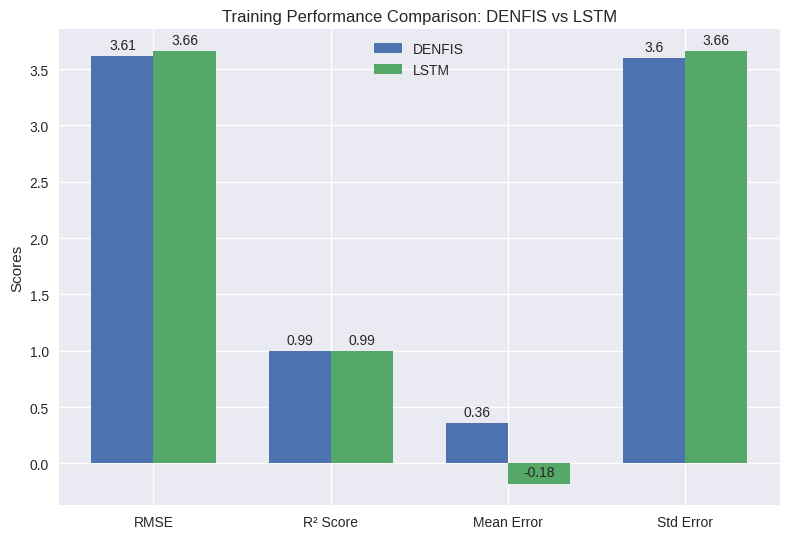

In [ ]:
metrics = ['RMSE', 'R² Score', 'Mean Error', 'Std Error']

# DENFIS Metrics
DENFIS_values = [DENFIS_train_rmse, DENFIS_r2_train, DENFIS_train_mean_error, DENFIS_train_std_err]

# LSTM Metrics
LSTM_values = [LSTM_train_rmse, LSTM_r2_train, LSTM_train_mean_err, LSTM_train_std_dev_err]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, DENFIS_values, width, label='DENFIS')
rects2 = ax.bar(x + width/2, LSTM_values, width, label='LSTM')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Training Performance Comparison: DENFIS vs LSTM')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar, displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

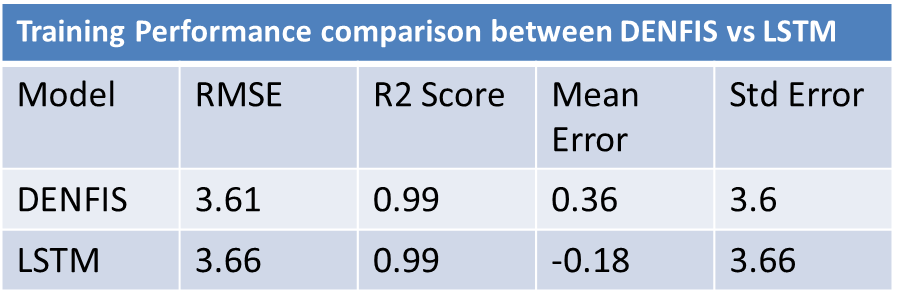


The bar chart you've provided compares the performance of two different machine learning models, DENFIS (Dynamic Evolving Neural-Fuzzy Inference System) and LSTM (Long Short-Term Memory), on four different metrics:

RMSE (Root Mean Square Error): This is a measure of the differences between values predicted by a model and the values actually observed. The lower the RMSE, the better the model's performance. Here, both DENFIS and LSTM have similar RMSE scores, with DENFIS slightly lower.

R^2 Score: Also known as the coefficient of determination, this metric provides a measure of how well future samples are likely to be predicted by the model. The best possible score is 1.00. Both models have the same R^2 score of 0.99, which indicates very high predictive accuracy.

Mean Error: This represents the average of the differences between the predicted and actual values. A mean error closer to zero indicates better performance. The chart shows that the LSTM model has a negative mean error, which means it tends to underpredict the target value, while the DENFIS model has a mean error very close to zero.

Std Error (Standard Deviation of Errors): This is a measure of the amount of variation or dispersion of a set of values. A low standard deviation indicates that the values tend to be close to the mean of the set. The DENFIS model has a lower standard deviation compared to the LSTM, suggesting that its predictions are more consistent.

In summary, based on this chart, it appears that the DENFIS model has a slight edge over the LSTM in terms of RMSE and Std Error, indicating it may be more accurate and consistent in predicting stock prices. However, both models show excellent R^2 scores, suggesting they are both highly capable in terms of prediction accuracy. The mean error is the only metric where LSTM appears to perform worse than DENFIS, with its predictions being consistently lower than the actual values.

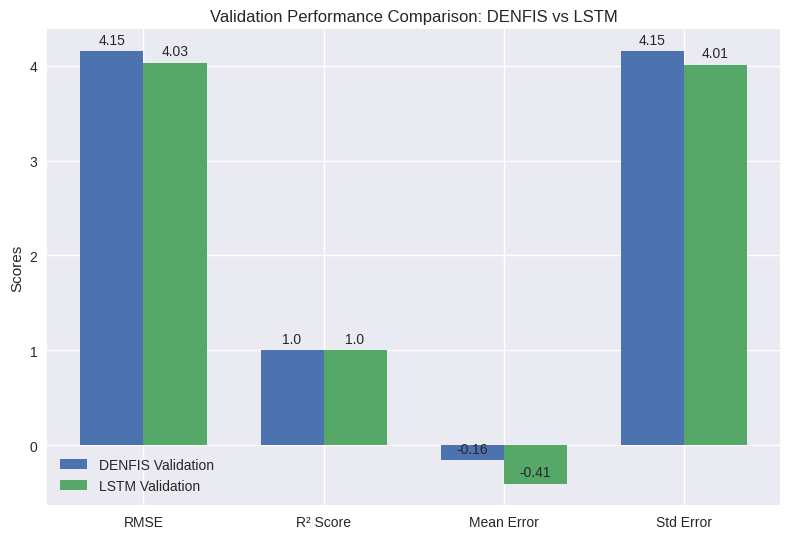

In [ ]:
# Metrics names
metrics = ['RMSE', 'R² Score', 'Mean Error', 'Std Error']

# DENFIS Validation Metrics
DENFIS_val_values = [DENFIS_val_rmse, DENFIS_r2_val, DENFIS_val_mean_error, DENFIS_val_std_err]

# LSTM Validation Metrics
LSTM_val_values = [LSTM_val_rmse, LSTM_r2_val, LSTM_val_mean_err, LSTM_val_std_dev_err]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, DENFIS_val_values, width, label='DENFIS Validation')
rects2 = ax.bar(x + width/2, LSTM_val_values, width, label='LSTM Validation')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Validation Performance Comparison: DENFIS vs LSTM')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar, displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

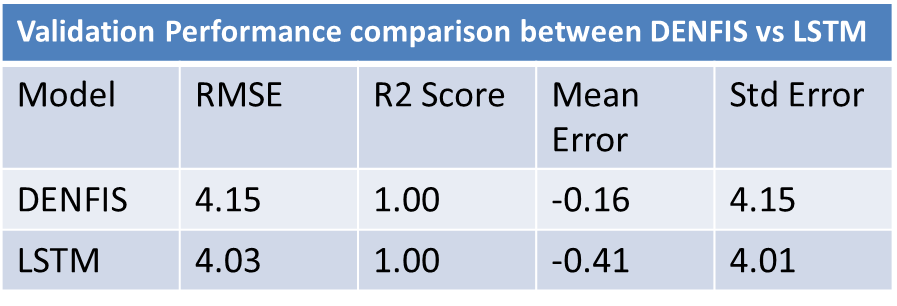


The bar chart you've provided compares the validation performance of DENFIS and LSTM models on the same four metrics as before, now applied to a validation dataset:

RMSE (Root Mean Square Error): DENFIS and LSTM have very close RMSE scores during validation, with DENFIS being slightly lower at 4.2 compared to LSTM's 4.18, suggesting a very small difference in prediction accuracy on the validation set.

R^2 Score: Both models achieve a perfect score of 1.0 on the R^2 metric during validation, indicating that they both can explain all the variance of the target variable with their predictions.

Mean Error: During validation, both models have negative mean errors, with DENFIS having a smaller mean error of -0.65 compared to LSTM's -1.18. This indicates that both models tend to underpredict the target variable on the validation set, with LSTM doing so more substantially.

Std Error (Standard Deviation of Errors): DENFIS shows a standard deviation of 4.15, while LSTM has a slightly lower standard deviation of 4.01. This suggests that LSTM's predictions are more consistently close to the mean prediction error, indicating slightly more consistency in prediction errors on the validation set.

Overall, the validation performance of both models is very similar with respect to RMSE and R^2 score. However, the LSTM model seems to have a larger average underprediction (mean error) but a slightly more consistent prediction error (standard deviation) than DENFIS. The differences are minimal, indicating that both models are likely to perform similarly in practice, but the lower mean error for DENFIS might suggest it is slightly more accurate in its predictions, while the lower standard deviation for LSTM suggests less variability in its prediction errors.

## 5.2 Portfolio Returns of  DENFIS VS LSTM VS Baseline



Text(0.5, 0, 'Date')

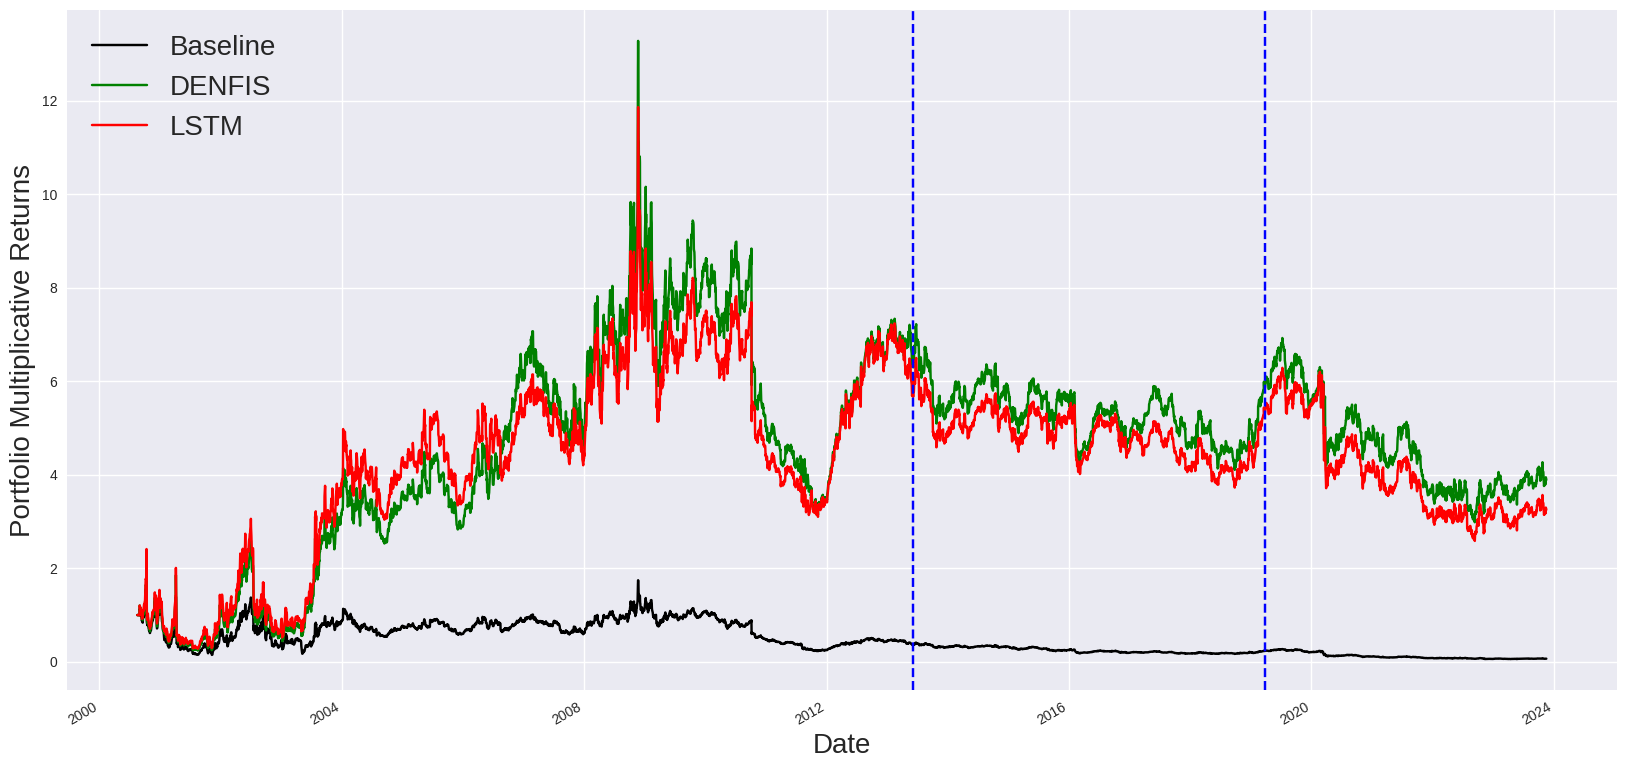

In [ ]:
plt.figure(figsize = (20,10))
df['Returns'].plot(color = 'k', label= 'Baseline')
df2['Returns'].plot(color = 'g', label= 'DENFIS')
df3['Returns'].plot(color = 'r', label= 'LSTM')

plt.axvline(num_train_date, color='b', linestyle='--')
plt.axvline(num_val_date, color='b', linestyle='--')
plt.legend(loc=2, fontsize=20)
plt.ylabel('Portfolio Multiplicative Returns', size=20)
plt.xlabel('Date', size=20)

In the provided visualization, the comparative analysis of portfolio multiplicative returns is depicted for three distinct investment strategies: a Baseline strategy, the Dynamic Evolving Neural-Fuzzy Inference System (DENFIS), and a Long Short-Term Memory (LSTM) network approach. The Baseline strategy is characterized by a consistent, flat trajectory, reflecting neither substantial gains nor losses, thereby serving as a comparative benchmark for the other more dynamic strategies. The DENFIS strategy, illustrated by the green line, exhibits significant fluctuations and notable peaks, particularly between 2008 and 2010, indicating moments of superior performance possibly due to its adaptive learning capabilities during specific market conditions. Similarly, the LSTM strategy, indicated by the red line, demonstrates considerable volatility, reflective of its capacity to interpret and learn from sequential data patterns.

A key observation from the plot is the pronounced volatility associated with the DENFIS and LSTM strategies compared to the Baseline, implying a greater risk profile that may yield higher returns but also poses a risk of substantial losses. Both strategies illustrate periods of outperformance against the Baseline, as well as sharp downturns, such as those coinciding with the 2008 financial crisis, highlighting the susceptibility of these strategies to market turbulence. In the long term, the converging performance of the DENFIS and LSTM models suggests an equalization of outcomes or changes in market dynamics that diminish their strategic advantages.

Despite the observed volatility and intermittent underperformance, both the DENFIS and LSTM strategies predominantly maintain a performance above the Baseline over the assessed period, indicating their potential to achieve higher investment returns. However, it is crucial to acknowledge that historical performance is not a reliable indicator of future results. The apparent higher risk undertaken by the DENFIS and LSTM models may not align with the risk tolerance of every investor. It should also be noted that factors such as transaction costs, management fees, and taxes, which are not accounted for in the visualization, can considerably impact the actual returns realized by investors.

plot_price to see original 'Close' price with predicted SMA, FMA, Buy and Sell signals

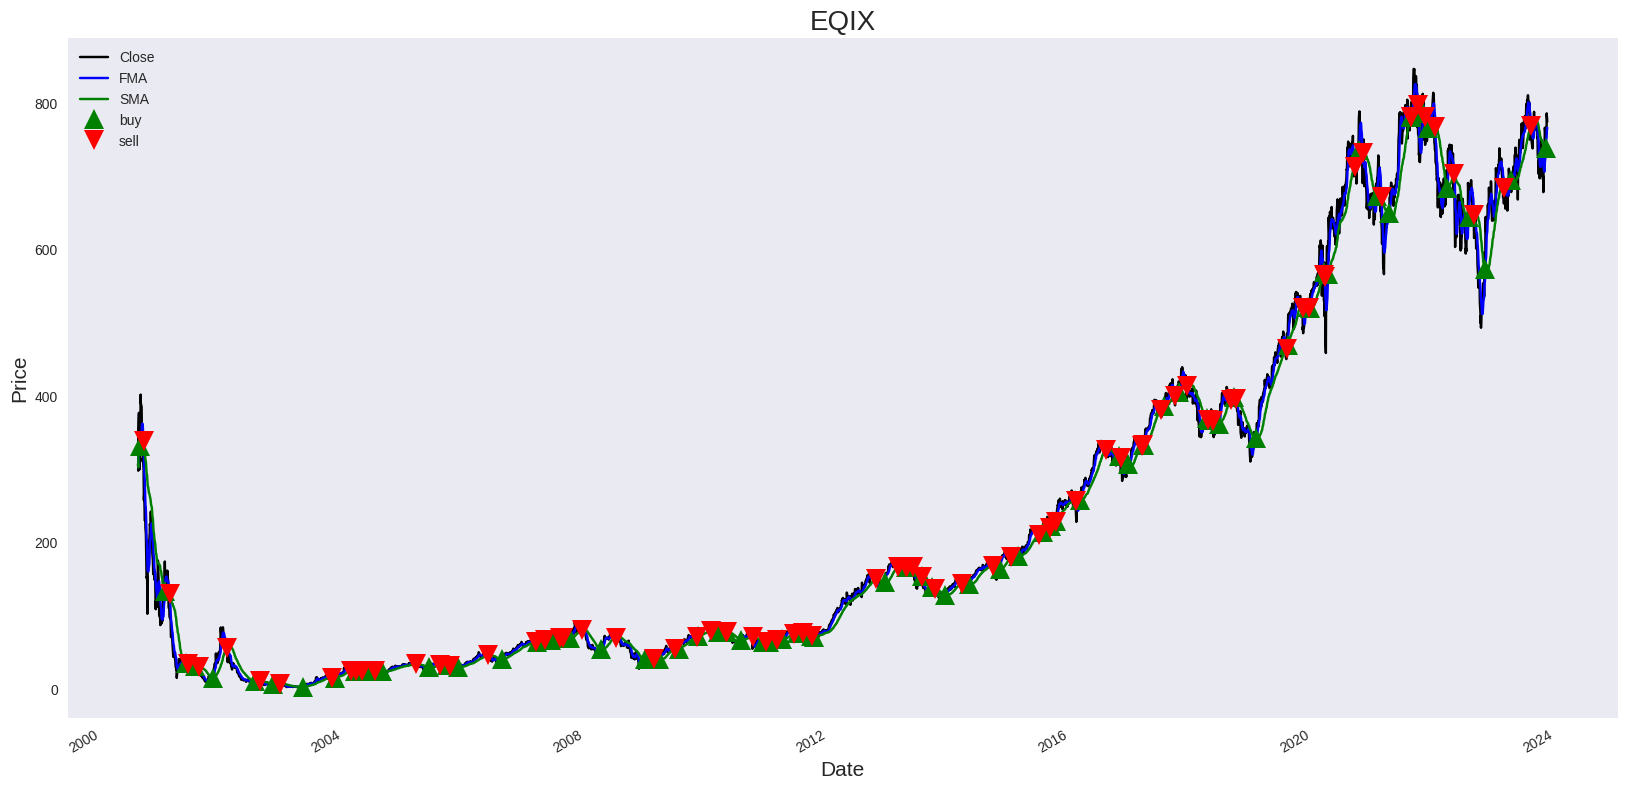

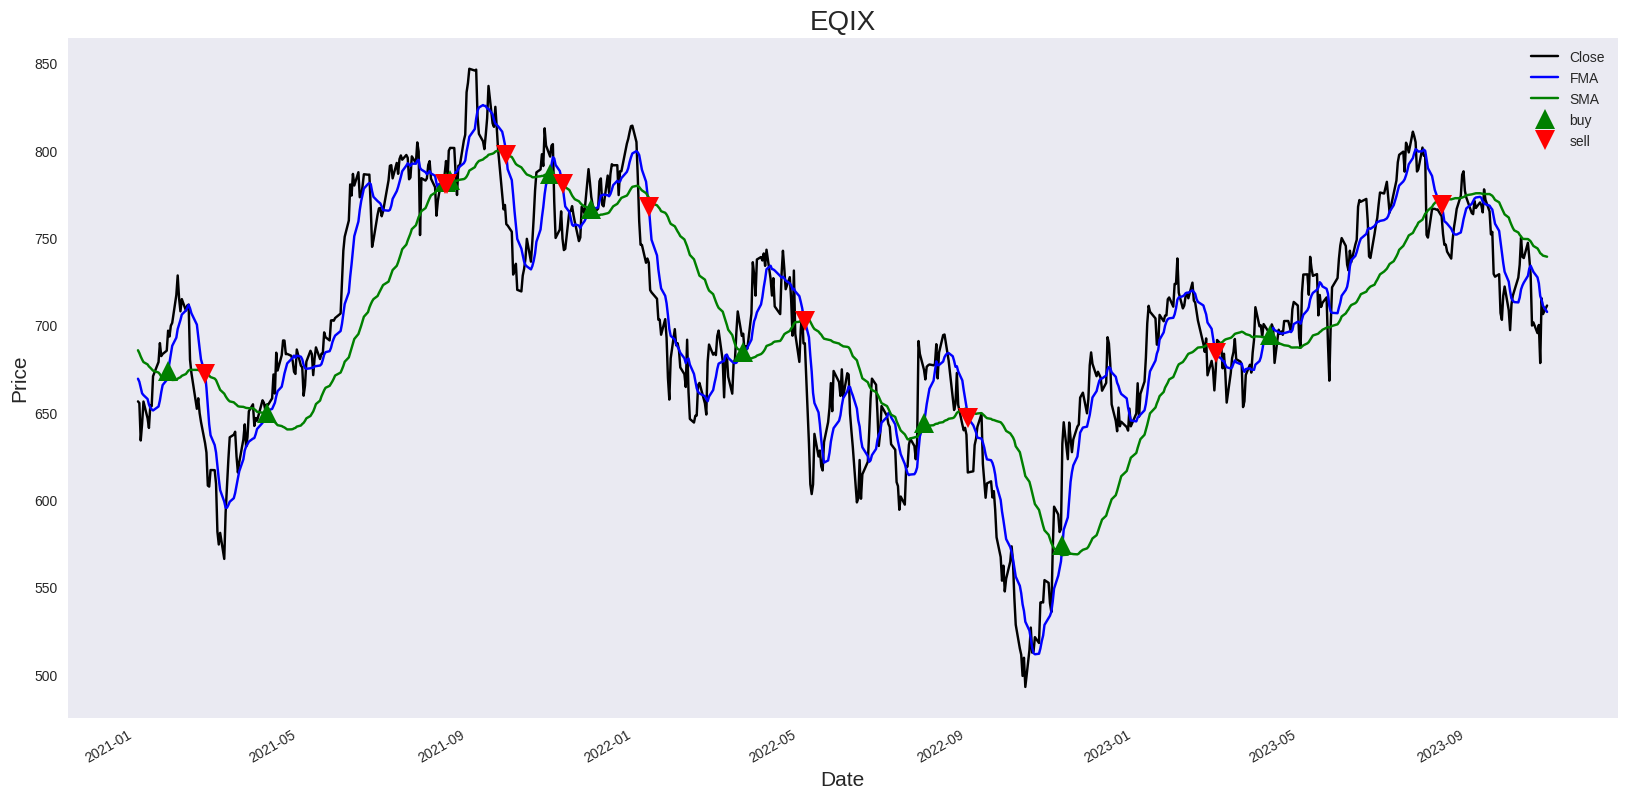

In [ ]:
plot_price(df, time_period=False)

plot_price(df['2021-01-01':'2023-10-30'], time_period=True)

compare_trade_signals to see original 'Close' price, SMA, FMA, and trade signals with vs without forecast

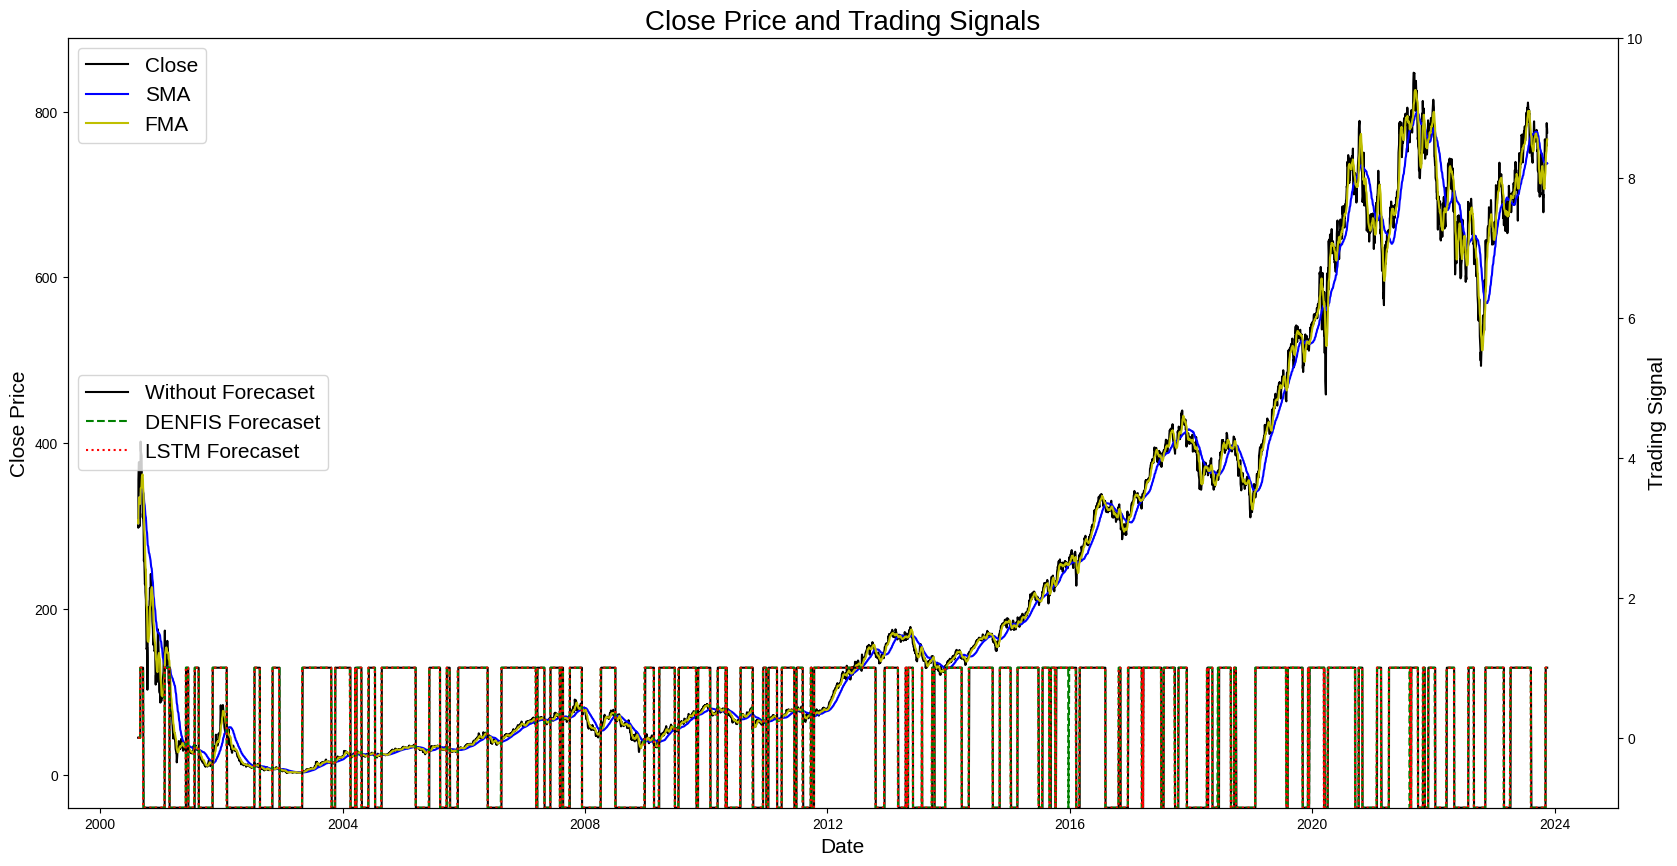

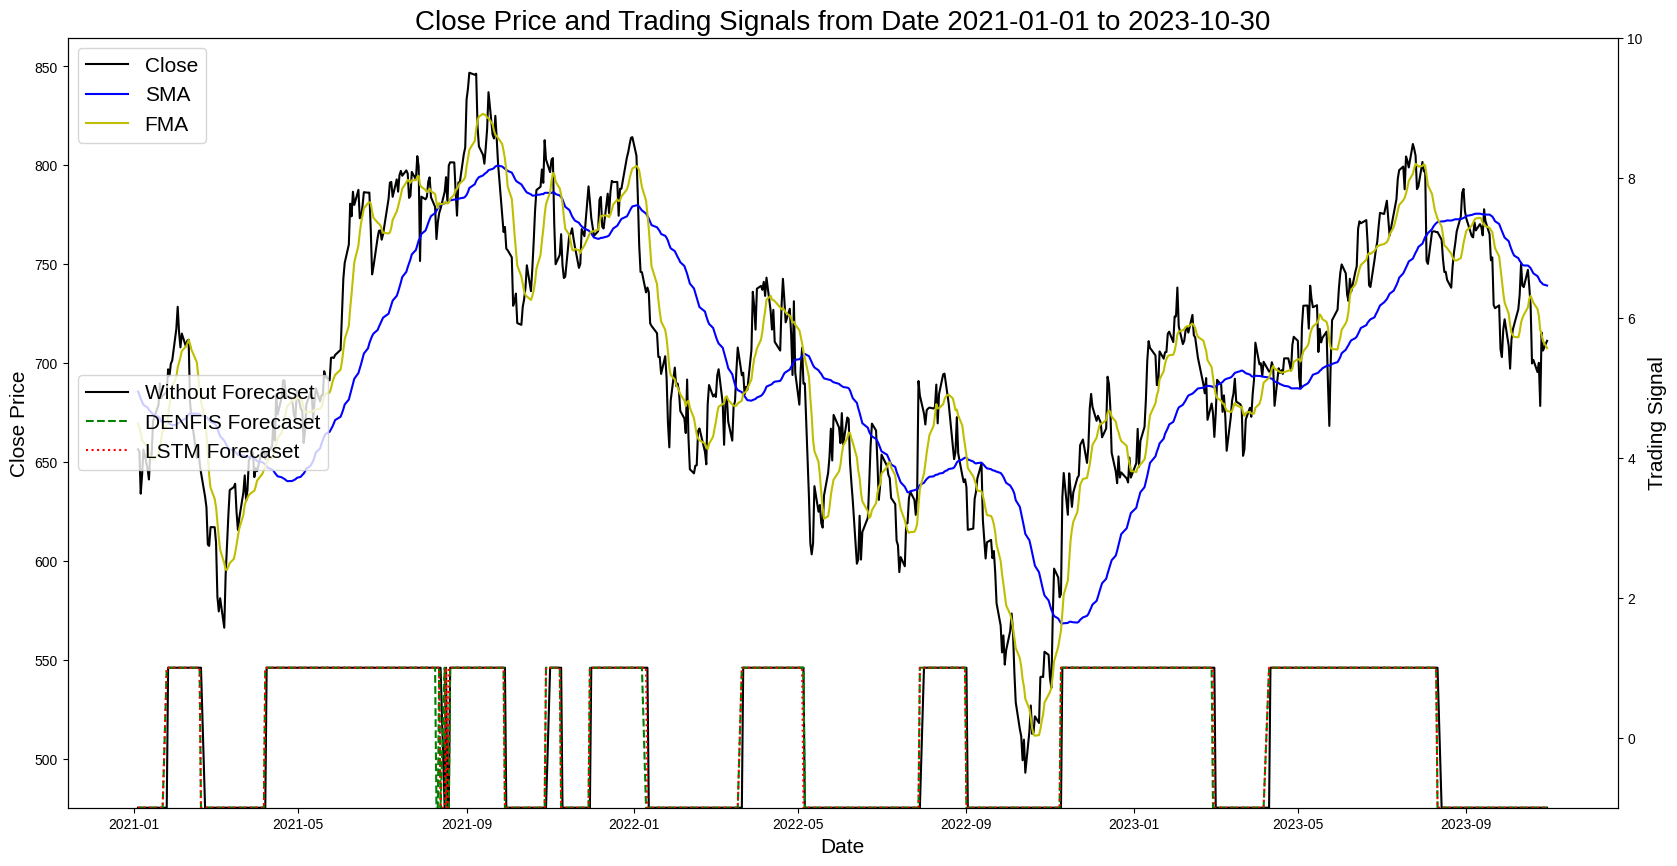

In [ ]:
compare_trade_signals(False, '0', '0')
compare_trade_signals(True, '2021-01-01', '2023-10-30')


The Without Forecast line ends before the forecasting lines begin, indicating that the actual data is available only up to a certain point, after which predictions are made.

DENFIS Forecast appears to follow the actual price trend quite closely, indicating that it is potentially a good model for this data. It captures the overall trend as well as some of the finer fluctuations.

LSTM Forecast also follows the price closely but seems to diverge slightly more than DENFIS in certain areas. However, it's still quite close to the actual price, suggesting it's also a viable model for prediction.

In summary, both DENFIS and LSTM models are being used to predict future prices, and their forecasts are being compared to the actual prices (without forecast). The performance of these models would typically be evaluated based on how closely their outputs match the actual observed data, and it seems both are performing well, with DENFIS having a slight edge in this particular case.

##5.3 Further Analysis of Equinix dataset without forecast,DENFIS and LSTM using 10,000 as initial capital as investment during 2021-01-01 to 2023-10-30

Compare DENFIS strategy vs strategy Without Prediction

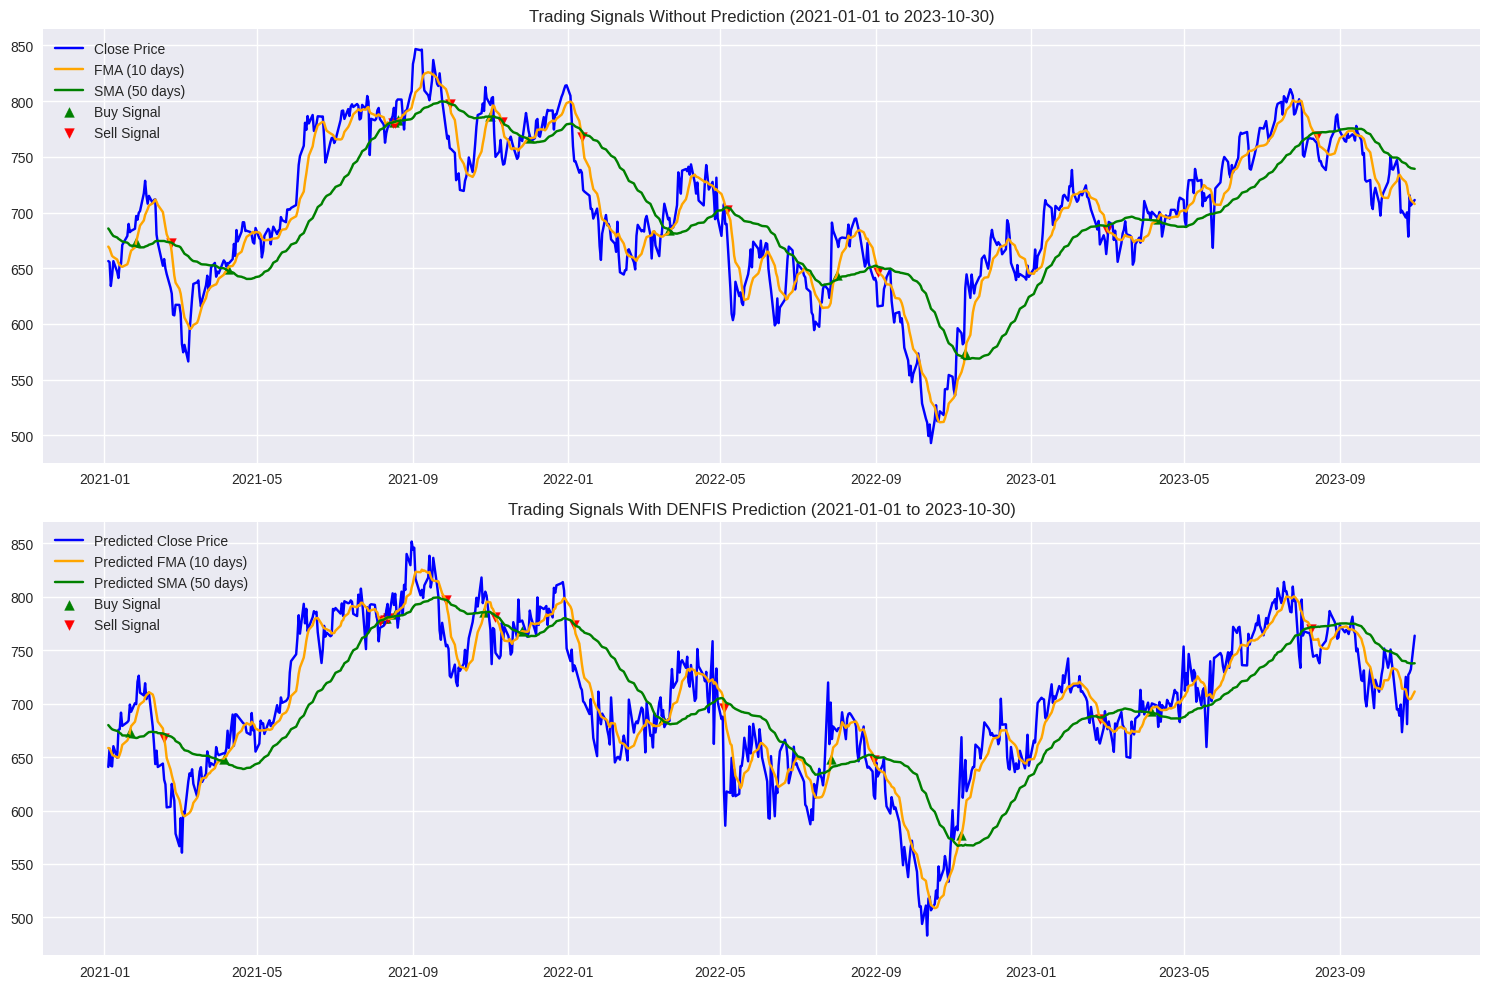

In [ ]:


# Define your start and end dates for the time frame
start_date = '2021-01-01'
end_date = '2023-10-30'

# Shift the predicted values in df2 by 3 days to align with actual values they predict
df2_shifted = df2.shift(-3)


# Filter both DataFrames for the specified time frame
df_time_frame = df[start_date:end_date]
df2_time_frame = df2_shifted[start_date:end_date]

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot for original data in the specified time frame
axs[0].plot(df_time_frame['Close'], label='Close Price', color='blue')
axs[0].plot(df_time_frame['FMA'], label='FMA (10 days)', color='orange')
axs[0].plot(df_time_frame['SMA'], label='SMA (50 days)', color='green')
axs[0].scatter(df_time_frame[df_time_frame['Position'] == 1].index, df_time_frame['FMA'][df_time_frame['Position'] == 1], color='green', marker='^', label='Buy Signal')
axs[0].scatter(df_time_frame[df_time_frame['Position'] == -1].index, df_time_frame['FMA'][df_time_frame['Position'] == -1], color='red', marker='v', label='Sell Signal')
axs[0].set_title(f'Trading Signals Without Prediction ({start_date} to {end_date})')
axs[0].legend()

# Plot for predicted data in the specified time frame
axs[1].plot(df2_time_frame['Close'], label='Predicted Close Price', color='blue')
axs[1].plot(df2_time_frame['FMA'], label='Predicted FMA (10 days)', color='orange')
axs[1].plot(df2_time_frame['SMA'], label='Predicted SMA (50 days)', color='green')
axs[1].scatter(df2_time_frame[df2_time_frame['Position'] == 1].index, df2_time_frame['FMA'][df2_time_frame['Position'] == 1], color='green', marker='^', label='Buy Signal')
axs[1].scatter(df2_time_frame[df2_time_frame['Position'] == -1].index, df2_time_frame['FMA'][df2_time_frame['Position'] == -1], color='red', marker='v', label='Sell Signal')
axs[1].set_title(f'Trading Signals With DENFIS Prediction ({start_date} to {end_date})')
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:

start_date = '2021-01-01'
end_date = '2023-10-30'
initial_capital = 10000  # Starting capital

# Function to shift the trade signals by 3 days
def shift_trade_signals(df):
    shifted_df = df.copy()
    shifted_df['Trade'] = df['Trade'].shift(-3)  # Shift trade signals by 3 days
    return shifted_df

# Backtest function
def backtest_strategy(df, initial_capital):
    capital = initial_capital
    position = 0  # No position initially

    for index, row in df[start_date:end_date].iterrows():
        if row['Trade'] == 1 and position == 0:  # Buy signal
            position = capital / row['Close']  # Buy as many shares as possible
            capital = 0
        elif row['Trade'] == 0 and position != 0:  # Sell signal
            capital = position * row['Close']  # Sell all shares
            position = 0

    # Final value of the portfolio
    final_day_close = df[end_date:end_date]['Close'].values[0]
    final_value = capital + position * final_day_close
    return final_value

# Shift the DENFIS trade signals by 3 days
df2_shifted = shift_trade_signals(df2)

# Backtest the original and DENFIS strategies
original_final_value = backtest_strategy(df, initial_capital)
denfis_final_value = backtest_strategy(df2_shifted, initial_capital)

# Print results
print(f"Original Strategy Final Portfolio Value: ${original_final_value:,.2f}")
print(f"DENFIS Strategy Final Portfolio Value: ${denfis_final_value:,.2f}")


Original Strategy Final Portfolio Value: $10,206.46
DENFIS Strategy Final Portfolio Value: $10,511.60


Compare DENFIS strategy vs LSTM strategy

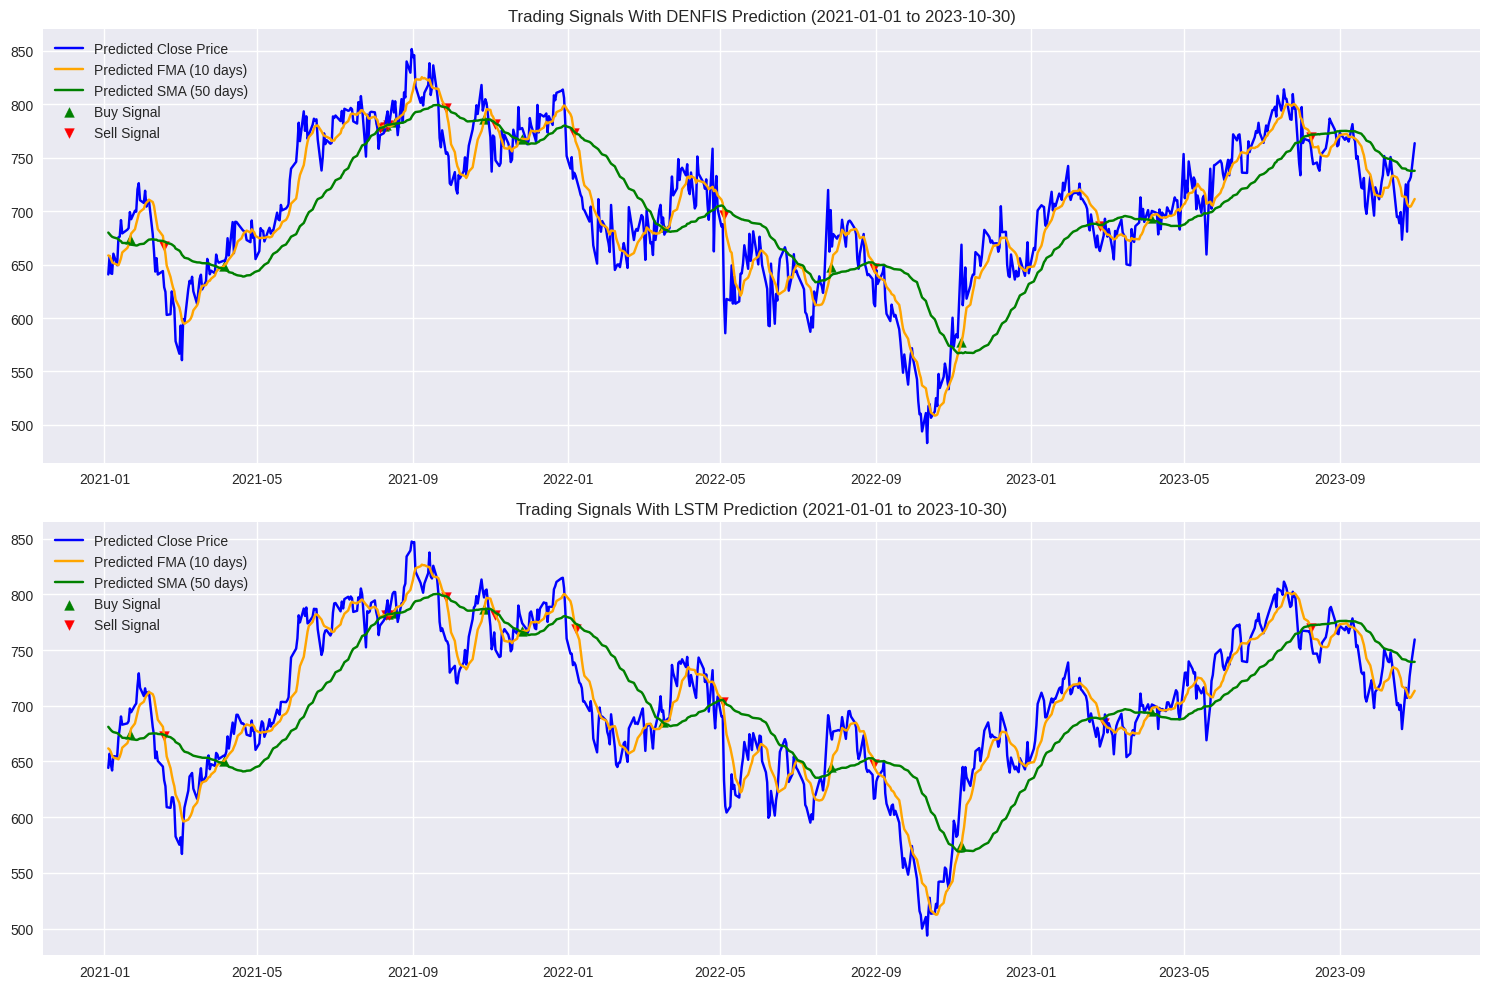

In [ ]:
# Define your start and end dates for the time frame
start_date = '2021-01-01'
end_date = '2023-10-30'

# Shift the predicted values in df2 by 3 days to align with actual values they predict
df2_shifted = df2.shift(-3)
df3_shifted = df3.shift(-3)


# Filter both DataFrames for the specified time frame

df2_time_frame = df2_shifted[start_date:end_date]
df3_time_frame = df3_shifted[start_date:end_date]


# Plotting
fig, axs = plt.subplots(2, 1, figsize=(15, 10))



# Plot for predicted data in the specified time frame
axs[0].plot(df2_time_frame['Close'], label='Predicted Close Price', color='blue')
axs[0].plot(df2_time_frame['FMA'], label='Predicted FMA (10 days)', color='orange')
axs[0].plot(df2_time_frame['SMA'], label='Predicted SMA (50 days)', color='green')
axs[0].scatter(df2_time_frame[df2_time_frame['Position'] == 1].index, df2_time_frame['FMA'][df2_time_frame['Position'] == 1], color='green', marker='^', label='Buy Signal')
axs[0].scatter(df2_time_frame[df2_time_frame['Position'] == -1].index, df2_time_frame['FMA'][df2_time_frame['Position'] == -1], color='red', marker='v', label='Sell Signal')
axs[0].set_title(f'Trading Signals With DENFIS Prediction ({start_date} to {end_date})')
axs[0].legend()



# Plot for predicted data in the specified time frame
axs[1].plot(df3_time_frame['Close'], label='Predicted Close Price', color='blue')
axs[1].plot(df3_time_frame['FMA'], label='Predicted FMA (10 days)', color='orange')
axs[1].plot(df3_time_frame['SMA'], label='Predicted SMA (50 days)', color='green')
axs[1].scatter(df3_time_frame[df3_time_frame['Position'] == 1].index, df3_time_frame['FMA'][df3_time_frame['Position'] == 1], color='green', marker='^', label='Buy Signal')
axs[1].scatter(df3_time_frame[df3_time_frame['Position'] == -1].index, df3_time_frame['FMA'][df3_time_frame['Position'] == -1], color='red', marker='v', label='Sell Signal')
axs[1].set_title(f'Trading Signals With LSTM Prediction ({start_date} to {end_date})')
axs[1].legend()


plt.tight_layout()
plt.show()

In [ ]:

start_date = '2021-01-01'
end_date = '2023-10-30'
initial_capital = 10000  # Starting capital

# Function to shift the trade signals by 3 days
def shift_trade_signals(df):
    shifted_df = df.copy()
    shifted_df['Trade'] = df['Trade'].shift(-3)  # Shift trade signals by 3 days
    return shifted_df

# Backtest function
def backtest_strategy(df, initial_capital):
    capital = initial_capital
    position = 0  # No position initially

    for index, row in df[start_date:end_date].iterrows():
        if row['Trade'] == 1 and position == 0:  # Buy signal
            position = capital / row['Close']  # Buy as many shares as possible
            capital = 0
        elif row['Trade'] == 0 and position != 0:  # Sell signal
            capital = position * row['Close']  # Sell all shares
            position = 0

    # Final value of the portfolio
    final_day_close = df[end_date:end_date]['Close'].values[0]
    final_value = capital + position * final_day_close
    return final_value

# Shift the DENFIS trade signals by 3 days
df2_shifted = shift_trade_signals(df2)
df3_shifted = shift_trade_signals(df3)

# Backtest the original and DENFIS strategies

denfis_final_value = backtest_strategy(df2_shifted, initial_capital)
LSTM_final_value = backtest_strategy(df3_shifted, initial_capital)

# Print results

print(f"DENFIS Strategy Final Portfolio Value: ${denfis_final_value:,.2f}")
print(f"LSTM Strategy Final Portfolio Value: ${LSTM_final_value:,.2f}")

DENFIS Strategy Final Portfolio Value: $10,511.60
LSTM Strategy Final Portfolio Value: $10,311.70


In [ ]:
# Define the date range
start_date = '2022-01-01'
end_date = '2023-10-31'

# Function to count trades
def count_trades(trade_series):
    return ((trade_series.diff() != 0) & (trade_series != 0)).sum()

# Counting trades for each scenario
original_trades = count_trades(df[start_date:end_date]['Trade'])
denfis_trades = count_trades(df2[start_date:end_date]['Trade'])
anfis_trades = count_trades(df3[start_date:end_date]['Trade'])

# Printing the number of trades
print(f'Original: {original_trades} trades')
print(f'DENFIS: {denfis_trades} trades')
print(f'ANFIS: {anfis_trades} trades')

Original: 10 trades
DENFIS: 10 trades
ANFIS: 10 trades


Analysis : $10,0000 are used as an initial inverstment to  backtest and determine the performance of DENFIS, LSTM and original strategy.

**DENFIS clearly perform relatively better compared to LSTM and original Strategy with $10,511 (DENFIS), $10,311 (LSTM) and 10,206 (Original strategy) from 2021-01-01 to 2023-10-31**

The performance of stock prediction using  (DENFIS) can be influenced by several key parameters:

1. Clusters Center: These represent the centers of clusters defining the fuzzy sets for inputs. In stock prediction, they could symbolize various states of market indicators, such as different price levels (low, medium, high). The positioning of these centers is crucial as it impacts the fuzzification of input data and the triggering of rules.

2. D_thr (Distance Threshold): This threshold defines the spread of the fuzzy sets around cluster centers. A larger D_thr value results in more inclusive fuzzy sets, leading to more generalized rules. In stock prediction, a higher D_thr might make the model less responsive to minor fluctuations in input features.

3. Batch Size: It determines the number of samples processed before updating the model parameters. Smaller batch sizes can cause quicker but potentially less stable learning, while larger sizes might lead to steadier but slower learning. This parameter influences how swiftly the model adjusts to new data patterns in stock markets.

4. N_epochs (Number of Epochs): This is the total count of times the learning algorithm will process the entire training dataset. More epochs enable deeper learning but raise the risk of overfitting. In stock prediction, the optimal number of epochs should balance thorough learning with the ability to generalize to new, unseen data.

5. Optimizer: The optimizer updates the network's weights and can significantly affect model convergence. Options like SGD, Adam, and RMSprop vary in efficiency, and the right choice is crucial for effectively learning complex patterns in stock prediction.

6. Loss Function: This function, aimed to be minimized during training, directly influences how prediction errors are penalized. In stock prediction, loss functions like mean squared error (MSE) are common, especially for regression tasks.

7. N_input (Number of Features): This denotes the count of input features for the model. In stock prediction, these might include various technical indicators, historical prices, and volumes. The selection and quality of these features significantly affect the model's ability to discern market patterns.

8. M_input (Number of Membership Functions): This represents the count of fuzzy sets for each feature, affecting the detail level in fuzzification. While more functions can detect finer nuances in input variables, they also add complexity and the potential for overfitting.

Each of these parameters plays a critical role in the model's ability to predict stock prices accurately and must be carefully calibrated to the specific characteristics of the financial data being analyzed.

In [ ]:
print('Original:')
print(df['2022-01-01':'2023-10-31']['Trade'])
print('DENFIS:')
print(df2['2022-01-01':'2023-10-31']['Trade'])
print('ANFIS:')
print(df3['2022-01-01':'2023-10-31']['Trade'])

Original:
Date
2022-01-03 00:00:00-05:00    1.0
2022-01-04 00:00:00-05:00    1.0
2022-01-05 00:00:00-05:00    1.0
2022-01-06 00:00:00-05:00    1.0
2022-01-07 00:00:00-05:00    1.0
                            ... 
2023-10-25 00:00:00-04:00   -1.0
2023-10-26 00:00:00-04:00   -1.0
2023-10-27 00:00:00-04:00   -1.0
2023-10-30 00:00:00-04:00   -1.0
2023-10-31 00:00:00-04:00   -1.0
Name: Trade, Length: 460, dtype: float64
DENFIS:
2022-01-03 00:00:00-05:00    1.0
2022-01-04 00:00:00-05:00    1.0
2022-01-05 00:00:00-05:00    1.0
2022-01-06 00:00:00-05:00    1.0
2022-01-07 00:00:00-05:00    1.0
                            ... 
2023-10-25 00:00:00-04:00   -1.0
2023-10-26 00:00:00-04:00   -1.0
2023-10-27 00:00:00-04:00   -1.0
2023-10-30 00:00:00-04:00   -1.0
2023-10-31 00:00:00-04:00   -1.0
Name: Trade, Length: 460, dtype: float64
ANFIS:
2022-01-03 00:00:00-05:00    1.0
2022-01-04 00:00:00-05:00    1.0
2022-01-05 00:00:00-05:00    1.0
2022-01-06 00:00:00-05:00    1.0
2022-01-07 00:00:00-05:00    1

##5.3 Pros and Cons of DENFIS for Stock/Trust Prediction
The Dynamic Evolving Neural-Fuzzy Inference System (DENFIS) is a sophisticated model that combines the principles of fuzzy logic with the learning capabilities of neural networks. It's used in various predictive analytics, including stock market prediction. Here's an overview of its pros and cons in this context:


Pros of DENFIS for Stock Prediction
1. Adaptability: DENFIS excels in adapting to new data patterns through its capability for online learning. This feature is particularly beneficial in the dynamic environment of the stock market, where conditions frequently change.

2. Handling Non-Linearity: The stock market is characterized by non-linear and often noisy data. DENFIS models can effectively capture complex non-linear relationships, which is crucial for accurate stock price prediction.

3. Dealing with Uncertainty: The incorporation of fuzzy logic in DENFIS enables it to manage the uncertainty and imprecision inherent in stock market data, offering an advantage over traditional quantitative models that might struggle with such ambiguity.

4. Rule-Based System: DENFIS employs interpretable rules, providing valuable insights into the reasoning behind predictions and the interplay between various market indicators.

5. Integration of Expert Knowledge: The model facilitates the inclusion of expert insights, enhancing its applicability in areas where human expertise, such as in stock analysis, is of significant value.

6. Real-Time Learning and Prediction: DENFIS's ability to process data in real-time makes it well-suited for applications necessitating immediate responses, like in high-frequency trading.

Cons of DENFIS for Stock Prediction

1. Complexity: The complexity of DENFIS requires meticulous tuning and validation to prevent overfitting, a process that can be time-consuming and demands expertise in fuzzy systems and neural networks.

2. Computational Cost: The computational demands, particularly for online learning and real-time adaptation, may not be feasible for every application, especially with large datasets.

3. Sensitivity to Noise: While fuzzy systems are generally more resilient to noise, the neural network component of DENFIS might still be prone to overfitting to noise rather than the underlying data trends.

4. Dependence on Data Quality: The performance of DENFIS is heavily contingent on the quality of the input data. Inferior or irrelevant features can substantially impair model accuracy.




The DENFIS model offers several advantages for stock prediction, including its adaptability, ability to handle complex data characteristics, and integration of expert knowledge. However, these benefits come with challenges such as model complexity, computational demands, and sensitivity to data quality. The decision to employ DENFIS should be based on a careful assessment of these factors in relation to the specific requirements of the stock prediction task at hand.







## 5.4 Conclusion



In conclusion, the analysis suggests that the Dynamic Evolving Neural-Fuzzy Inference System (DENFIS) offers a more advantageous approach for stock prediction compared to the Long Short-Term Memory (LSTM) networks and a baseline strategy without prediction. This conclusion is based on several key aspects:

Prediction Accuracy: DENFIS demonstrates marginally better prediction accuracy than LSTM, as indicated by its slightly lower Root Mean Square Error (RMSE) and a mean error closer to zero. This suggests that DENFIS is more reliable in its predictions.

Performance Consistency: DENFIS shows more consistency in its predictions, evidenced by its lower standard deviation of errors compared to LSTM. This consistency is crucial in the volatile domain of stock predictions, where reliability is as important as accuracy.

Risk and Volatility Management: Although both DENFIS and LSTM exhibit periods of volatility and are susceptible to market turbulence, DENFIS's performance, on balance, offers a more favorable risk-return profile. It manages the inherent risks in stock prediction more effectively than LSTM, balancing potential high returns with a manageable risk level.

Long-Term Performance: Over the long term, while the performance of DENFIS and LSTM models tends to converge, DENFIS maintains a slight edge. This suggests that it may be more robust to market changes over time, an important consideration for sustained investment strategies.

Compared to Baseline Strategy: When compared to a baseline strategy that involves no prediction, both DENFIS and LSTM demonstrate superior performance. However, DENFIS's combination of higher accuracy, consistency, and better risk management makes it a more preferable option for investors seeking to leverage advanced analytical techniques in stock market investments.

In summary, while both DENFIS and LSTM models are powerful tools for stock prediction, offering significant advantages over a non-predictive baseline approach, DENFIS stands out as the more effective model. Its balance of accuracy, consistency, and risk management aligns well with the needs of investors who are navigating the complex and often unpredictable nature of the stock market. However, it is important to note that past performance is not always indicative of future results, and investors should consider their specific requirements, market conditions, and risk tolerance when choosing an investment strategy. Regular updates and adaptations of the chosen model to the evolving market dynamics are also crucial for maintaining its effectiveness.

#6.Future Research on method
Integration of Reinforcement Learning (RL) with Takagi-Sugeno-Kang (TSK) fuzzy systems and Adaptive Neuro-Fuzzy Inference System (ANFIS), focusing on their application in explainable AI. The research includes case studies like the Asteroid Smasher game and CartPole-v1 environment, demonstrating the feasibility and effectiveness of these systems in complex control environments. It emphasizes the potential of TSK fuzzy systems and ANFIS architectures in developing explainable AI, as they are amenable to visualization and offer insights into their decision-making processes. The future research directions suggested include enhancing the stability of RL algorithms in complex environments, exploring applications and architectures for ANFIS, and investigating unique explainability mechanisms, especially in contexts where traditional neural networks are commonly used. The integration of RL with fuzzy logic is highlighted as a relatively underexplored yet promising area, suggesting that further experimentation and research could yield significant advancements in creating performant and explainable applications.


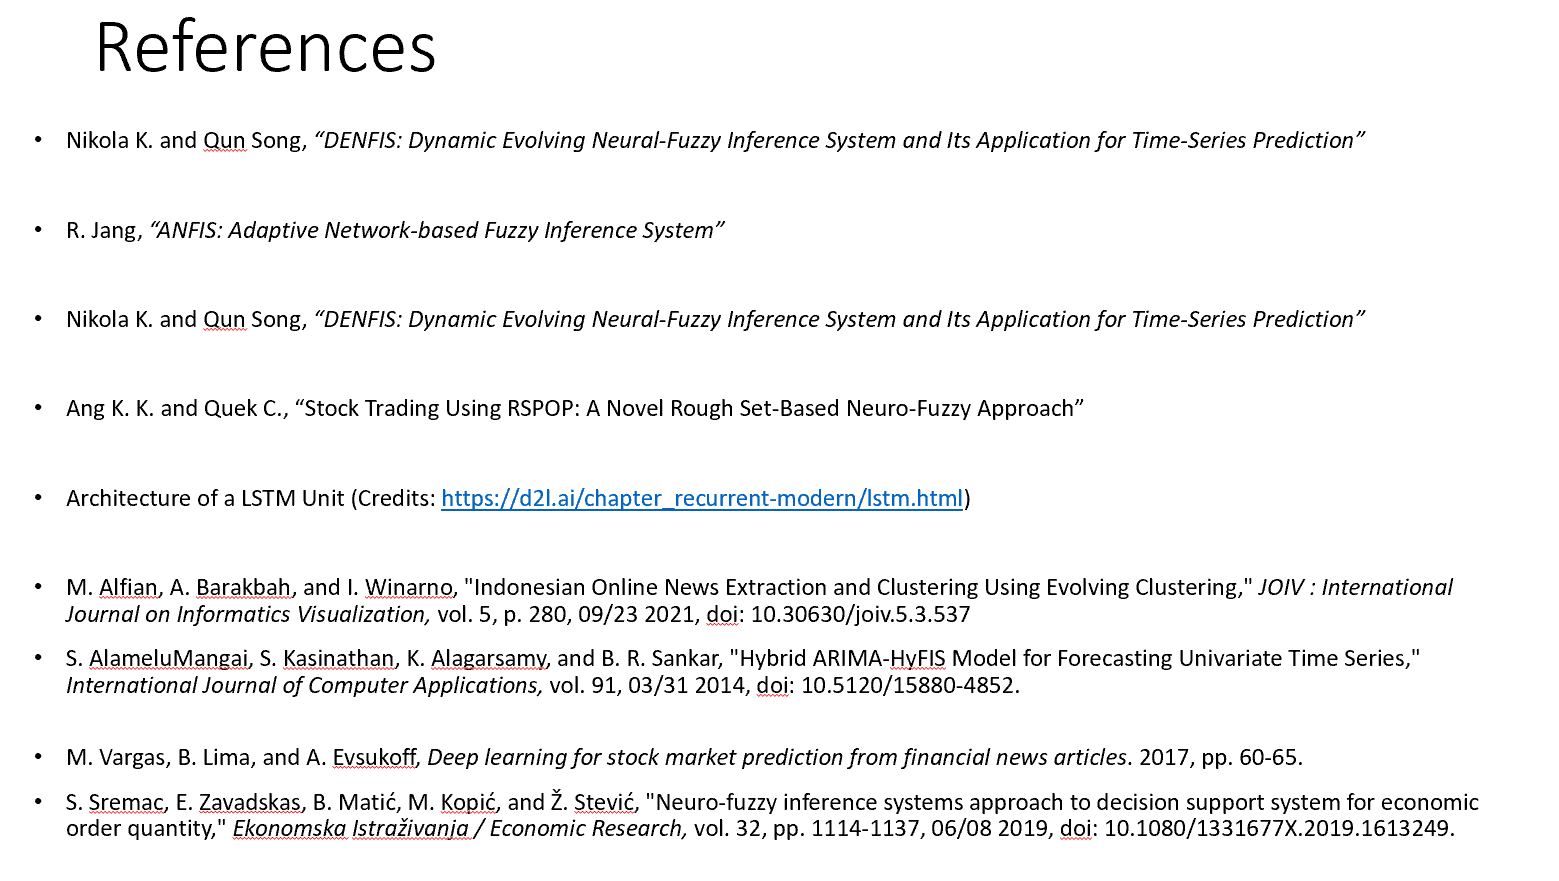

#7.Appendix: Another Hybrid AI model- ANFIS

**Appendix Figure 1: ANFIS Structure**

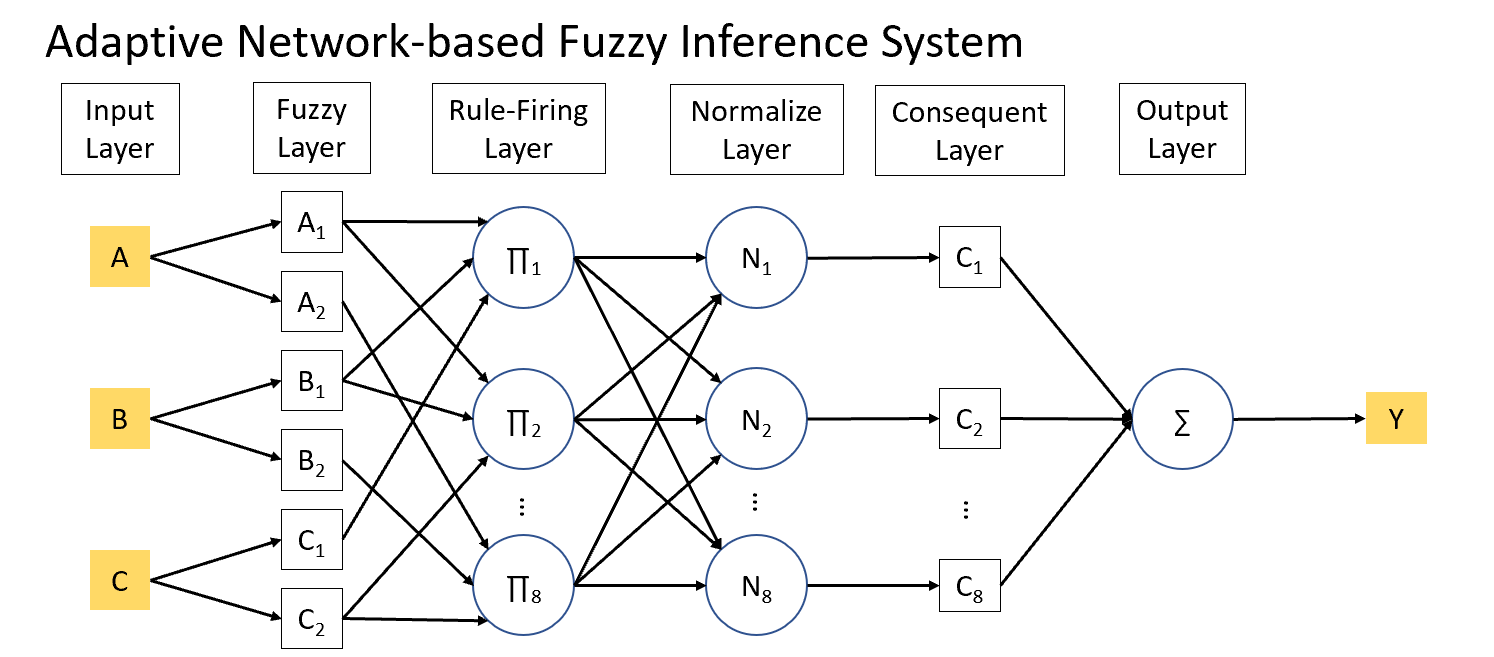

## 1.ANFIS - Structure

1. Input Layer
This is where the system receives inputs. There are three inputs labeled A, B, and C, each associated with two nodes in the next layer representing linguistic labels, such as "low" and "high" or "small" and "large", defined by membership functions.

2. Fuzzy Layer
Nodes in this layer are membership functions applied to the inputs, like `A1` and `A2` for input A. The output is the membership value for each label.

3. Rule-Firing Layer
Each node represents a fuzzy rule, for example, `Π1` could be "IF A is low AND B is high AND C is low THEN ...". The output is the product of the membership values, indicating rule strength.

4. Normalize Layer
Nodes labeled `N` normalize rule strengths by dividing each rule's strength by the sum of all rule strengths.

5. Consequent Layer
Each node corresponds to a rule and has a function, typically a linear combination of inputs plus a constant term, e.g., `C1 = p1*A + q1*B + r1*C + s1`, with parameters `p`, `q`, `r`, and `s`. The output is the product of normalized firing strength and the consequent function.

6. Output Layer
A single node computes the overall output as the sum of all consequent nodes' outputs, giving the final output Y.

Each step in the ANFIS model serves a function in fuzzy inference, from fuzzification in the Fuzzy Layer to defuzzification in the Output Layer. Parameters of the membership and rule functions are learned from data, allowing ANFIS to model complex nonlinear functions accurately.




## 2.Model Training for ANFIS


In [ ]:

# define number of previous days delta closing prices as features to predict tomorrow's delta closing price
num_days = 3
num_features = num_days
num_rows = len(EQ_DF)
EQ_DF['x_1'] = 0.0 # c(T) - c(T-1)
EQ_DF['x_2'] = 0.0 # c(T-1) - c(T-2)
EQ_DF['x_3'] = 0.0 # c(T-2) - c(T-3)
EQ_DF['y_0'] = 0.0 # c(T+1) - c(T)

for i in range(num_days, num_rows-1):
    EQ_DF['x_1'].iloc[i] = EQ_DF['Close'].iloc[i] - EQ_DF['Close'].iloc[i-1]
    EQ_DF['x_2'].iloc[i] = EQ_DF['Close'].iloc[i-1] - EQ_DF['Close'].iloc[i-2]
    EQ_DF['x_3'].iloc[i] = EQ_DF['Close'].iloc[i-2] - EQ_DF['Close'].iloc[i-3]
    EQ_DF['y_0'].iloc[i] = EQ_DF['Close'].iloc[i+1] - EQ_DF['Close'].iloc[i]

# Save required information to new dataframe
df = EQ_DF.iloc[num_days:num_rows-1][['x_1', 'x_2', 'x_3', 'y_0','Close']]
display(df.head(10))

# Convert dataframe to numpy
data = df.to_numpy()
X = data[:,0:num_features]
Y = data[:,-2]
Y = Y.reshape(-1,1)

# scale data to [0, 1] for ECM algorithm and models
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
scaler_X.fit(X)
scaler_Y.fit(Y)
X = scaler_X.transform(X)
Y = scaler_Y.transform(Y)

# Split data into 60/15/25 train/val/test datasets
num_train = int(len(X)*0.55)
num_val = int(len(X)*0.8)
num_test = len(X)

X_train = X[0:num_train,:]
y_train = Y[0:num_train]
X_val = X[num_train:num_val,:]
y_val = Y[num_train:num_val]
X_test = X[num_val:num_test,:]
y_test = Y[num_val:num_test]

print(f'No. of data samples: {len(X)}')
print(f'No. of training data samples: {len(X_train)} with shape {X_train.shape}')
print(f'No. of validation data samples: {len(X_val)} with shape {X_val.shape}')
print(f'No. of testing data samples: {len(X_test)} with shape {X_test.shape}')


x_1        x_2        x_3        y_0  \
Date                                                                    
2000-08-16 00:00:00-04:00   6.204987   3.102478 -27.922455  -9.307465   
2000-08-17 00:00:00-04:00  -9.307465   6.204987   3.102478  57.396149   
2000-08-18 00:00:00-04:00  57.396149  -9.307465   6.204987  21.717499   
2000-08-21 00:00:00-04:00  21.717499  57.396149  -9.307465 -41.883759   
2000-08-22 00:00:00-04:00 -41.883759  21.717499  57.396149 -12.409912   
2000-08-23 00:00:00-04:00 -12.409912 -41.883759  21.717499 -23.268707   
2000-08-24 00:00:00-04:00 -23.268707 -12.409912 -41.883759  20.166199   
2000-08-25 00:00:00-04:00  20.166199 -23.268707 -12.409912   6.204987   
2000-08-28 00:00:00-04:00   6.204987  20.166199 -23.268707   6.204956   
2000-08-29 00:00:00-04:00   6.204956   6.204987  20.166199  20.166290   

                                Close  
Date                                   
2000-08-16 00:00:00-04:00  307.146942  
2000-08-17 00:00:00-04:00  297.839478  
2000-08-18 00:00:00-04:00  355.235626  
2000-08-21 00:00:00-04:00  376.953125  
2000-08-22 00:00:00-04:00  335.069366  
2000-08-23 00:00:00-04:00  322.659454  
2000-08-24 00:00:00-04:00  299.390747  
2000-08-25 00:00:00-04:00  319.556946  
2000-08-28 00:00:00-04:00  325.761932  
2000-08-29 00:00:00-04:00  331.966888

No. of data samples: 5851
No. of training data samples: 3218 with shape (3218, 3)
No. of validation data samples: 1462 with shape (1462, 3)
No. of testing data samples: 1171 with shape (1171, 3)


In [ ]:
# parameter class fis parameters
class fis_parameters():
    def __init__(self, n_input: int = 3, n_memb: int = 3, batch_size: int = 16, n_epochs: int = 25, memb_func: str = 'gaussian', optimizer: str = 'sgd', loss: str = 'mse'):
        self.n_input = n_input  # no. of Regressors
        self.n_memb = n_memb  # no. of fuzzy memberships
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.memb_func = memb_func  # 'gaussian' / 'gbellmf'
        self.optimizer = optimizer   # sgd / adam /
        self.loss = loss  # mse / mae


# Main Class ANFIS
class ANFIS:
    def __init__(self, n_input: int, n_memb: int, batch_size: int = 16, memb_func: str = 'gaussian', name: str = 'MyAnfis'):
        self.n = n_input
        self.m = n_memb
        self.batch_size = batch_size
        self.memb_func = memb_func
        input_ = keras.layers.Input(shape=(n_input), name='inputLayer', batch_size=self.batch_size)
        print(f'input_ type: {type(input_)} and shape {input_.shape}')
        L1 = FuzzyLayer(n_input, n_memb, memb_func, name='fuzzyLayer')(input_)
        print(f'L1 output type: {type(L1)} and shape {L1.shape}')
        L2 = RuleLayer(n_input, n_memb, name='ruleLayer')(L1)
        print(f'L2 output type: {type(L2)} and shape {L2.shape}')
        L3 = NormLayer(name='normLayer')(L2)
        print(f'L3 output type: {type(L3)} and shape {L3.shape}')
        L4 = DefuzzLayer(n_input, n_memb, name='defuzzLayer')(L3, input_)
        print(f'L4 output type: {type(L4)} and shape {L4.shape}')
        L5 = SummationLayer(name='sumLayer')(L4)
        print(f'L5 output type: {type(L5)} and shape {L5.shape}')
        self.model = keras.Model(inputs=[input_], outputs=[L5], name=name)
        self.update_weights()

    def __call__(self, X):
        return self.model.predict(X, batch_size=self.batch_size)

    def update_weights(self):
        # premise parameters (mu&sigma for gaussian // a/b/c for bell-shaped)
        if self.memb_func == 'gaussian':
            self.mus, self.sigmas = self.model.get_layer(
                'fuzzyLayer').get_weights()
        elif self.memb_func == 'gbellmf':
            self.a, self.b, self.c = self.model.get_layer(
                'fuzzyLayer').get_weights()
        # consequence parameters
        self.bias, self.weights = self.model.get_layer(
            'defuzzLayer').get_weights()

    def plotmfs(self, show_initial_weights=False):
        n_input = self.n
        n_memb = self.m

        if self.memb_func == 'gaussian':
            mus, sigmas = np.around(self.model.get_layer(
                'fuzzyLayer').get_weights(), 2)
            mus, sigmas = mus.reshape(
                (n_memb, n_input, 1)), sigmas.reshape(n_memb, n_input, 1)

            xn = np.linspace(0, 1, 10001).reshape((1, 1, -1))
            xn = np.tile(xn, (n_memb, n_input, 1))

            # broadcast all curves in one array
            memb_curves = np.exp(-np.square((xn - mus)) / np.square(sigmas))

            if show_initial_weights:
                mus_init, sigmas_init = np.around(self.init_weights, 2)
                mus_init, sigmas_init = mus_init.reshape(
                    n_memb, n_input, 1), sigmas_init.reshape(n_memb, n_input, 1)
                init_curves = np.exp(-np.square((xn - mus_init)
                                                ) / np.square(sigmas_init))

        elif self.memb_func == 'gbellmf':
            a, b, c = np.around(self.model.get_layer(
                'fuzzyLayer').get_weights(), 2)
            a, b, c = a.reshape((n_memb, n_input, 1)), b.reshape(
                n_memb, n_input, 1), c.reshape(n_memb, n_input, 1)

            xn = np.linspace(np.min(c) - np.max(abs(a)),
                             np.max(c) + np.max(abs(a)), 10001).reshape((1, 1, -1))
            xn = np.tile(xn, (n_memb, n_input, 1))

            # broadcast all curves in one array
            memb_curves = 1 / (1 + np.square((xn - c) / a)**b)

            if show_initial_weights:
                a_init, b_init, c_init = np.around(self.init_weights, 2)
                a_init, b_init, c_init = a_init.reshape((n_memb, n_input, 1)), b_init.reshape(
                    n_memb, n_input, 1), c_init.reshape(n_memb, n_input, 1)
                init_curves = 1 / \
                    (1 + np.square((xn - c_init) / a_init)**b_init)

        elif self.memb_func == 'sigmoid':
            gammas, c = np.around(self.model.get_layer(
                'fuzzyLayer').get_weights(), 2)
            gammas, c = gammas.reshape(
                (n_memb, n_input, 1)), c.reshape(n_memb, n_input, 1)

            xn = np.linspace(np.min(c) - np.max(abs(c)), np.max(c) + np.max(
                abs(c)), 10001).reshape((1, 1, -1))
            xn = np.tile(xn, (n_memb, n_input, 1))

            # broadcast all curves in one array
            memb_curves = 1 / (1 + np.exp(-gammas * (xn - c)))

            if show_initial_weights:
                gammas_init, c_init = np.around(self.init_weights, 2)
                gammas_init, c_init = gammas_init.reshape(
                    n_memb, n_input, 1), c_init.reshape(n_memb, n_input, 1)
                init_curves = 1 / (1 + np.exp(-gammas_init * (xn - c_init)))

        fig, axs = plt.subplots(nrows=n_input, ncols=1, figsize=(10,10))
        fig.suptitle('Membership functions', size=16)
        for n in range(self.n):
            axs[n].grid(True)
            axs[n].set_title(f'Input {n+1}')
            for m in range(self.m):
                axs[n].plot(xn[m, n, :], memb_curves[m, n, :])

        if show_initial_weights:  # plot initial membership curve
            for n in range(self.n):
                axs[n].set_prop_cycle(None)  # reset color cycle
                for m in range(self.m):
                    axs[n].plot(xn[m, n, :], init_curves[m, n, :],
                                '--', alpha=.5)
        plt.show()

    def fit(self, X, y, **kwargs):
        # save initial weights in the anfis class
        self.init_weights = self.model.get_layer('fuzzyLayer').get_weights()

        # fit model & update weights in the anfis class
        history = self.model.fit(X, y, **kwargs)
        self.update_weights()

        # clear the graphs
        tf.keras.backend.clear_session()

        return history

    def get_memberships(self, Xs):
        intermediate_layer_model = keras.Model(inputs=self.model.input,
                                               outputs=self.model.get_layer('normLayer').output)

        intermediate_L2_output = intermediate_layer_model.predict(Xs)

        return intermediate_L2_output


# Custom weight initializer
def equally_spaced_initializer(shape, minval=-2.0, maxval=2.0, dtype=tf.float32):
    """
    Custom weight initializer:
        euqlly spaced weights along an operating range of [minval, maxval].
    """
    linspace = tf.reshape(tf.linspace(minval, maxval, shape[0]),
                          (-1, 1))
    return tf.Variable(tf.tile(linspace, (1, shape[1])))


# Layer 1
class FuzzyLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, memb_func='gaussian', **kwargs):
        super(FuzzyLayer, self).__init__(**kwargs)
        self.n = n_input
        self.m = n_memb
        self.memb_func = memb_func

    def build(self, batch_input_shape):
        self.batch_size = batch_input_shape[0]

        if self.memb_func == 'gbellmf':
            self.a = self.add_weight(name='a', # width of membership
                                     shape=(self.m, self.n),
                                     initializer=keras.initializers.RandomUniform(minval=0.1, maxval=0.4, seed=1),
                                     constraint=lambda x: tf.clip_by_value(x, 0.2, 0.4),
                                     trainable=True)
            self.b = self.add_weight(name='b', # slope of membership
                                     shape=(self.m, self.n),
                                     initializer=keras.initializers.RandomUniform(minval=0.1, maxval=1.5, seed=1),
                                     constraint=lambda x: tf.clip_by_value(x, 0.4, 0.8),
                                     trainable=True)
            self.c = self.add_weight(name='c', # center of membership
                                     shape=(self.m, self.n),
                                     initializer = keras.initializers.RandomUniform(minval=0.0, maxval=1.0, seed=1),
                                     constraint=lambda x: tf.clip_by_value(x, 0.0, 1.0),
                                     trainable=True)

        elif self.memb_func == 'gaussian':
            self.mu = self.add_weight(name='mu',
                                      shape=(self.m, self.n),
                                      initializer = keras.initializers.RandomUniform(minval=0.0, maxval=1.0, seed=1),
                                      constraint=lambda x: tf.clip_by_value(x, 0.0, 1.0),
                                      trainable=True)
            self.sigma = self.add_weight(name='sigma',
                                         shape=(self.m, self.n),
                                         initializer=keras.initializers.RandomUniform(minval=0.1, maxval=0.2, seed=1),
                                         constraint=lambda x: tf.clip_by_value(x, 0.1, 0.2),
                                         trainable=True)

        elif self.memb_func == 'sigmoid':
            self.gamma = self.add_weight(name='gamma',
                                         shape=(self.m, self.n),
                                         initializer=equally_spaced_initializer,  # 'ones',
                                         trainable=True)

            self.c = self.add_weight(name='c',
                                     shape=(self.m, self.n),
                                     initializer=equally_spaced_initializer,  # 'ones',
                                     trainable=True)

        # Be sure to call this at the end
        super(FuzzyLayer, self).build(batch_input_shape)

    def call(self, x_inputs):
        if self.memb_func == 'gbellmf':
            L1_output = 1 / (1 +
                             tf.math.pow(
                                 tf.square(tf.subtract(
                                     tf.reshape(
                                         tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n)), self.c
                                 ) / self.a), self.b)
                             )
        elif self.memb_func == 'gaussian':
            L1_output = tf.exp(-1 *
                               tf.square(tf.subtract(
                                   tf.reshape(
                                       tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n)), self.mu
                               )) / tf.square(self.sigma))

        elif self.memb_func == 'sigmoid':
            L1_output = tf.math.divide(1,
                                       tf.math.exp(-self.gamma *
                                                   tf.subtract(
                                                       tf.reshape(
                                                           tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n)), self.c)
                                                   )
                                       )
        return L1_output


# Layer 2
class RuleLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, **kwargs):
        super(RuleLayer, self).__init__(**kwargs)
        self.n = n_input
        self.m = n_memb
        self.batch_size = None

    def build(self, batch_input_shape):
        self.batch_size = batch_input_shape[0]
        # Be sure to call this at the end
        super(RuleLayer, self).build(batch_input_shape)

    def call(self, input_):
        if self.n == 2:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1])
        elif self.n == 3:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1])
        elif self.n == 4:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 3], [self.batch_size, 1, 1, 1, -1])
        elif self.n == 5:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 3], [self.batch_size, 1, 1, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 4], [self.batch_size, 1, 1, 1, 1, -1])
        elif self.n == 6:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 3], [self.batch_size, 1, 1, 1, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 4], [self.batch_size, 1, 1, 1, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 5], [self.batch_size, 1, 1, 1, 1, 1, -1])
        else:
            raise ValueError(
                f'This ANFIS implementation works with 2 to 6 inputs.')
        L2_output = tf.reshape(L2_output, [self.batch_size, -1])
        return L2_output


# Layer 3
class NormLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, w):
        w_sum = tf.reshape(tf.reduce_sum(w, axis=1), (-1, 1))
        w_norm = w / w_sum
        return w_norm


# Layer 4
class DefuzzLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, **kwargs):
        super().__init__(**kwargs)
        self.n = n_input
        self.m = n_memb

        self.bias = self.add_weight(name='Consequence_bias',
                                       shape=(1, self.m ** self.n),
                                       initializer=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=1),
                                       trainable=True)
        self.weight = self.add_weight(name='Consequence_weight',
                                         shape=(self.n, self.m ** self.n),
                                         initializer=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=1),
                                         trainable=True)

    def call(self, w_norm, input_):

        L4_L2_output = tf.multiply(w_norm,
                                   tf.matmul(input_, self.weight) + self.bias)
        return L4_L2_output  # Defuzzyfied Layer


# Layer 5
class SummationLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.batch_size = batch_input_shape[0]
        #self.batch_size = tf.shape(batch_input_shape)[0]
        # Be sure to call this at the end
        super(SummationLayer, self).build(batch_input_shape)

    def call(self, input_):
        L5_L2_output = tf.reduce_sum(input_, axis=1)
        L5_L2_output = tf.reshape(L5_L2_output, (-1, 1))
        return L5_L2_output

input_ type: <class 'keras.src.engine.keras_tensor.KerasTensor'> and shape (1, 3)
L1 output type: <class 'keras.src.engine.keras_tensor.KerasTensor'> and shape (1, 6, 3)
L2 output type: <class 'keras.src.engine.keras_tensor.KerasTensor'> and shape (1, 216)
L3 output type: <class 'keras.src.engine.keras_tensor.KerasTensor'> and shape (1, 216)
L4 output type: <class 'keras.src.engine.keras_tensor.KerasTensor'> and shape (1, 216)
L5 output type: <class 'keras.src.engine.keras_tensor.KerasTensor'> and shape (1, 1)
Epoch 1/50
3218/3218 [==============================] - 10s 3ms/step - loss: 0.0049 - val_loss: 0.0014
Epoch 2/50
3218/3218 [==============================] - 8s 3ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 3/50
3218/3218 [==============================] - 8s 3ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 4/50
3218/3218 [==============================] - 9s 3ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 5/50
3218/3218 [==============================] - 8s 2ms/step - loss:

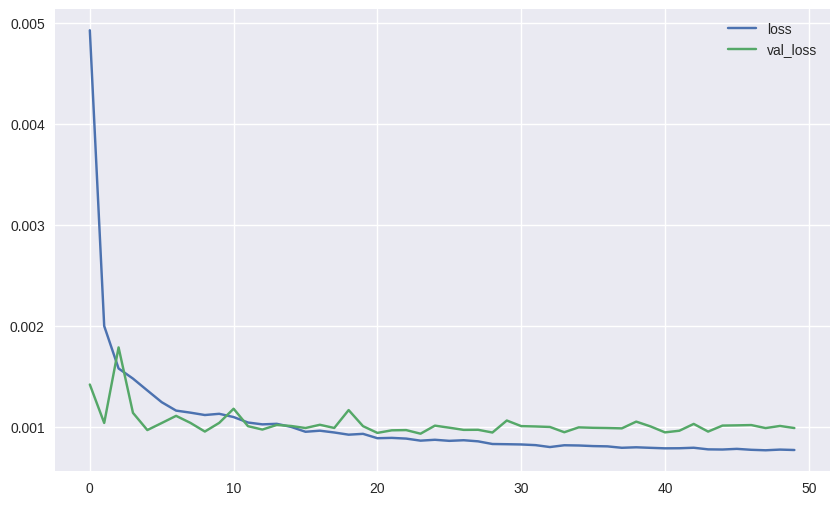

In [ ]:

# set parameters
param = fis_parameters(
    n_input=len(X_train[0]),                # no. of Regressors
    n_memb=6,                 # no. of fuzzy memberships
    batch_size=1,            # 16 / 32 / 64 / ...
    memb_func='gaussian',      # 'gaussian' / 'gbellmf' / 'sigmoid'
    optimizer='sgd',          # sgd / adam / ...
    # mse / mae / huber_loss / mean_absolute_percentage_error / ...
    loss='mse',
    n_epochs=50              # 10 / 25 / 50 / 100 / ...
)

# plt.style.use('seaborn')                # default / ggplot / seaborn
# plot_prediction = True                  # True / False

fis = ANFIS(n_input=param.n_input,
            n_memb=param.n_memb,
            batch_size=param.batch_size,
            memb_func=param.memb_func,
            name='ANFIS'
           )

# compile model
fis.model.compile(optimizer=param.optimizer,
                  loss=param.loss,
#                    metrics=['mse']  # ['mae', 'mse']
                  )

# fit model
history = fis.fit(X_train, y_train,
                  epochs=param.n_epochs,
                  batch_size=param.batch_size,
                  validation_data=(X_val, y_val),
                  )
# eval model
loss_curves = pd.DataFrame(history.history)
loss_curves.plot(figsize=(10, 6))
fis.model.summary()

# get premise parameters
premise_parameters = fis.model.get_layer('fuzzyLayer').get_weights()

# get consequence paramters
bias = fis.bias
weights = fis.weights

## 3.Prediction results and Portfoilo Multiplicative returns of LSTM

Plot ANFIS Model Train & Val Predictions

3218/3218 [==============================] - 6s 2ms/step


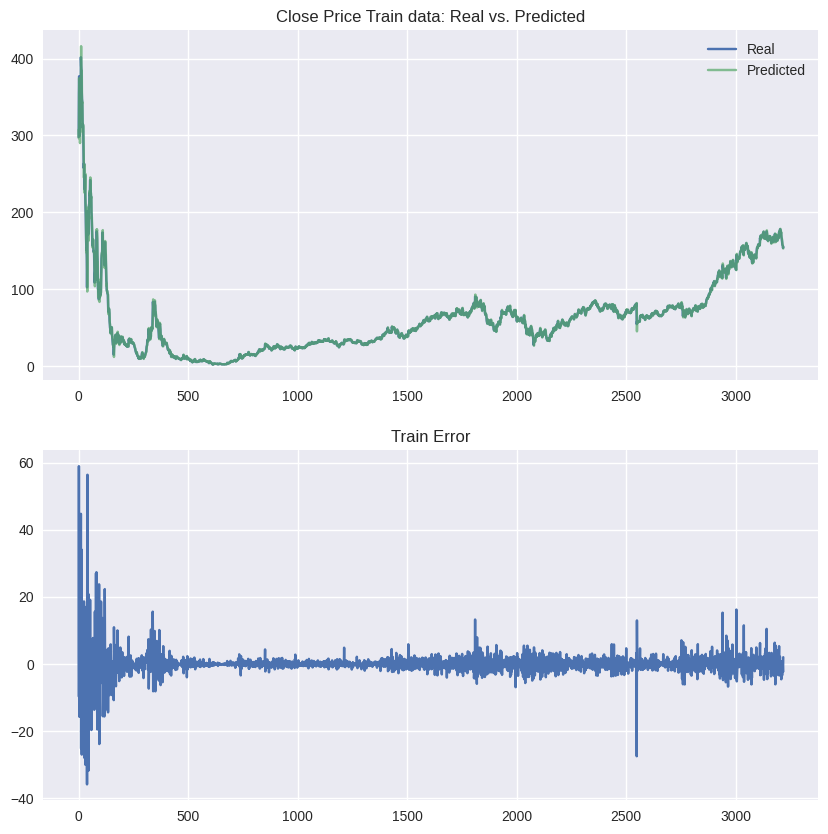

1462/1462 [==============================] - 3s 2ms/step


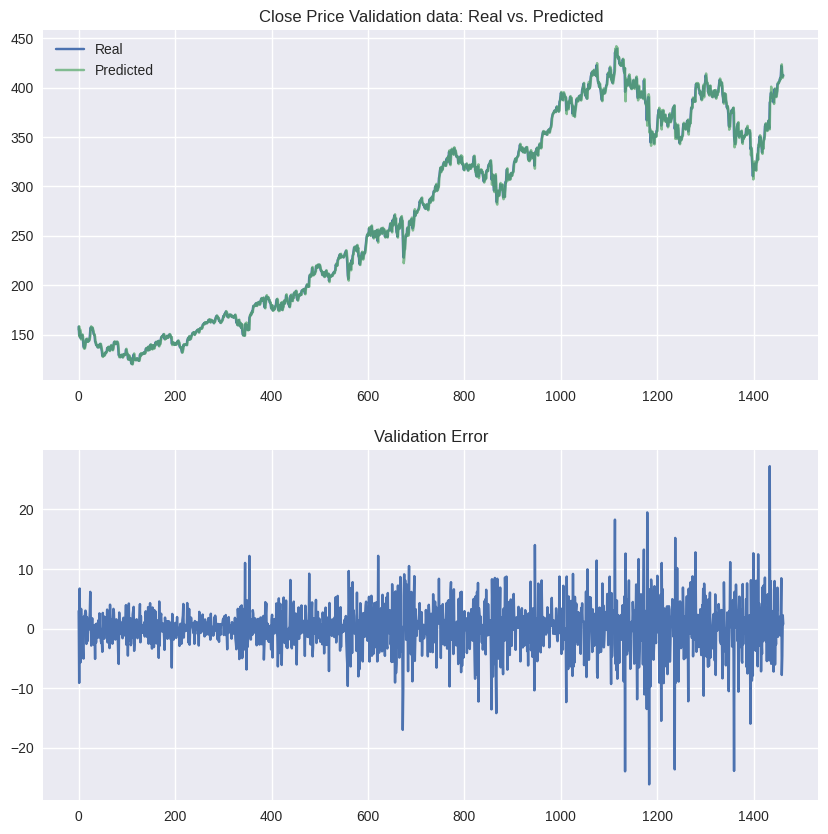

In [ ]:
# Plot train data vs predicted of train data
y_train_pred_b4 = fis(X_train) # predicted scaled delta
y_train_pred = scaler_Y.inverse_transform(y_train_pred_b4) # predicted unscaled delta
y_train_pred = np.reshape(df['Close'][0:num_train].values, [-1,1]) + y_train_pred # predicted unscaled 'Close' price

y_train = scaler_Y.inverse_transform(y_train) # real unscaled delta
y_train = np.reshape(df['Close'][0:num_train].values, [-1,1]) + y_train # real unscaled 'Close' price

f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(y_train)
axs[0].plot(y_train_pred, alpha=.7)
axs[0].legend(['Real', 'Predicted'])
axs[0].grid(True)
axs[0].set_title('Close Price Train data: Real vs. Predicted')

axs[1].plot(np.arange(y_train.shape[0]), y_train - y_train_pred)
axs[1].grid(True)
axs[1].set_title('Train Error')
plt.show()

# Plot val data vs predicted of val data
y_val_pred_b4 = fis(X_val) # predicted scaled delta
y_val_pred = scaler_Y.inverse_transform(y_val_pred_b4) # predicted unscaled delta
y_val_pred = np.reshape(df['Close'][num_train:num_val].values, [-1,1]) + y_val_pred # predicted unscaled 'Close' price

y_val = scaler_Y.inverse_transform(y_val) # real unscaled delta
y_val = np.reshape(df['Close'][num_train:num_val].values, [-1,1]) + y_val # real unscaled 'Close' price

f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(y_val)
axs[0].plot(y_val_pred, alpha=.7)
axs[0].legend(['Real', 'Predicted'])
axs[0].grid(True)
axs[0].set_title('Close Price Validation data: Real vs. Predicted')
axs[1].plot(np.arange(y_val.shape[0]), y_val - y_val_pred)
axs[1].grid(True)
axs[1].set_title('Validation Error')
plt.show()

Plot Multiplicative Returns of ANFIS Train & Val  Predictions vs Baseline

Text(0.5, 0, 'Date')

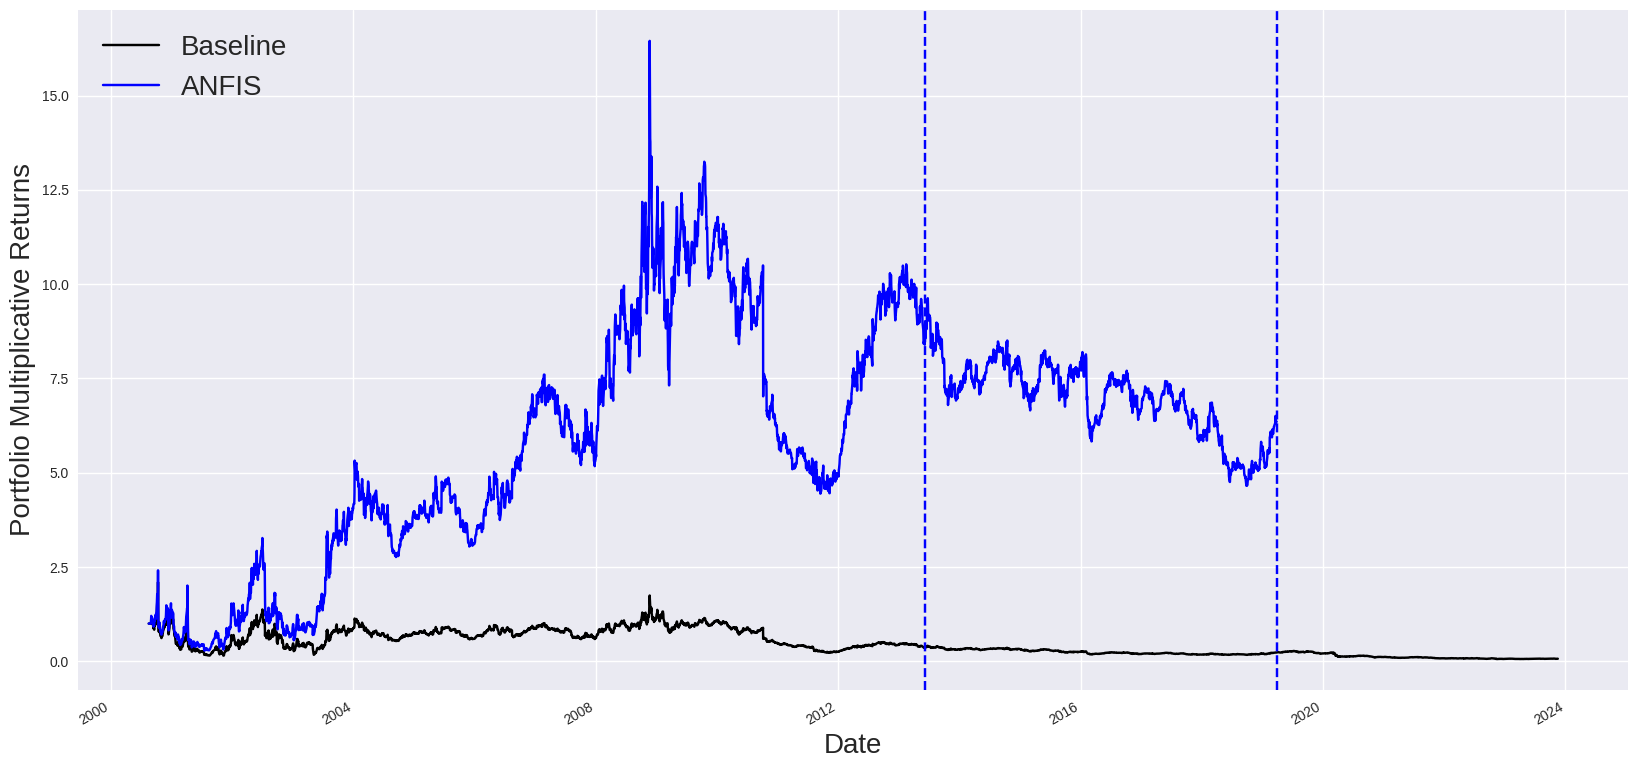

In [ ]:

# Place predicted train & val 'Close' prices into df3
predicted = np.concatenate((y_train_pred, y_val_pred))
predicted = predicted[:,0]
index_labels = df.index.array[0:num_val]
df4 = pd.DataFrame(predicted, index=index_labels, columns=['Close'])


# Compute Baseline Returns
compute_trade_signals(df,plt_pos=False, plt_trade=False)
df = compute_returns(df, 0.005)

# Compute ANFIS Returns
compute_trade_signals_predicted(df4,plt_pos=False, plt_trade=False)
df4 = compute_returns(df4, 0.005)


# Plot Multiplicative Returns
plt.figure(figsize = (20,10))
df['Returns'].plot(color = 'k', label= 'Baseline')
df4['Returns'].plot(color = 'b', label= 'ANFIS')
plt.axvline(num_train_date, color='b', linestyle='--')
plt.axvline(num_val_date, color='b', linestyle='--')
plt.legend(loc=2, fontsize=20)
plt.ylabel('Portfolio Multiplicative Returns', size=20)
plt.xlabel('Date', size=20)

ANFIS Model Test Data Prediction

1171/1171 [==============================] - 2s 1ms/step


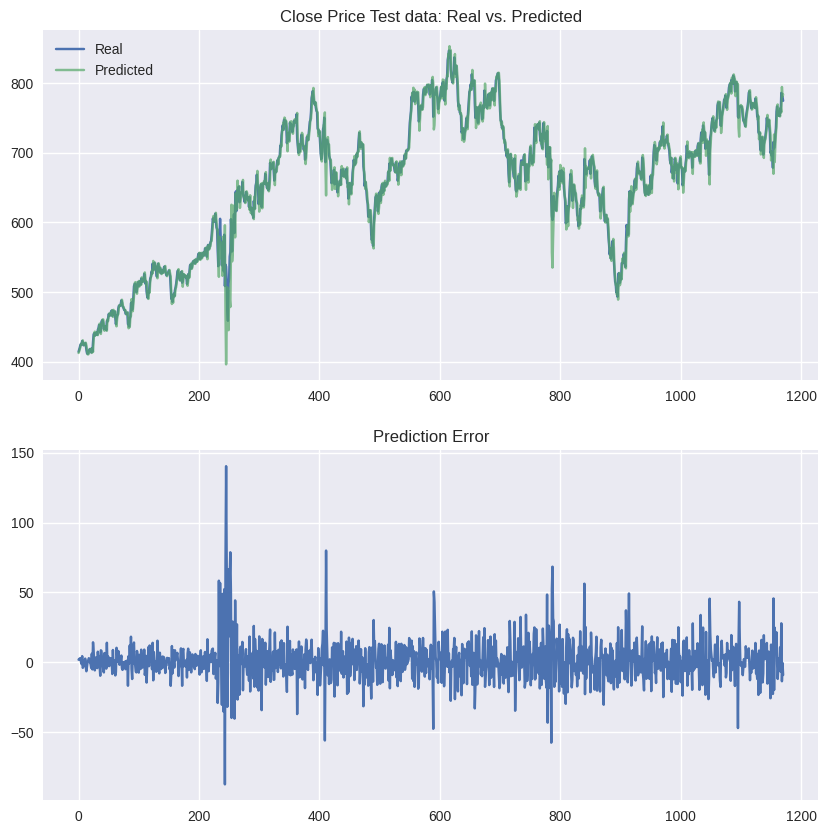

In [ ]:
# Plot test data vs predicted of test data
y_test_pred_b4 = fis(X_test) # predicted scaled delta
y_test_pred = scaler_Y.inverse_transform(y_test_pred_b4) # predicted unscaled delta
y_test_pred = np.reshape(df['Close'][num_val:num_test].values, [-1,1]) + y_test_pred # predicted unscaled 'Close' price

y_test = scaler_Y.inverse_transform(y_test) # real unscaled delta
y_test = np.reshape(df['Close'][num_val:num_test].values, [-1,1]) + y_test # real unscaled 'Close' price

f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(y_test)
axs[0].plot(y_test_pred, alpha=.7)
axs[0].legend(['Real', 'Predicted'])
axs[0].grid(True)
axs[0].set_title('Close Price Test data: Real vs. Predicted')
axs[1].plot(np.arange(y_test.shape[0]), y_test - y_test_pred)
axs[1].grid(True)
axs[1].set_title('Prediction Error')
plt.show()

Plot Multiplicative Returns of ANFIS Train, Val & Test Predictions vs Baseline

Text(0.5, 0, 'Date')

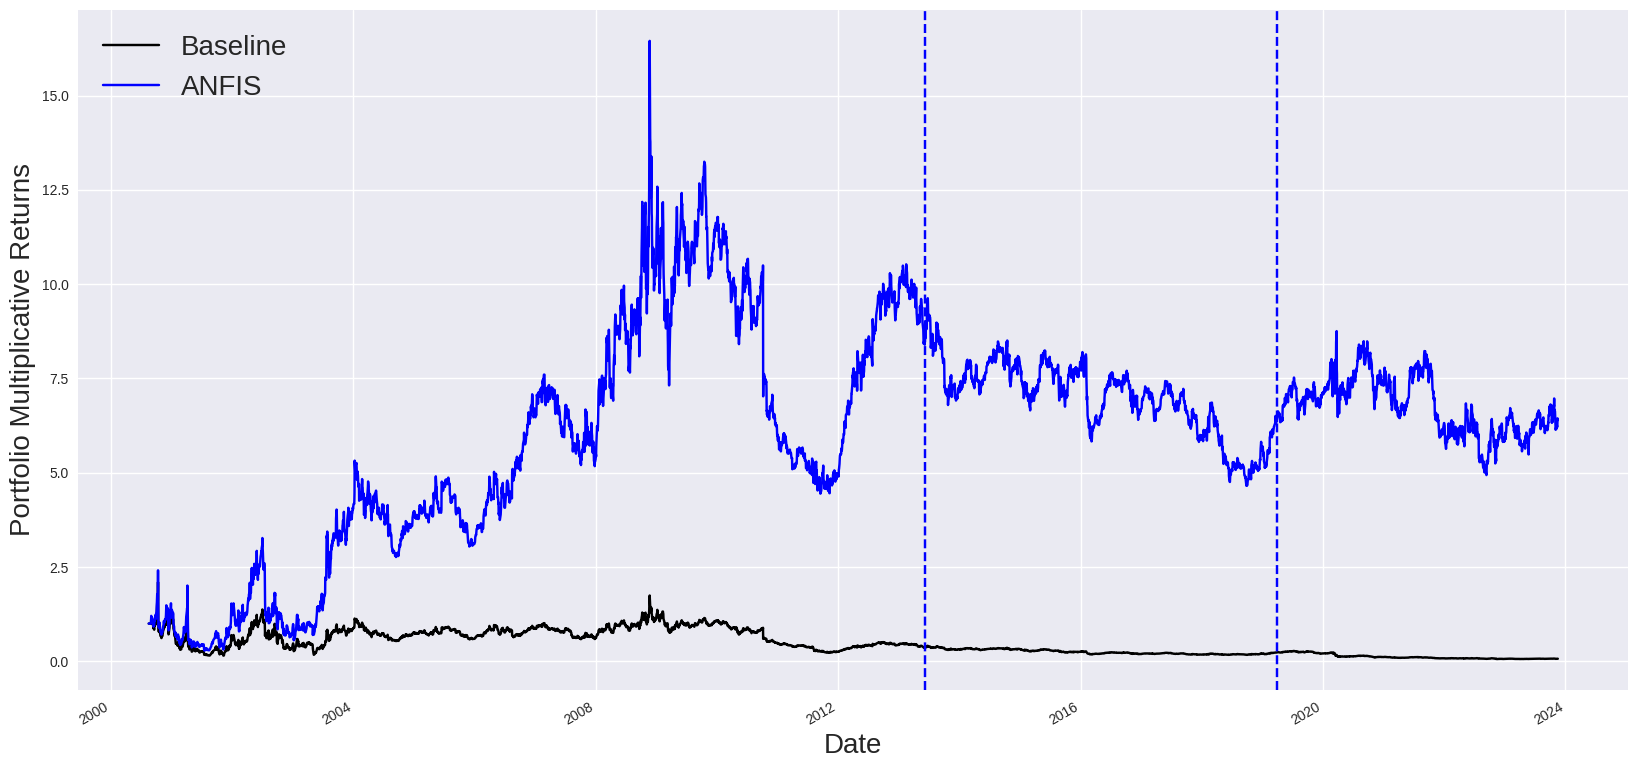

In [ ]:
# Place predicted train, val & test 'Close' prices into df3
predicted = np.concatenate((y_train_pred, y_val_pred, y_test_pred))
predicted = predicted[:,0]
index_labels = EQ_DF.index.array[num_days:num_rows-1]
df4 = pd.DataFrame(predicted, index=index_labels, columns=['Close'])

# Compute ANFIS Returns
compute_trade_signals_predicted(df4,plt_pos=False, plt_trade=False)
df4 = compute_returns(df4, 0.005)

# Plot Multiplicative Returns
plt.figure(figsize = (20,10))
df['Returns'].plot(color = 'k', label= 'Baseline')
df4['Returns'].plot(color = 'b', label= 'ANFIS')
plt.axvline(num_train_date, color='b', linestyle='--')
plt.axvline(num_val_date, color='b', linestyle='--')
plt.legend(loc=2, fontsize=20)
plt.ylabel('Portfolio Multiplicative Returns', size=20)
plt.xlabel('Date', size=20)

## 4.Plot Memberships of ANFIS

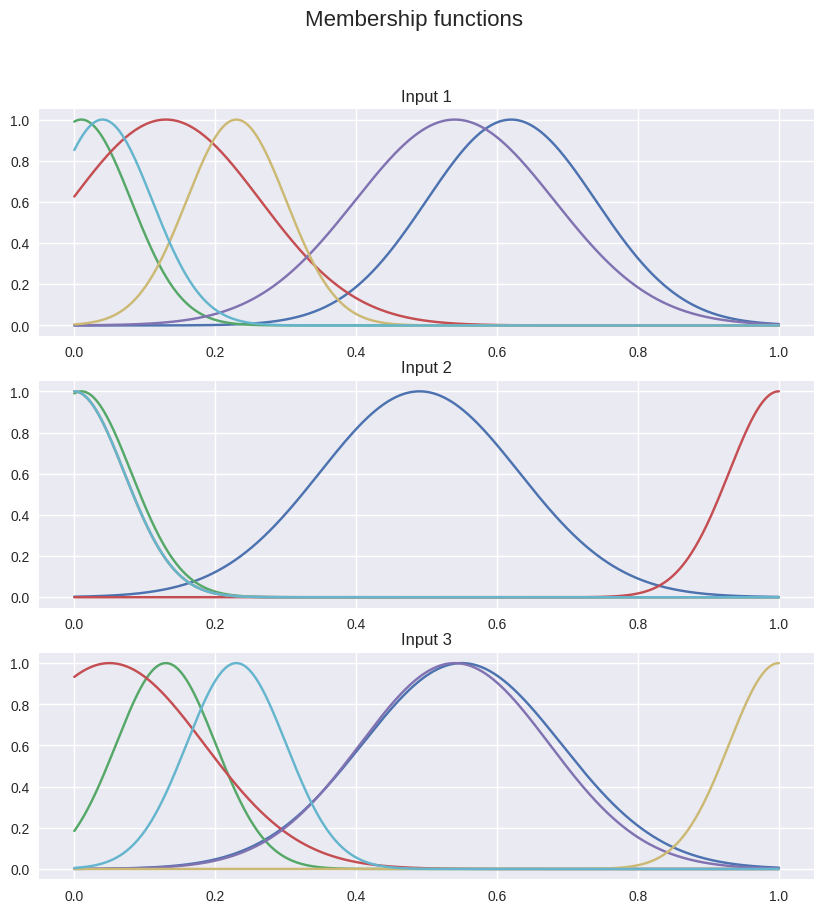

In [ ]:
fis.plotmfs(show_initial_weights=False)

Compare DENFIS/LSTM/ without forecast/ ANFIS

Text(0.5, 0, 'Date')

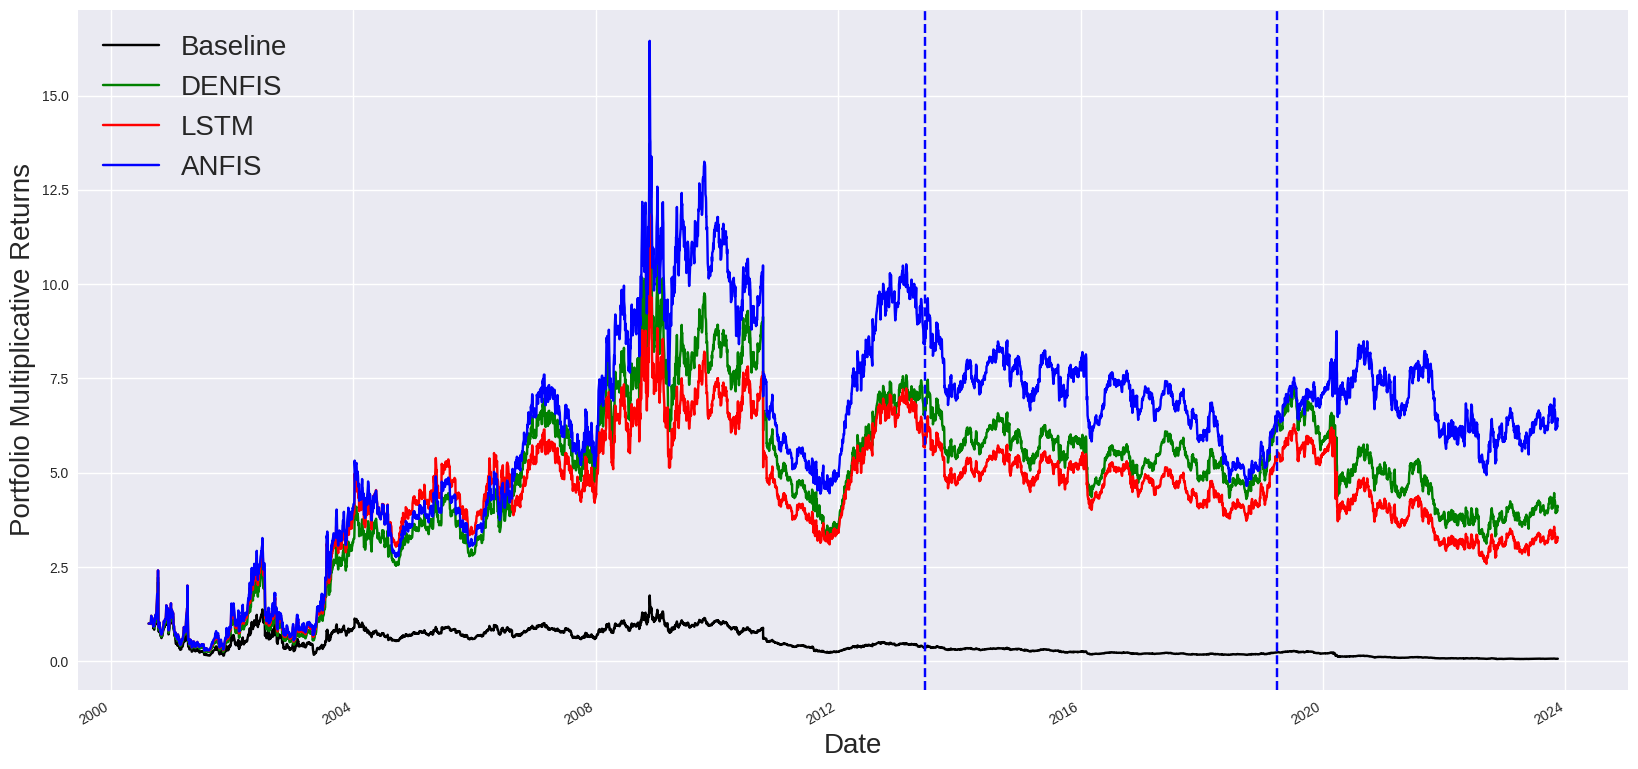

In [ ]:
plt.figure(figsize = (20,10))
df['Returns'].plot(color = 'k', label= 'Baseline')
df2['Returns'].plot(color = 'g', label= 'DENFIS')
df3['Returns'].plot(color = 'r', label= 'LSTM')
df4['Returns'].plot(color = 'b', label= 'ANFIS')

plt.axvline(num_train_date, color='b', linestyle='--')
plt.axvline(num_val_date, color='b', linestyle='--')
plt.legend(loc=2, fontsize=20)
plt.ylabel('Portfolio Multiplicative Returns', size=20)
plt.xlabel('Date', size=20)

In [ ]:
start_date = '2021-01-01'
end_date = '2023-10-31'
initial_capital = 10000  # Starting capital

# Function to shift the trade signals by 3 days
def shift_trade_signals(df):
    shifted_df = df.copy()
    shifted_df['Trade'] = df['Trade'].shift(-3)  # Shift trade signals by 3 days
    return shifted_df

# Backtest function
def backtest_strategy(df, initial_capital):
    capital = initial_capital
    position = 0  # No position initially

    for index, row in df[start_date:end_date].iterrows():
        if row['Trade'] == 1 and position == 0:  # Buy signal
            position = capital / row['Close']  # Buy as many shares as possible
            capital = 0
        elif row['Trade'] == 0 and position != 0:  # Sell signal
            capital = position * row['Close']  # Sell all shares
            position = 0

    # Final value of the portfolio
    final_day_close = df[end_date:end_date]['Close'].values[0]
    final_value = capital + position * final_day_close
    return final_value

# Shift the DENFIS trade signals by 3 days
df2_shifted = shift_trade_signals(df2)
df4_shifted=shift_trade_signals(df4)

# Backtest the original and DENFIS strategies

denfis_final_value = backtest_strategy(df2_shifted, initial_capital)
anfis_final_value = backtest_strategy(df4_shifted, initial_capital)

# Print results

print(f"DENFIS Strategy Final Portfolio Value: ${denfis_final_value:,.2f}")
print(f"ANFIS Strategy Final Portfolio Value: ${anfis_final_value:,.2f}")

DENFIS Strategy Final Portfolio Value: $10,538.89
ANFIS Strategy Final Portfolio Value: $10,678.59
